导入需要的库

In [1]:
!pip  install seaborn
!pip  install matplotlib
!pip  install --upgrade pip
!pip  install hyperopt
!pip  install xgboost
!pip  install shap


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\anaconda\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
import numpy as np
import random
import shap
import hyperopt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from copy import deepcopy
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, fmin, tpe, Trials 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import hp, fmin, tpe, space_eval  
warnings.filterwarnings("ignore")

读入数据，对数据进行预处理，删除缺失值

In [24]:
df = pd.read_csv("C:/Users/86151/Desktop/machinelearn/7-2fb2.csv")#氮脱烷基
Y = np.array(df["Y"])
print(df.describe())

           ATSC1i     AATSC2v   ETA_eta_B   ETA_dBeta          CIC3  \
count  286.000000  286.000000  286.000000  286.000000  2.860000e+02   
mean    -8.888857    2.605894    0.250495   -1.975524  7.948428e-01   
std      8.309205    5.901944    0.157493    3.117342  3.968365e-01   
min    -36.054640  -12.748251   -0.017638  -14.250000 -4.440000e-16   
25%    -12.597260   -0.880368    0.143357   -4.000000  5.163859e-01   
50%     -7.492897    2.189220    0.232673   -1.250000  7.393279e-01   
75%     -3.571988    5.868024    0.319824    0.000000  9.715812e-01   
max     10.128136   20.039916    1.028477    4.500000  2.650978e+00   

         SMR_VSA6  SlogP_VSA2  
count  286.000000  286.000000  
mean    16.377102   29.095933  
std     10.106782   13.633755  
min      0.000000    5.907180  
25%      7.109798   18.996693  
50%     13.654554   27.854170  
75%     20.640100   36.613745  
max     59.460989   89.480300  


提取数据中的标签和特征

In [25]:
X_list = []
X_name = []
for col in df:
    if col == "NAME" or col == "Y":
        continue
    X_name.append(col)
    temp = np.array(df[col])
    temp = temp.reshape(-1, 1)
    X_list.append(temp)
X_name = set(X_name)
X = np.concatenate(X_list, axis=-1)
print(X.shape)
print(X)
for i in range(len(Y)):
    if Y[i] == "yes":
        Y[i] = 1
    else:
        Y[i] = 0
Y = np.array(Y, dtype=int)
print(Y.shape)
print(Y)

(286, 7)
[[-5.94786171 -3.08624412  0.21477505 ...  0.45283019 10.63357721
  15.87513677]
 [-5.30764039  4.96297355  0.21150496 ...  0.40938712 13.65455395
  24.5457122 ]
 [-0.4422105   0.73600803  0.08418376 ...  0.8986912  20.19931035
  20.19931035]
 ...
 [-3.17430038  9.11415343  0.30082136 ...  0.29369076  7.04767198
  23.02351891]
 [-8.99738792  3.73579463  0.31332681 ...  0.62786755 18.40630142
  28.07992846]
 [ 0.84610403  4.7865478   0.35275205 ...  1.04634318  6.54475641
   6.54475641]]
(286,)
[1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0

将数据分割成训练集和测试集

In [26]:
# 采用留出法对数据进行分割 
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state =42)
x_types = []
temp = set()
for item in X_train:
    temp.add(str(item))
for item in X:
    item = str(item)
    if item in temp:
        x_types.append("train")
    else:
        x_types.append("test")
df["type"] = x_types
print(x_types)

['train', 'train', 'train', 'train', 'train', 'test', 'test', 'train', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'train', 'test', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'train', 'train', 'test', 'train', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'train', 'train', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'test', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'test', 'train', 'test', 'train', 'tra

测试和可视化函数

In [27]:
from sklearn.metrics import  matthews_corrcoef
cur_tif_name = "temp.tif"
def evaluate_model(truths, predictions, train_fpr=None, train_tpr=None, train_AUC=None):
    acc = accuracy_score(truths, predictions)
    p = precision_score(truths, predictions)
    r = recall_score(truths, predictions)
    f1 = f1_score(truths, predictions)

    # 画混淆矩阵
    cm = confusion_matrix(truths, predictions)
    tn, fp, fn, tp = confusion_matrix(truths, predictions).ravel()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(
        include_values=True,
        values_format="d"
    )
    plt.show()

    accuracy=(tp+tn)/(tp+fn+fp+tn)
    print("准确度：{}".format(accuracy))
    sensitivity=(tp)/(tp+fn)
    print("灵敏度：{}".format(sensitivity))
    specificity = tn / (tn + fp)
    print("特异度：{}".format(specificity))
    mcc = matthews_corrcoef(truths, predictions)
    print("MCC: {}".format(mcc))
    
    FPR, TPR, thresholds = roc_curve(truths, predictions)
    AUC = auc(FPR, TPR)
    # 画AUC ROC图
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 600
     
    if train_fpr is not None and train_tpr is not None:

        # 修改字体为支持中文显示
        plt.rc('font', family='Arial Unicode MS', size=18)
        plt.plot(train_fpr, train_tpr, label="train_AUC={:.2f}".format(train_AUC), marker='o', color='k', linestyle='-')
        plt.plot(FPR, TPR, label="test_AUC={:.2f}".format(AUC), marker='o', color='k', linestyle='--')
        #plt.legend(loc=4, fontsize=10)
        # 添加图例，位置在右下角，字体大小为10，并且去掉图例边框
        plt.legend(loc=4, fontsize=20, frameon=False)
        # 调整图例位置，稍微向左上方移动
        plt.legend(loc='upper left', fontsize=20, frameon=False, bbox_to_anchor=(0.4, 0.35))
        # 在左上角添加 'a.'
        #plt.text(0.03, 1, 'd.', fontsize=24, transform=plt.gca().transAxes)
        #plt.title('ROC曲线', fontsize=20)
        # 设置x轴和y轴的标签为中文
        #plt.xlabel('1-特异度', fontsize=14)
        #plt.ylabel('灵敏度', fontsize=14)
        plt.xlabel('1-specificity', fontsize=22)
        plt.ylabel('sensitivity', fontsize=22)
        # 获取当前图像的坐标轴对象，并去除上和右的边框
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # 翻转刻度的方向，使它们朝内
        ax.tick_params(direction='in')  # 这会让所有刻度朝内
        plt.tight_layout()  # 自动调整布局
        plt.savefig(cur_tif_name, format='tif')
        plt.show()
        return acc, p, r, f1
    else:
        return acc, p, r, f1, FPR, TPR, AUC

1、XGBoost

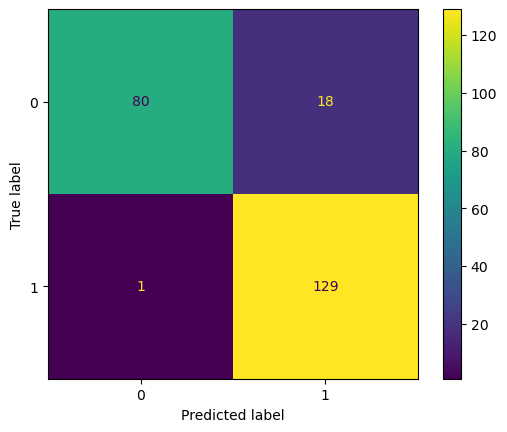

准确度：0.9166666666666666
灵敏度：0.9923076923076923
特异度：0.8163265306122449
MCC: 0.836441658997079
内部验证accuracy：0.917
内部验证precision：0.878
内部验证recall：0.992
内部验证f1-score：0.931


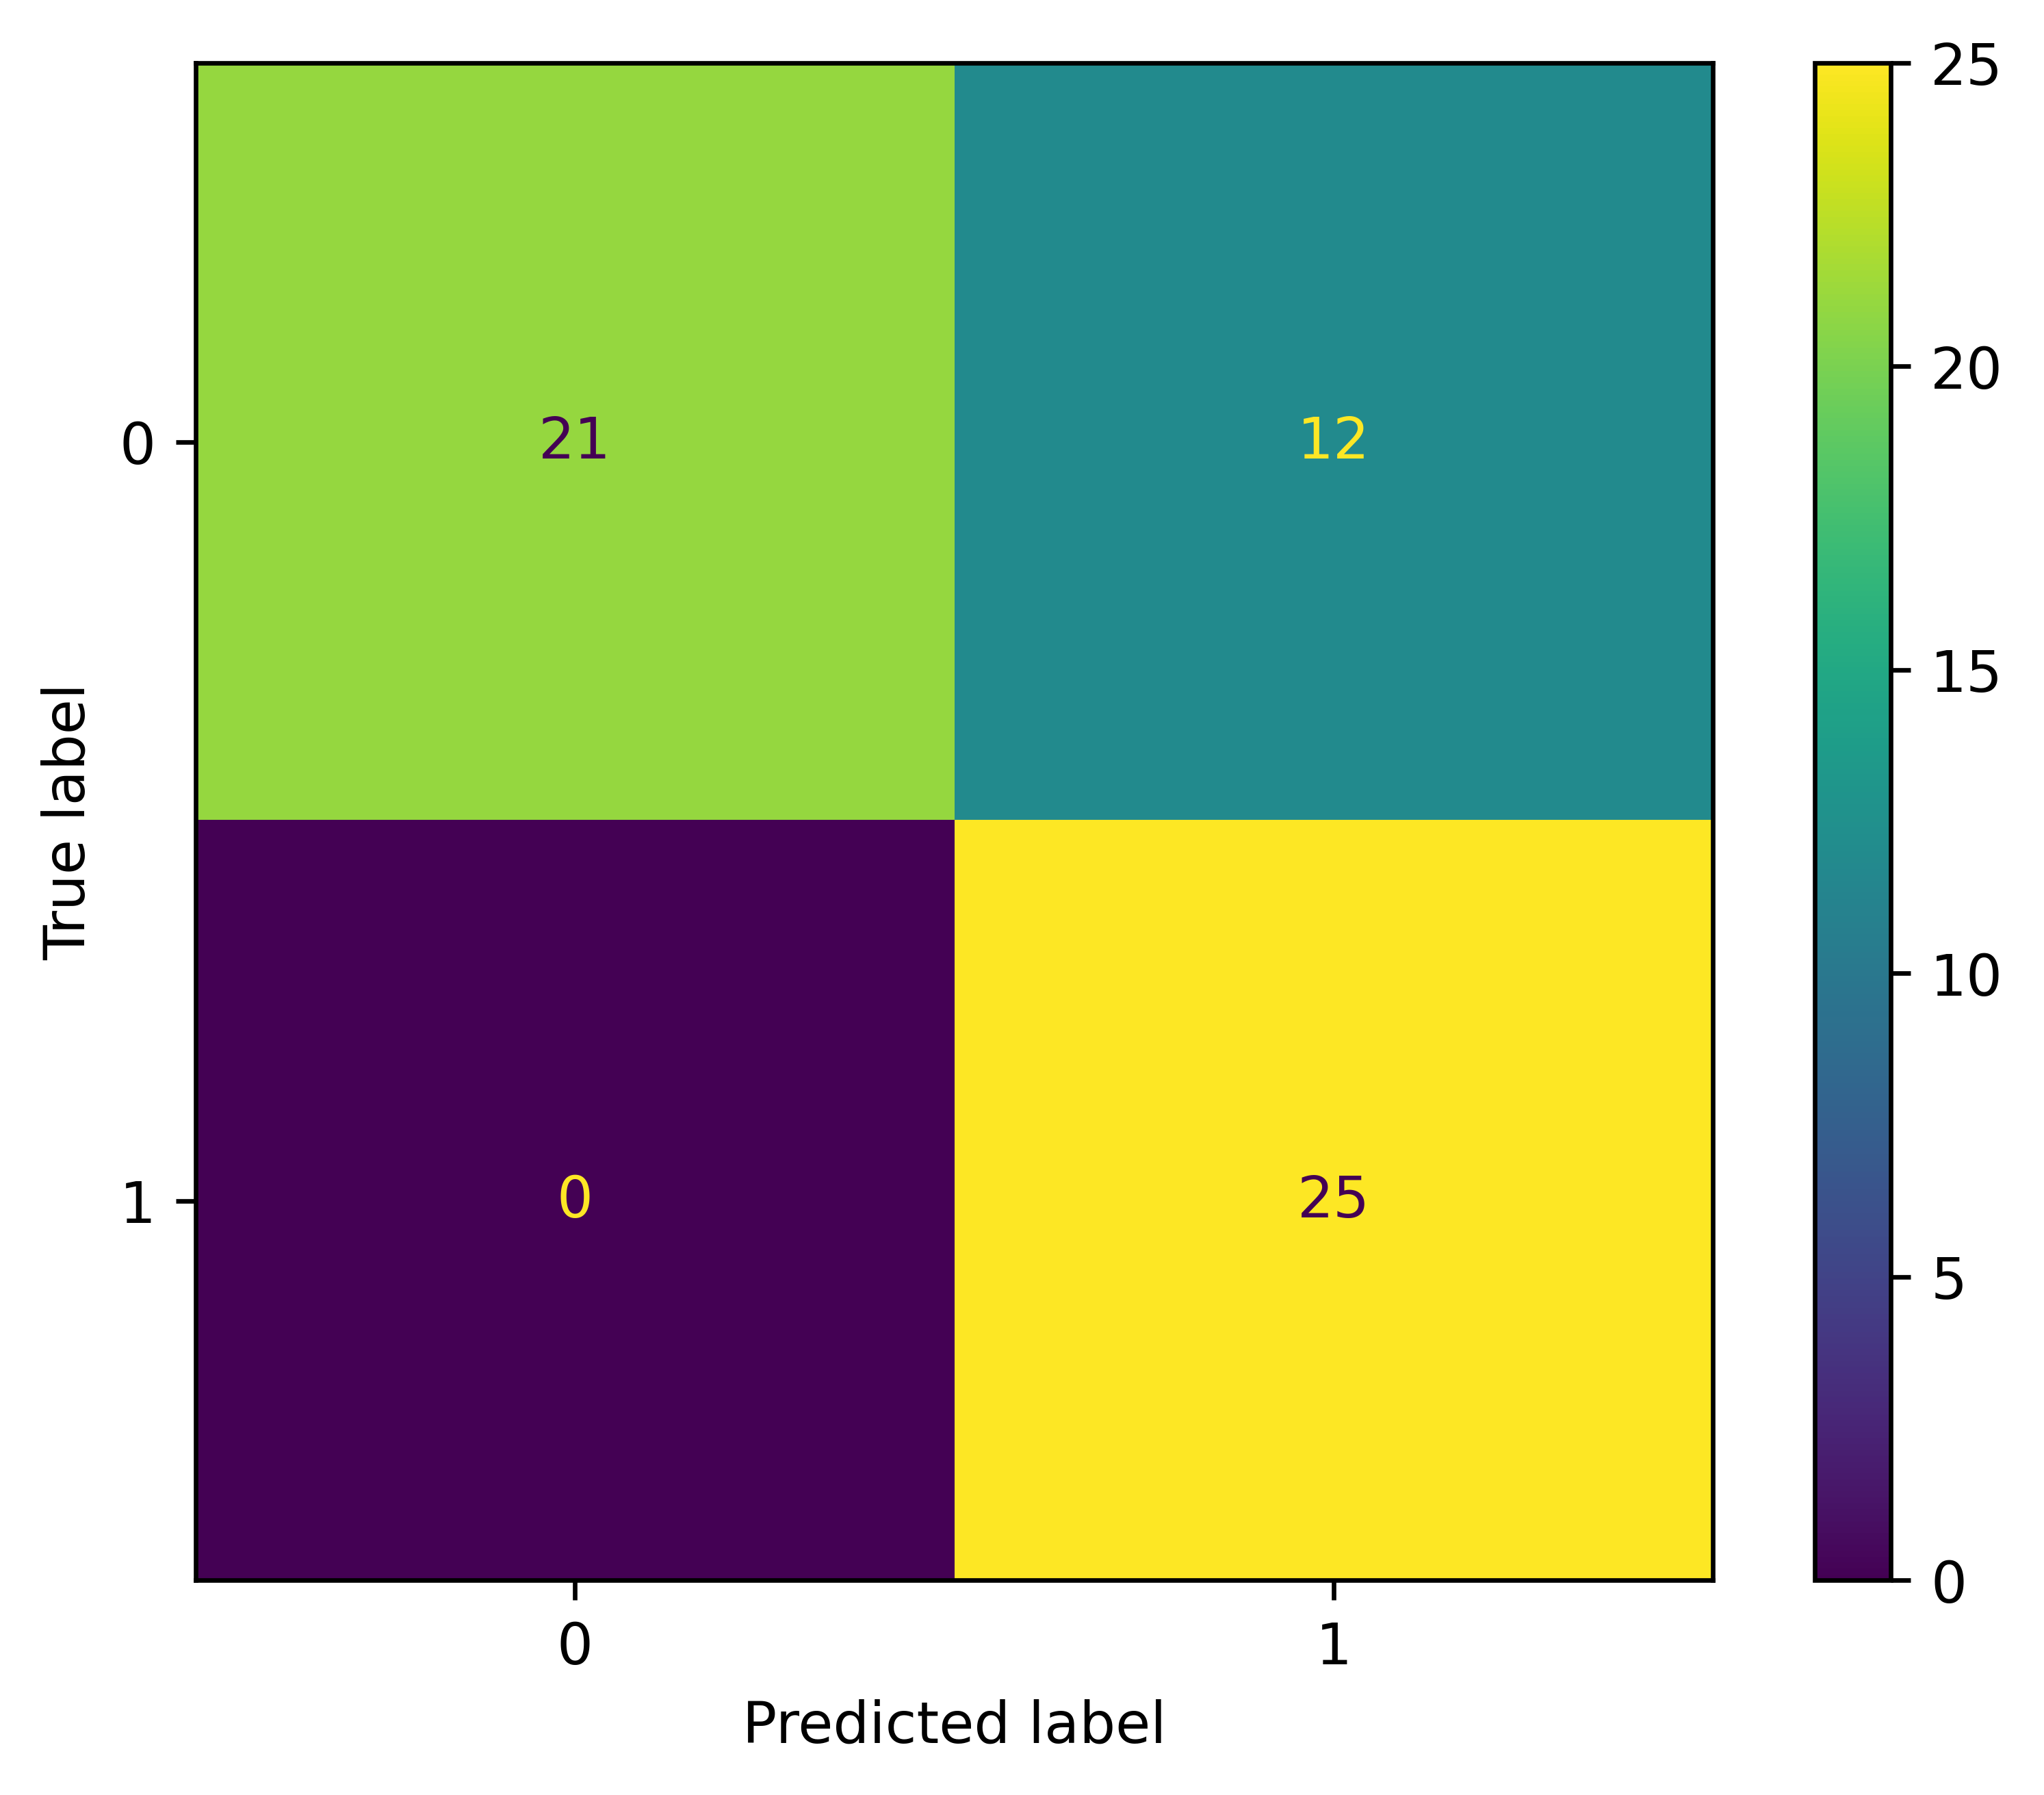

准确度：0.7931034482758621
灵敏度：1.0
特异度：0.6363636363636364
MCC: 0.6557251176944726


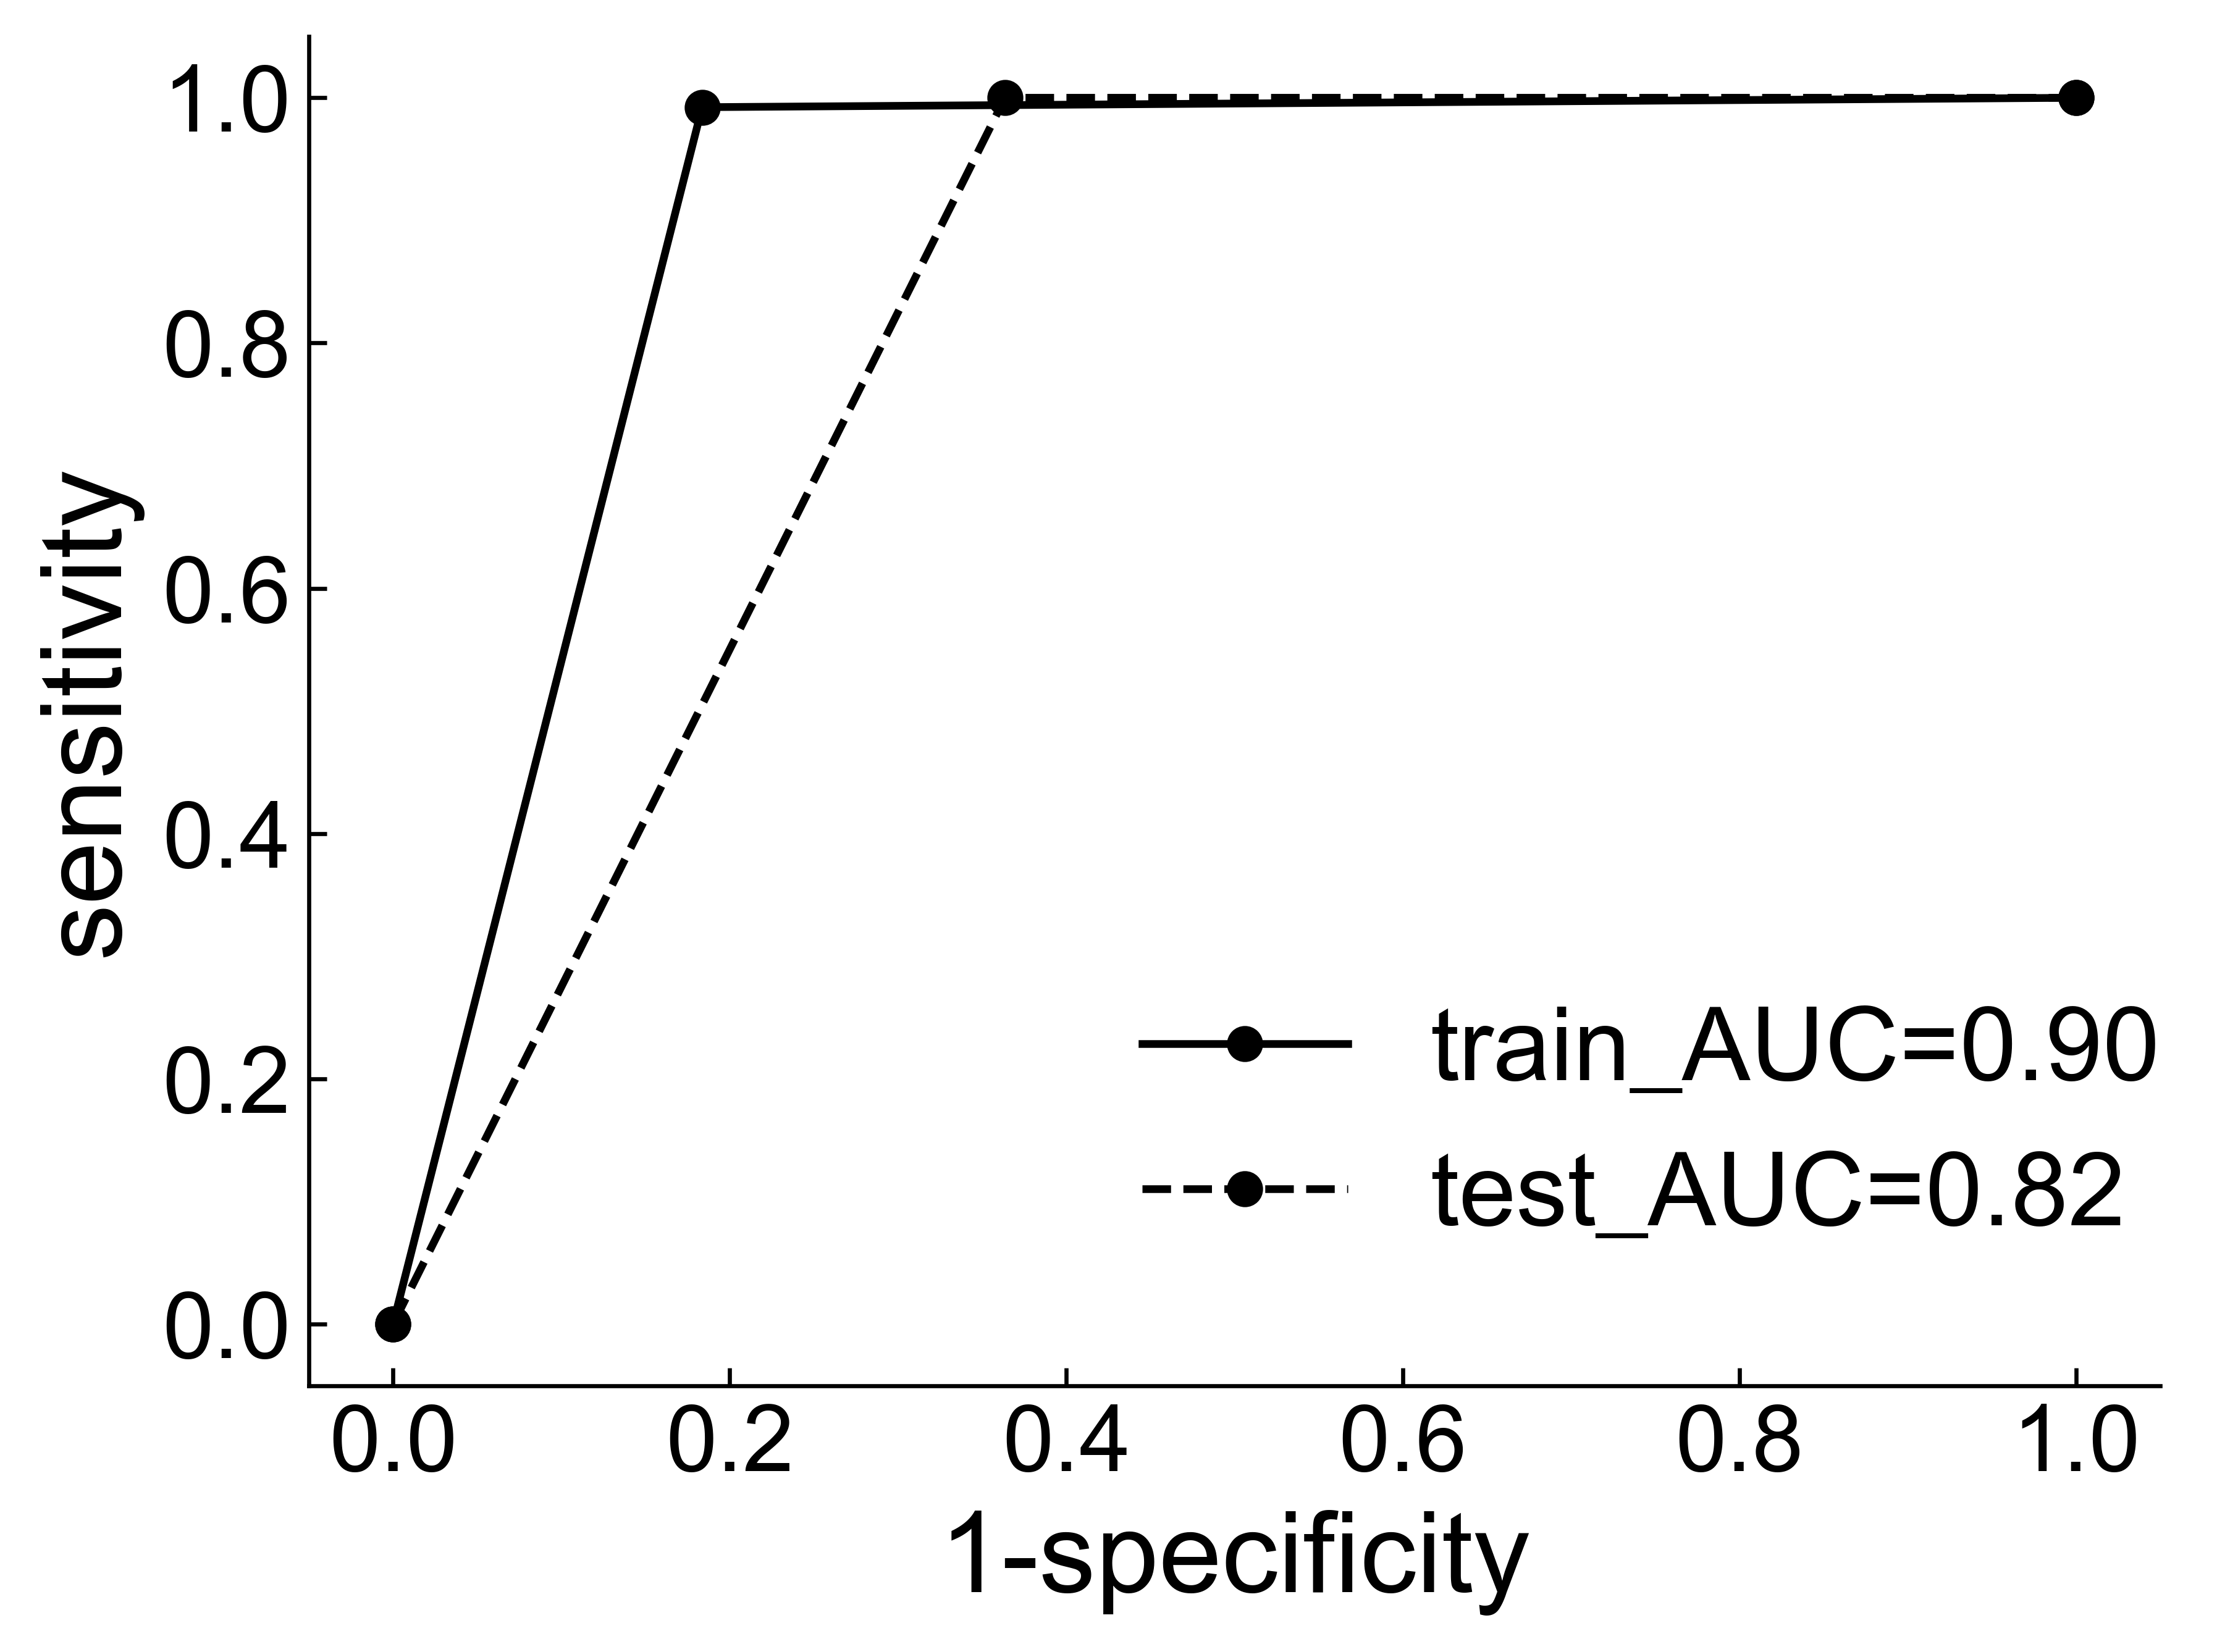

外部验证accuracy：0.793
外部验证precision：0.676
外部验证recall：1.000
外部验证f1-score：0.806


In [7]:
# 定义目标函数
def objective(params):
    model = xgb.XGBClassifier(**params)
    loss = 1 - cv_scores.mean()
    return loss

# 初始化XGBoost分类器
xgb_model = xgb.XGBClassifier(min_child_weight=0.125,subsample=0.8,colsample_bytree=0.9,learning_rate=0.001,n_estimators=300)
cur_tif_name = "C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-XGBoost .tif"

# 训练模型，并进行验证
xgb_model.fit(X_train, Y_train)

# 交叉验证代码
scores = cross_val_score(xgb_model, X_train, Y_train, cv=5)

# 分别进行内部验证和外部验证
train_predictions = xgb_model.predict(X_train)
acc, p, r, f1, FPR, TPR, AUC = evaluate_model(Y_train, train_predictions)
print("内部验证accuracy：{:.3f}".format(acc))
print("内部验证precision：{:.3f}".format(p))
print("内部验证recall：{:.3f}".format(r))
print("内部验证f1-score：{:.3f}".format(f1))

test_predictions = xgb_model.predict(X_test)
acc, p, r, f1 = evaluate_model(Y_test, test_predictions, FPR, TPR, AUC)
print("外部验证accuracy：{:.3f}".format(acc))
print("外部验证precision：{:.3f}".format(p))
print("外部验证recall：{:.3f}".format(r))
print("外部验证f1-score：{:.3f}".format(f1))

# 保存结果到csv，格式类似数据文件
all_predictions = xgb_model.predict(X)
temp_predictions = []
cur_df = deepcopy(df)
length = len(all_predictions)
for i in range(length):
    if all_predictions[i] == 1:
        temp_predictions.append("yes")
    else:
        temp_predictions.append("no")
cur_df["Y"] = temp_predictions
#cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/soft-O_weight/单一模型-XGBoost.csv", index=False)
#cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/soft-N_weight/单一模型-XGBoost.csv", index=False)
cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-XGBoost.csv", index=False)
#cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-XGBoost.csv", index=False)

2、MLP

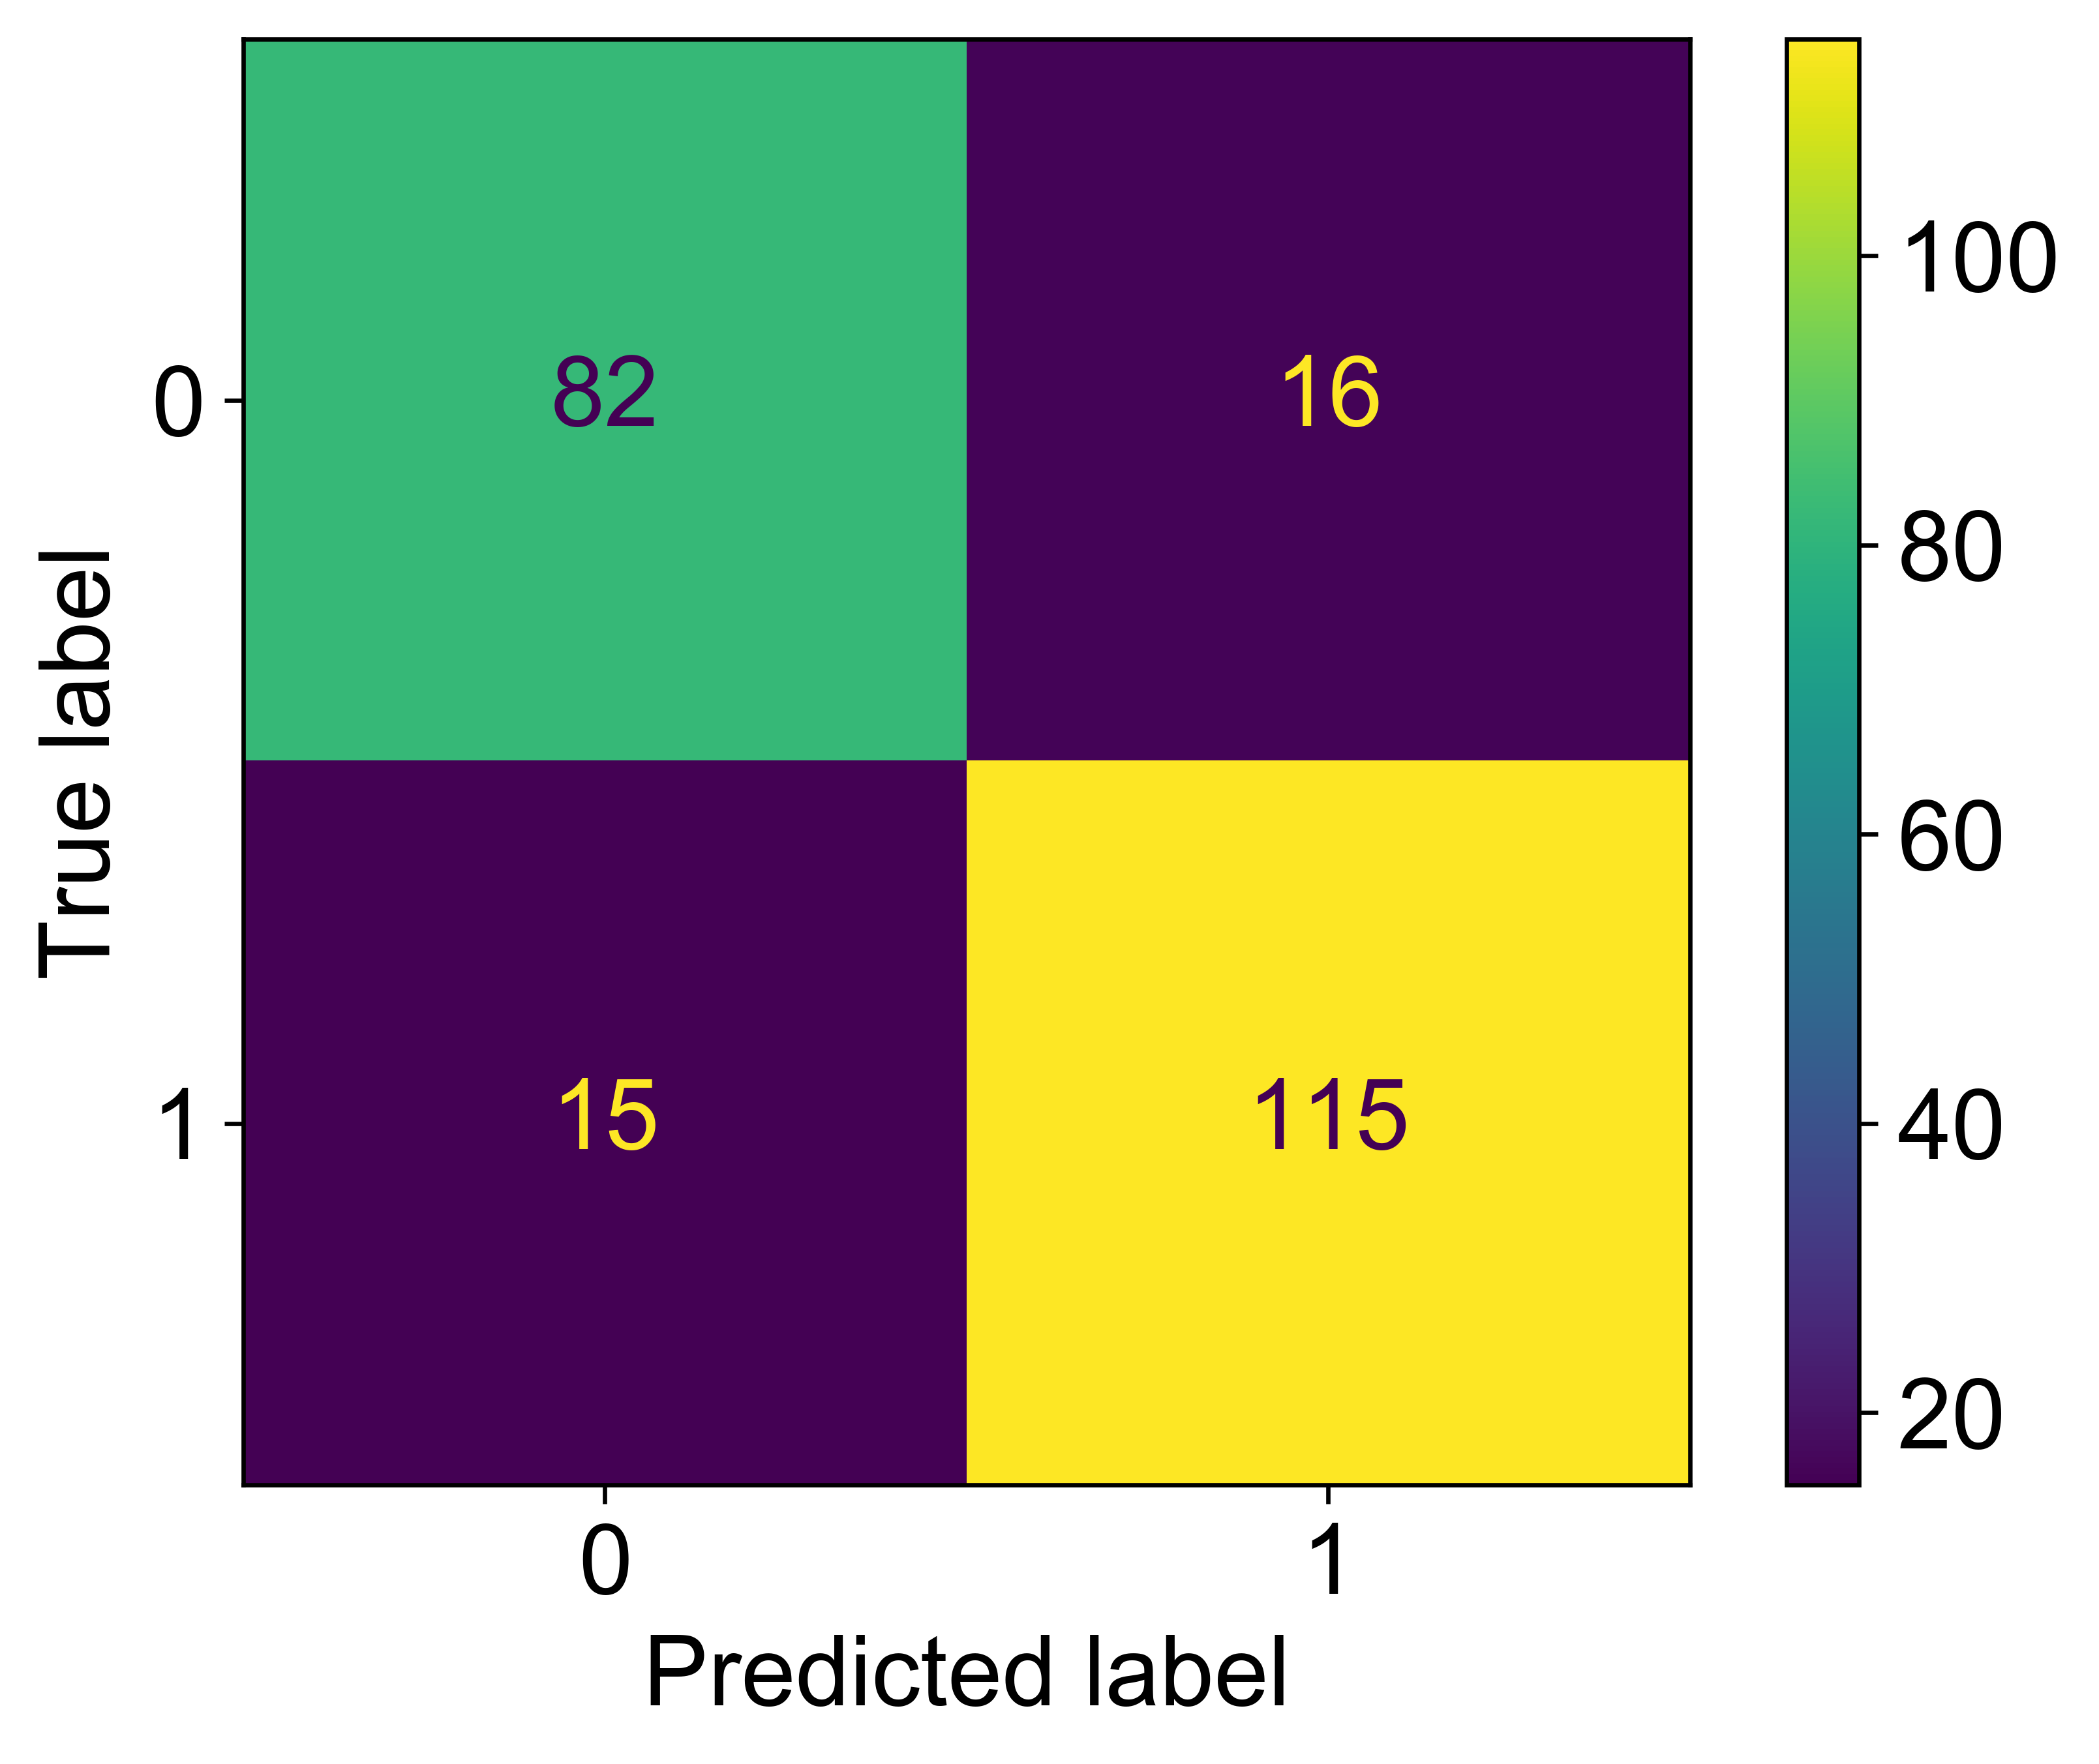

准确度：0.8640350877192983
灵敏度：0.8846153846153846
特异度：0.8367346938775511
MCC: 0.7222861419838201
内部验证accuracy：0.864
内部验证precision：0.878
内部验证recall：0.885
内部验证f1-score：0.881


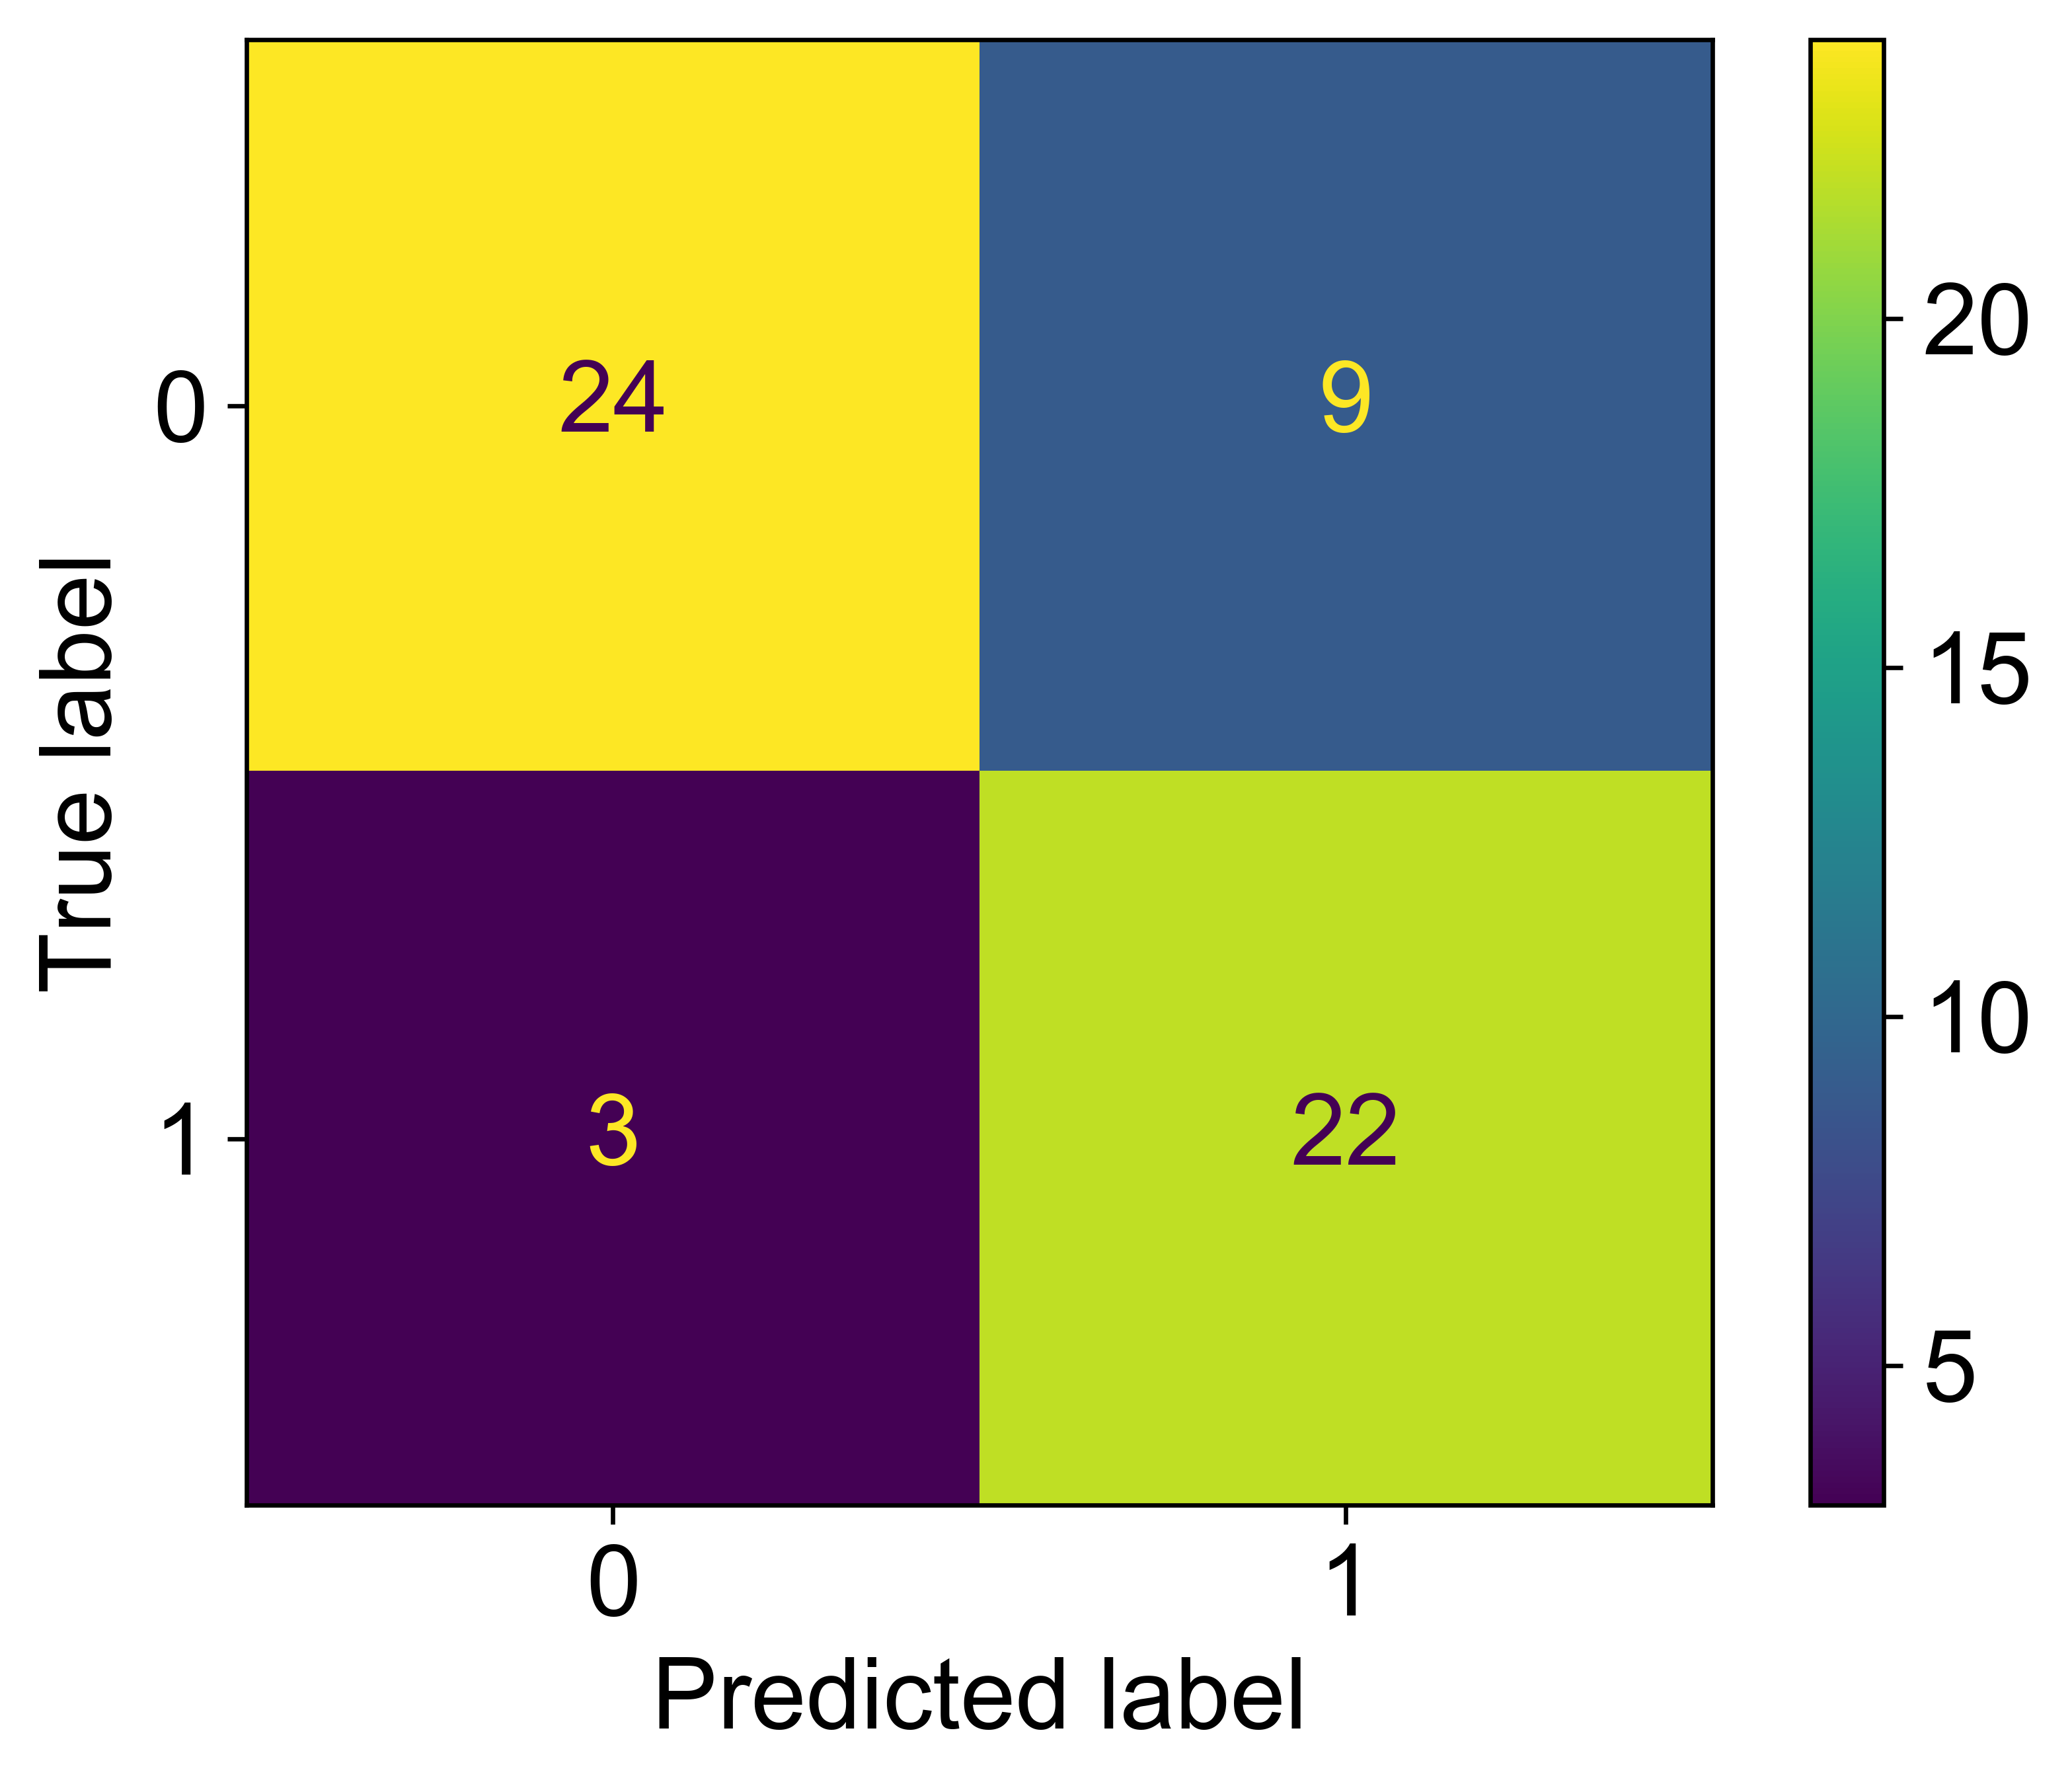

准确度：0.7931034482758621
灵敏度：0.88
特异度：0.7272727272727273
MCC: 0.602903801995589


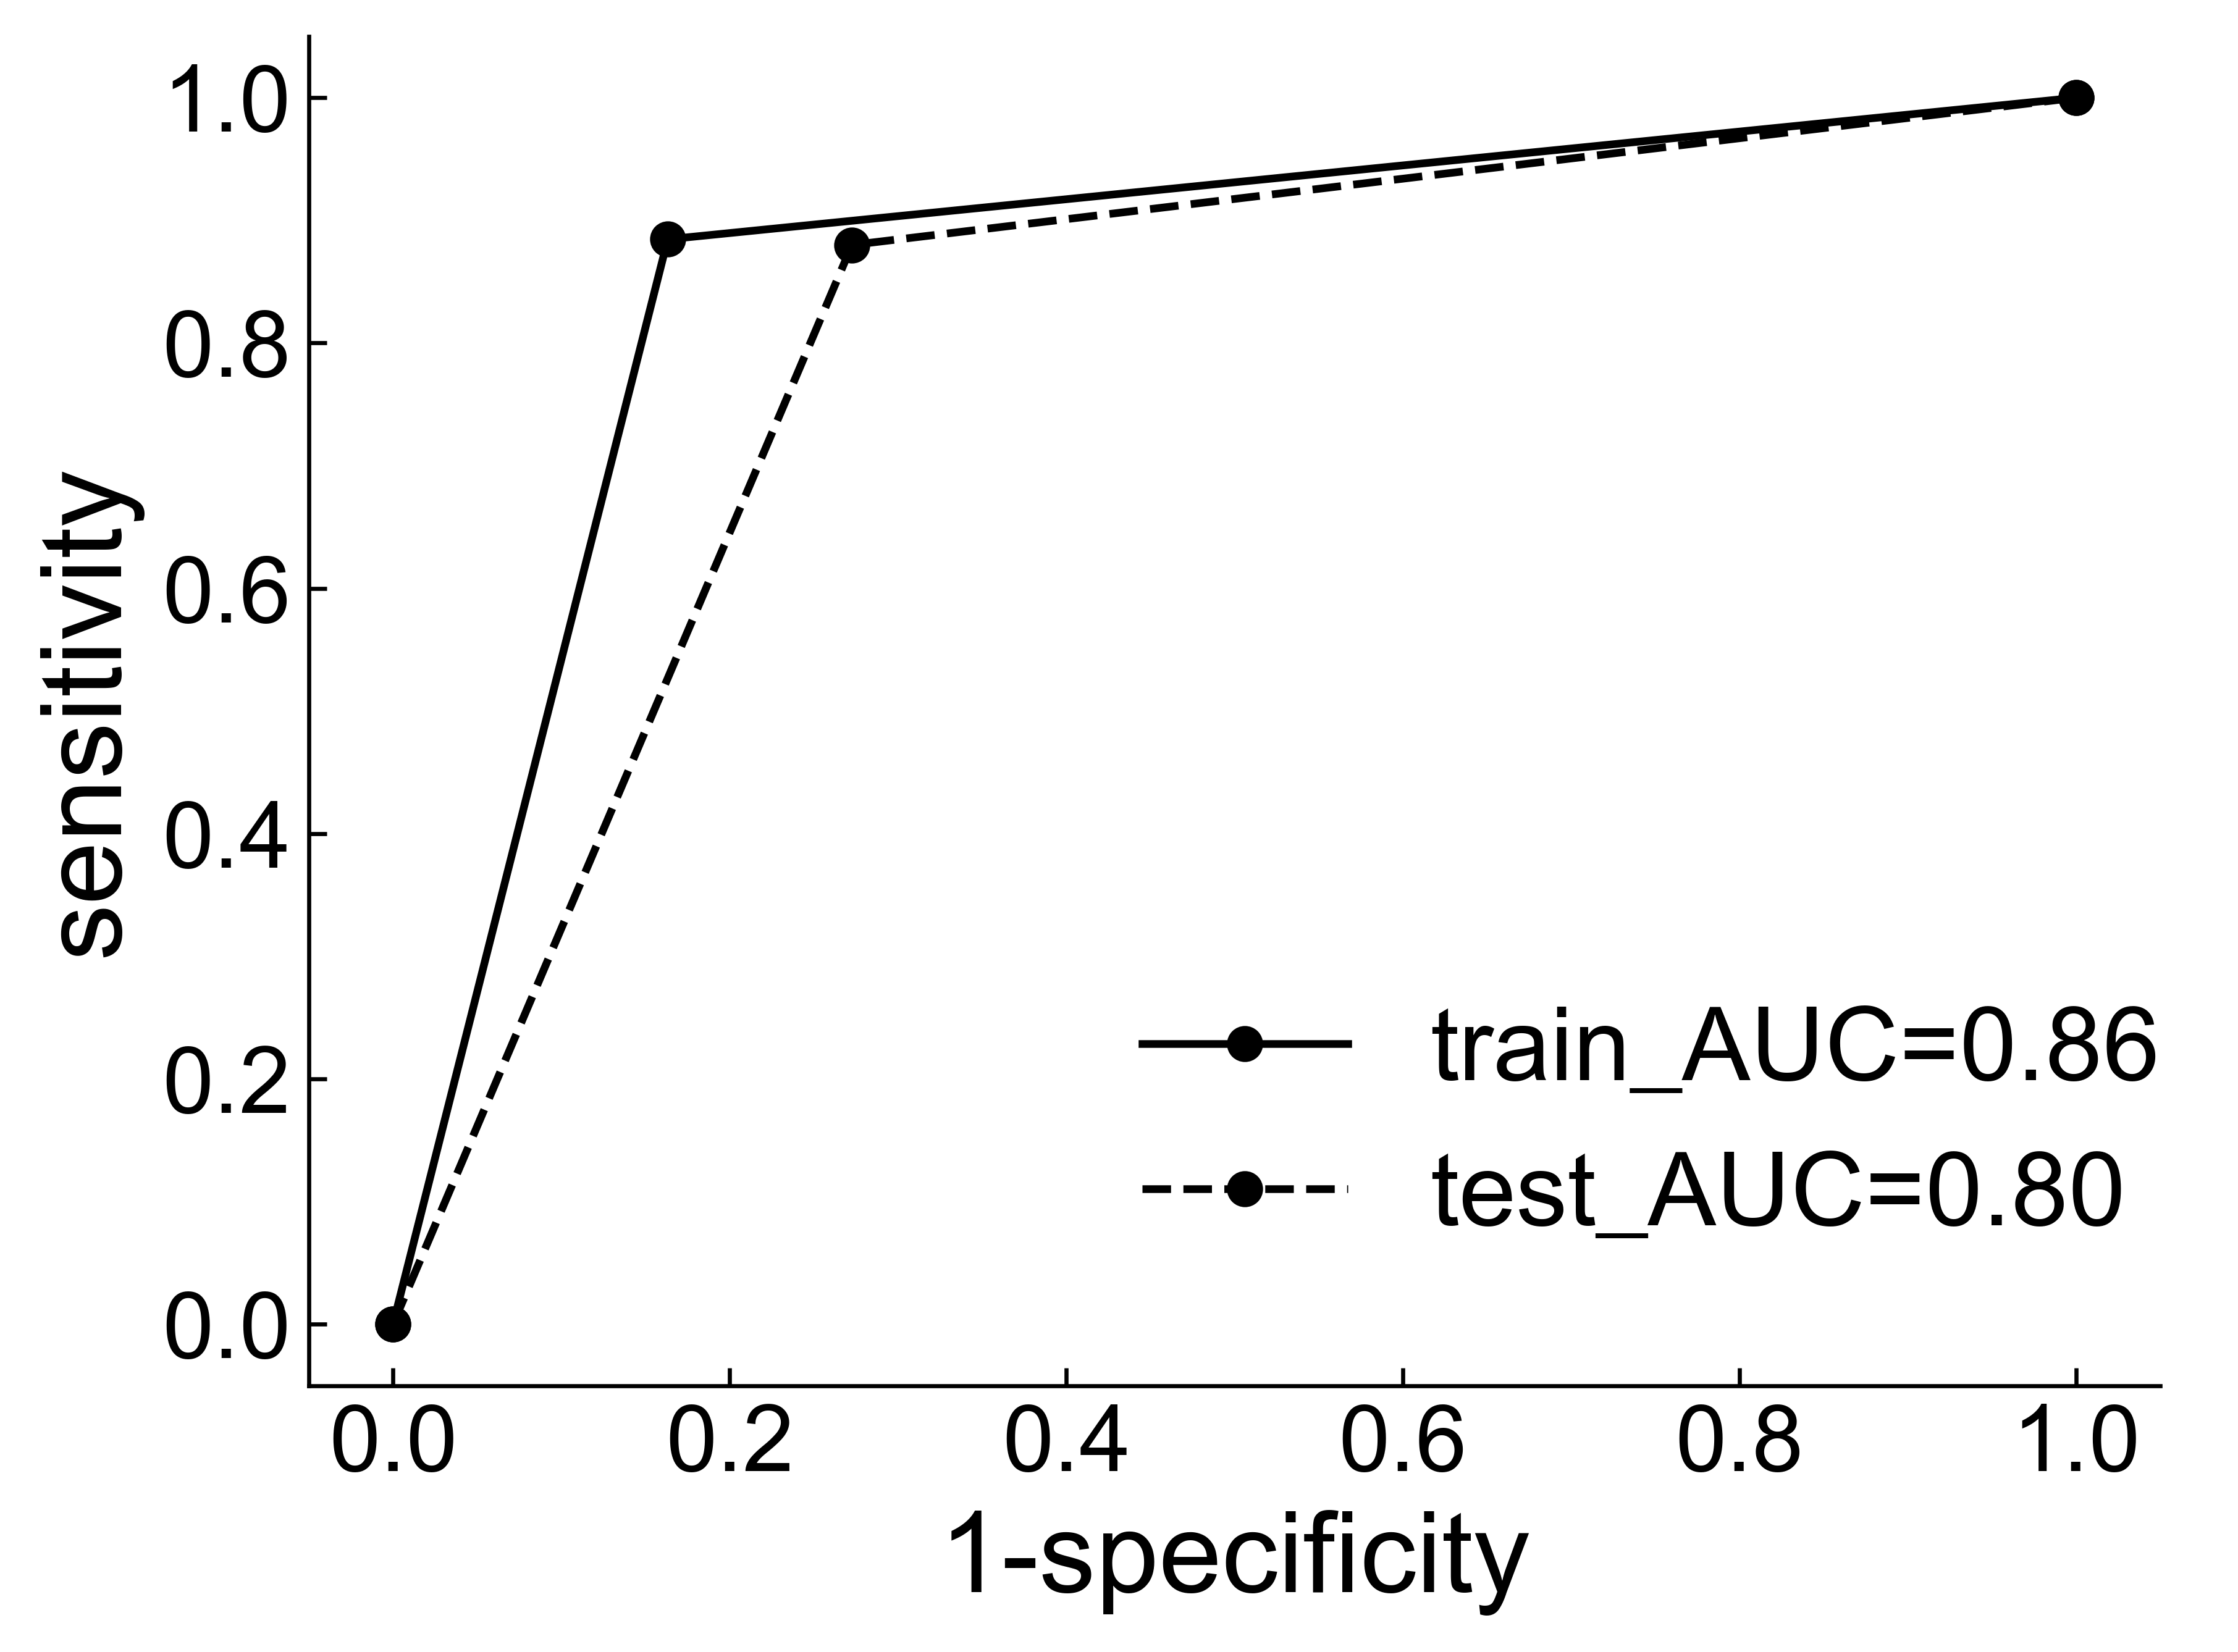

外部验证accuracy：0.793
外部验证precision：0.710
外部验证recall：0.880
外部验证f1-score：0.786


In [8]:
# 定义目标函数
def objective(params):
    model = MLPClassifier(**params)
    loss = 1 - cv_scores.mean()
    return loss
# 创建MLP模型
mlp_model = MLPClassifier(hidden_layer_sizes=(80,100,80),activation= 'logistic',solver='adam',alpha=0.001,learning_rate='adaptive', 
                          learning_rate_init=0.001,max_iter=800)

# 训练模型，并进行验证
mlp_model.fit(X_train, Y_train)
cur_tif_name = "C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-Mlp .tif"

# 交叉验证代码
scores = cross_val_score(mlp_model, X_train, Y_train, cv=5)

# 分别进行内部验证和外部验证
train_predictions = mlp_model.predict(X_train)
acc, p, r, f1, FPR, TPR, AUC = evaluate_model(Y_train, train_predictions)
print("内部验证accuracy：{:.3f}".format(acc))
print("内部验证precision：{:.3f}".format(p))
print("内部验证recall：{:.3f}".format(r))
print("内部验证f1-score：{:.3f}".format(f1))

test_predictions = mlp_model.predict(X_test)
acc, p, r, f1 = evaluate_model(Y_test, test_predictions, FPR, TPR, AUC)
print("外部验证accuracy：{:.3f}".format(acc))
print("外部验证precision：{:.3f}".format(p))
print("外部验证recall：{:.3f}".format(r))
print("外部验证f1-score：{:.3f}".format(f1))

# 保存结果到csv
all_predictions = mlp_model.predict(X)
temp_predictions = []
cur_df = deepcopy(df)
length = len(all_predictions)
for i in range(length):
    if all_predictions[i] == 1:
        temp_predictions.append("yes")
    else:
        temp_predictions.append("no")
cur_df["Y"] = temp_predictions
cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-MLP.csv", index=False)

3、随机森林

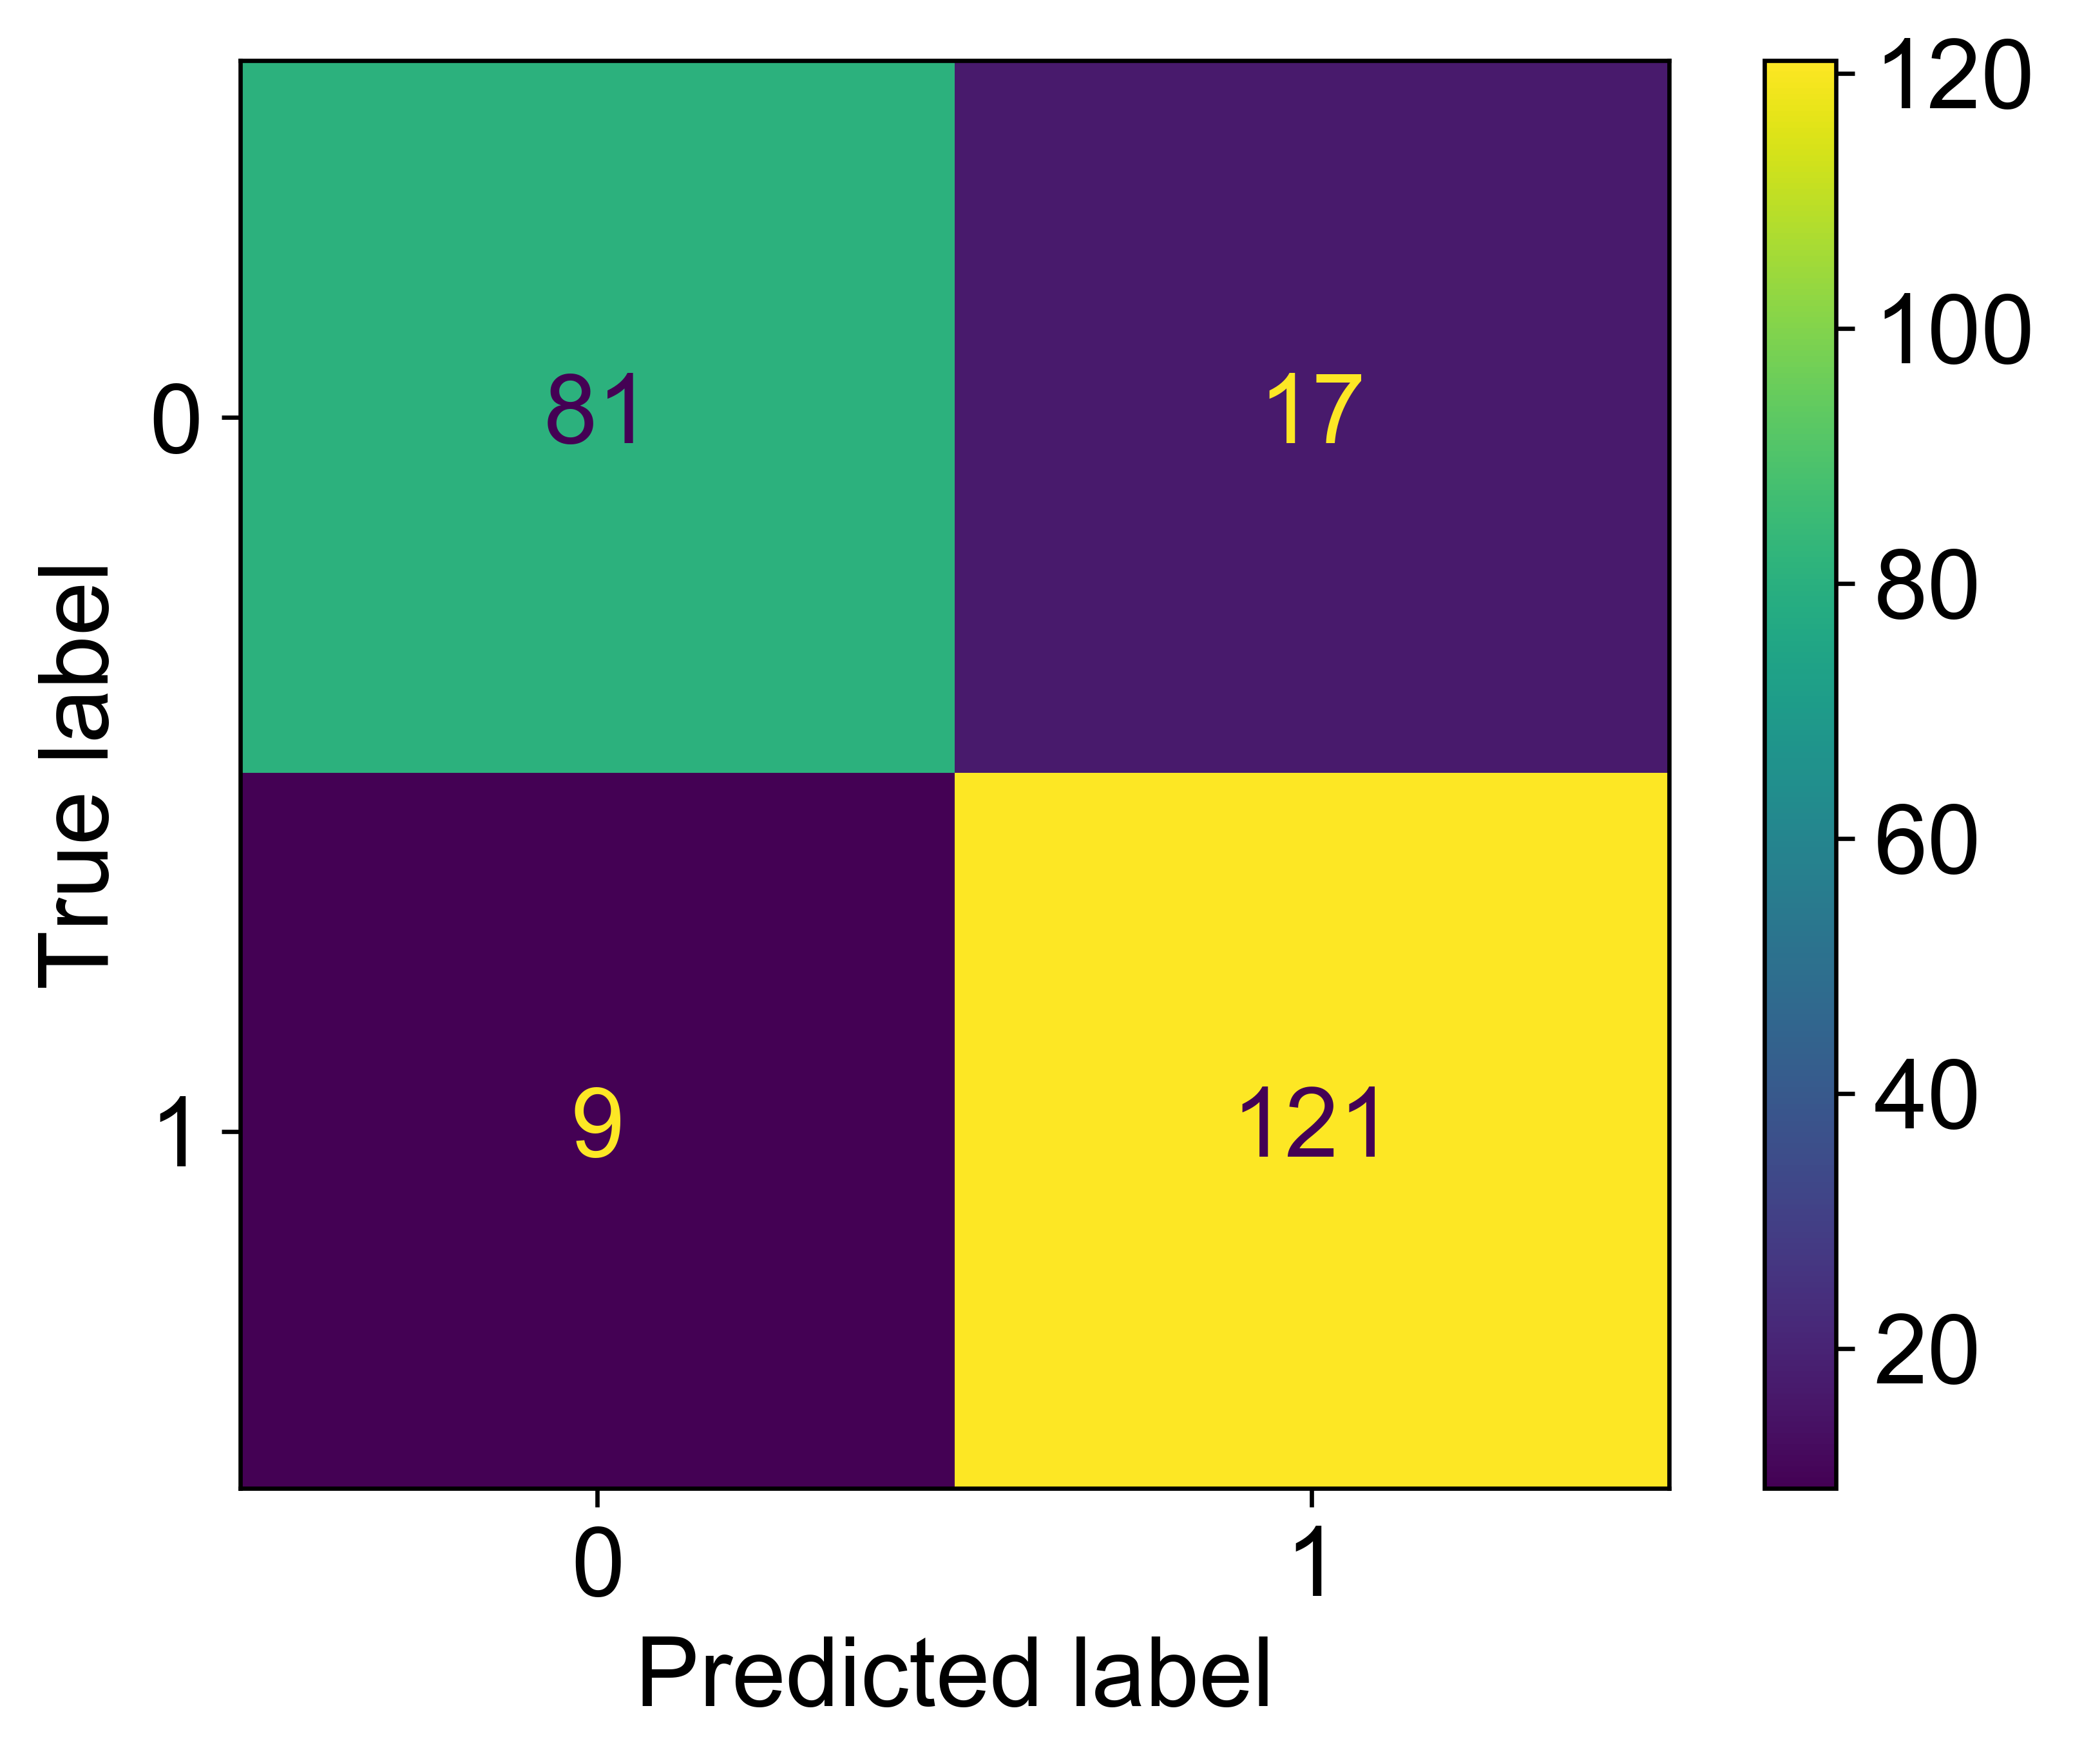

准确度：0.8859649122807017
灵敏度：0.9307692307692308
特异度：0.826530612244898
MCC: 0.7669936755550271
内部验证accuracy：0.886
内部验证precision：0.877
内部验证recall：0.931
内部验证f1-score：0.903


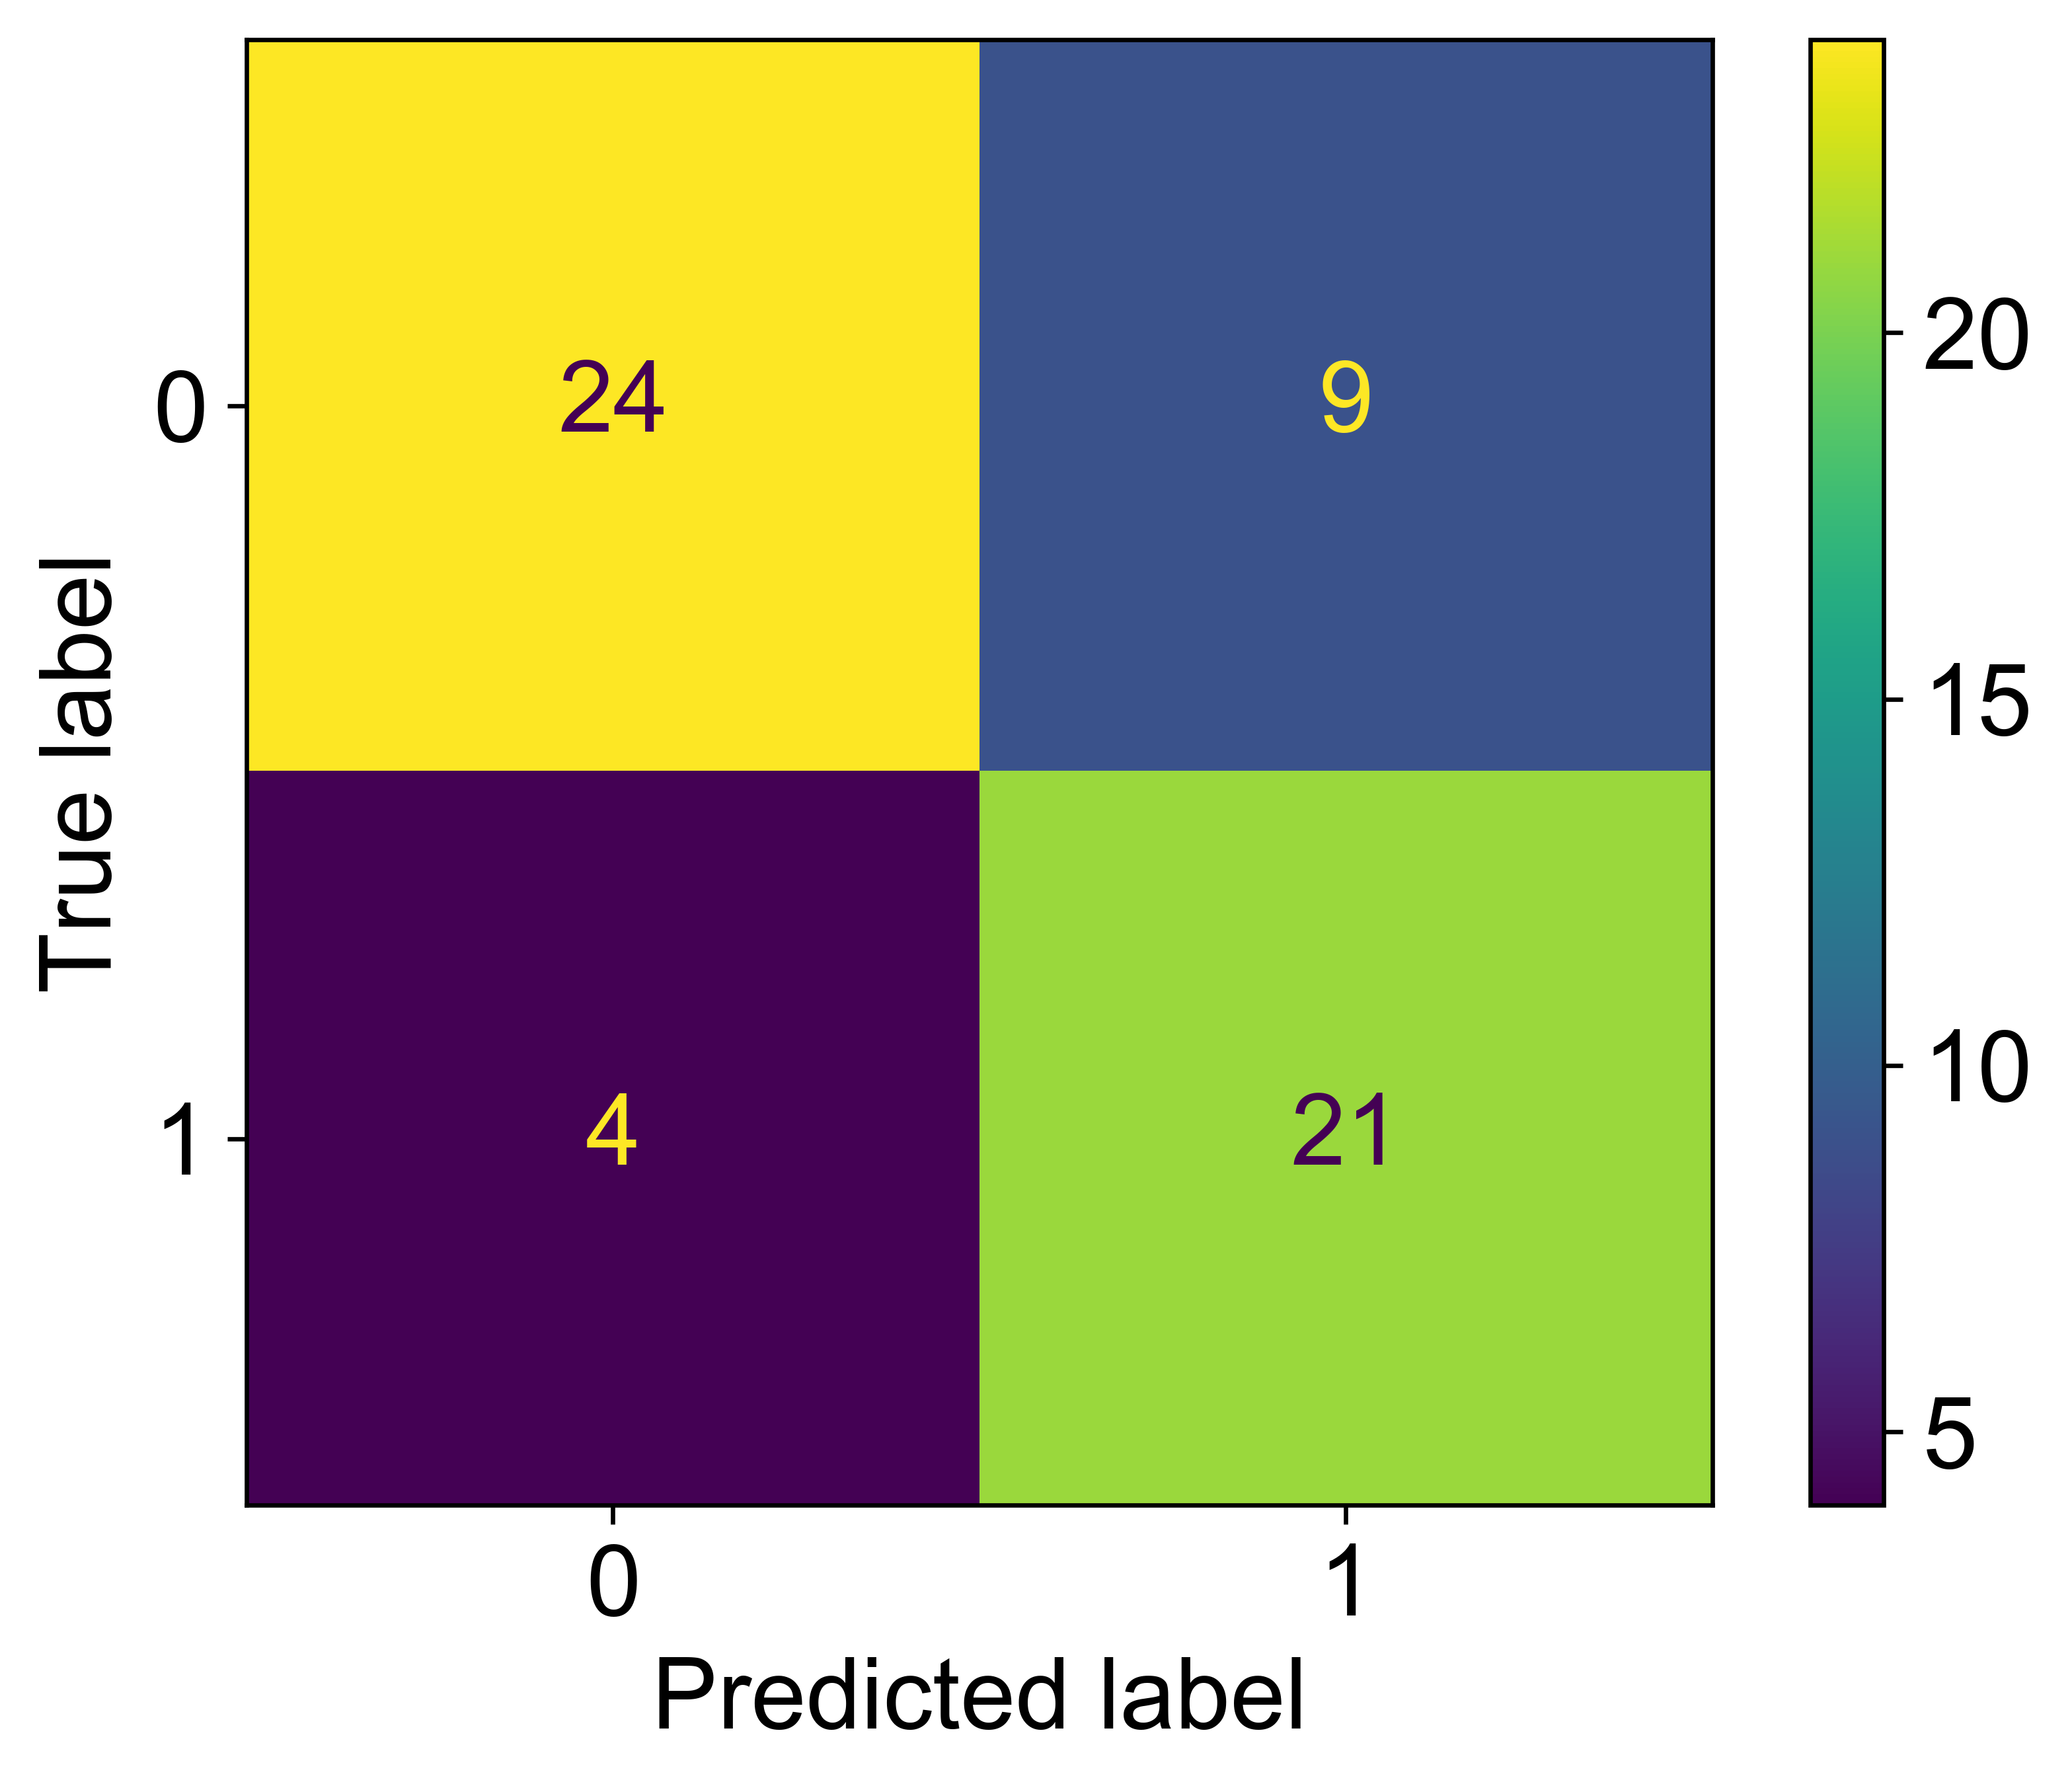

准确度：0.7758620689655172
灵敏度：0.84
特异度：0.7272727272727273
MCC: 0.5621849767220288


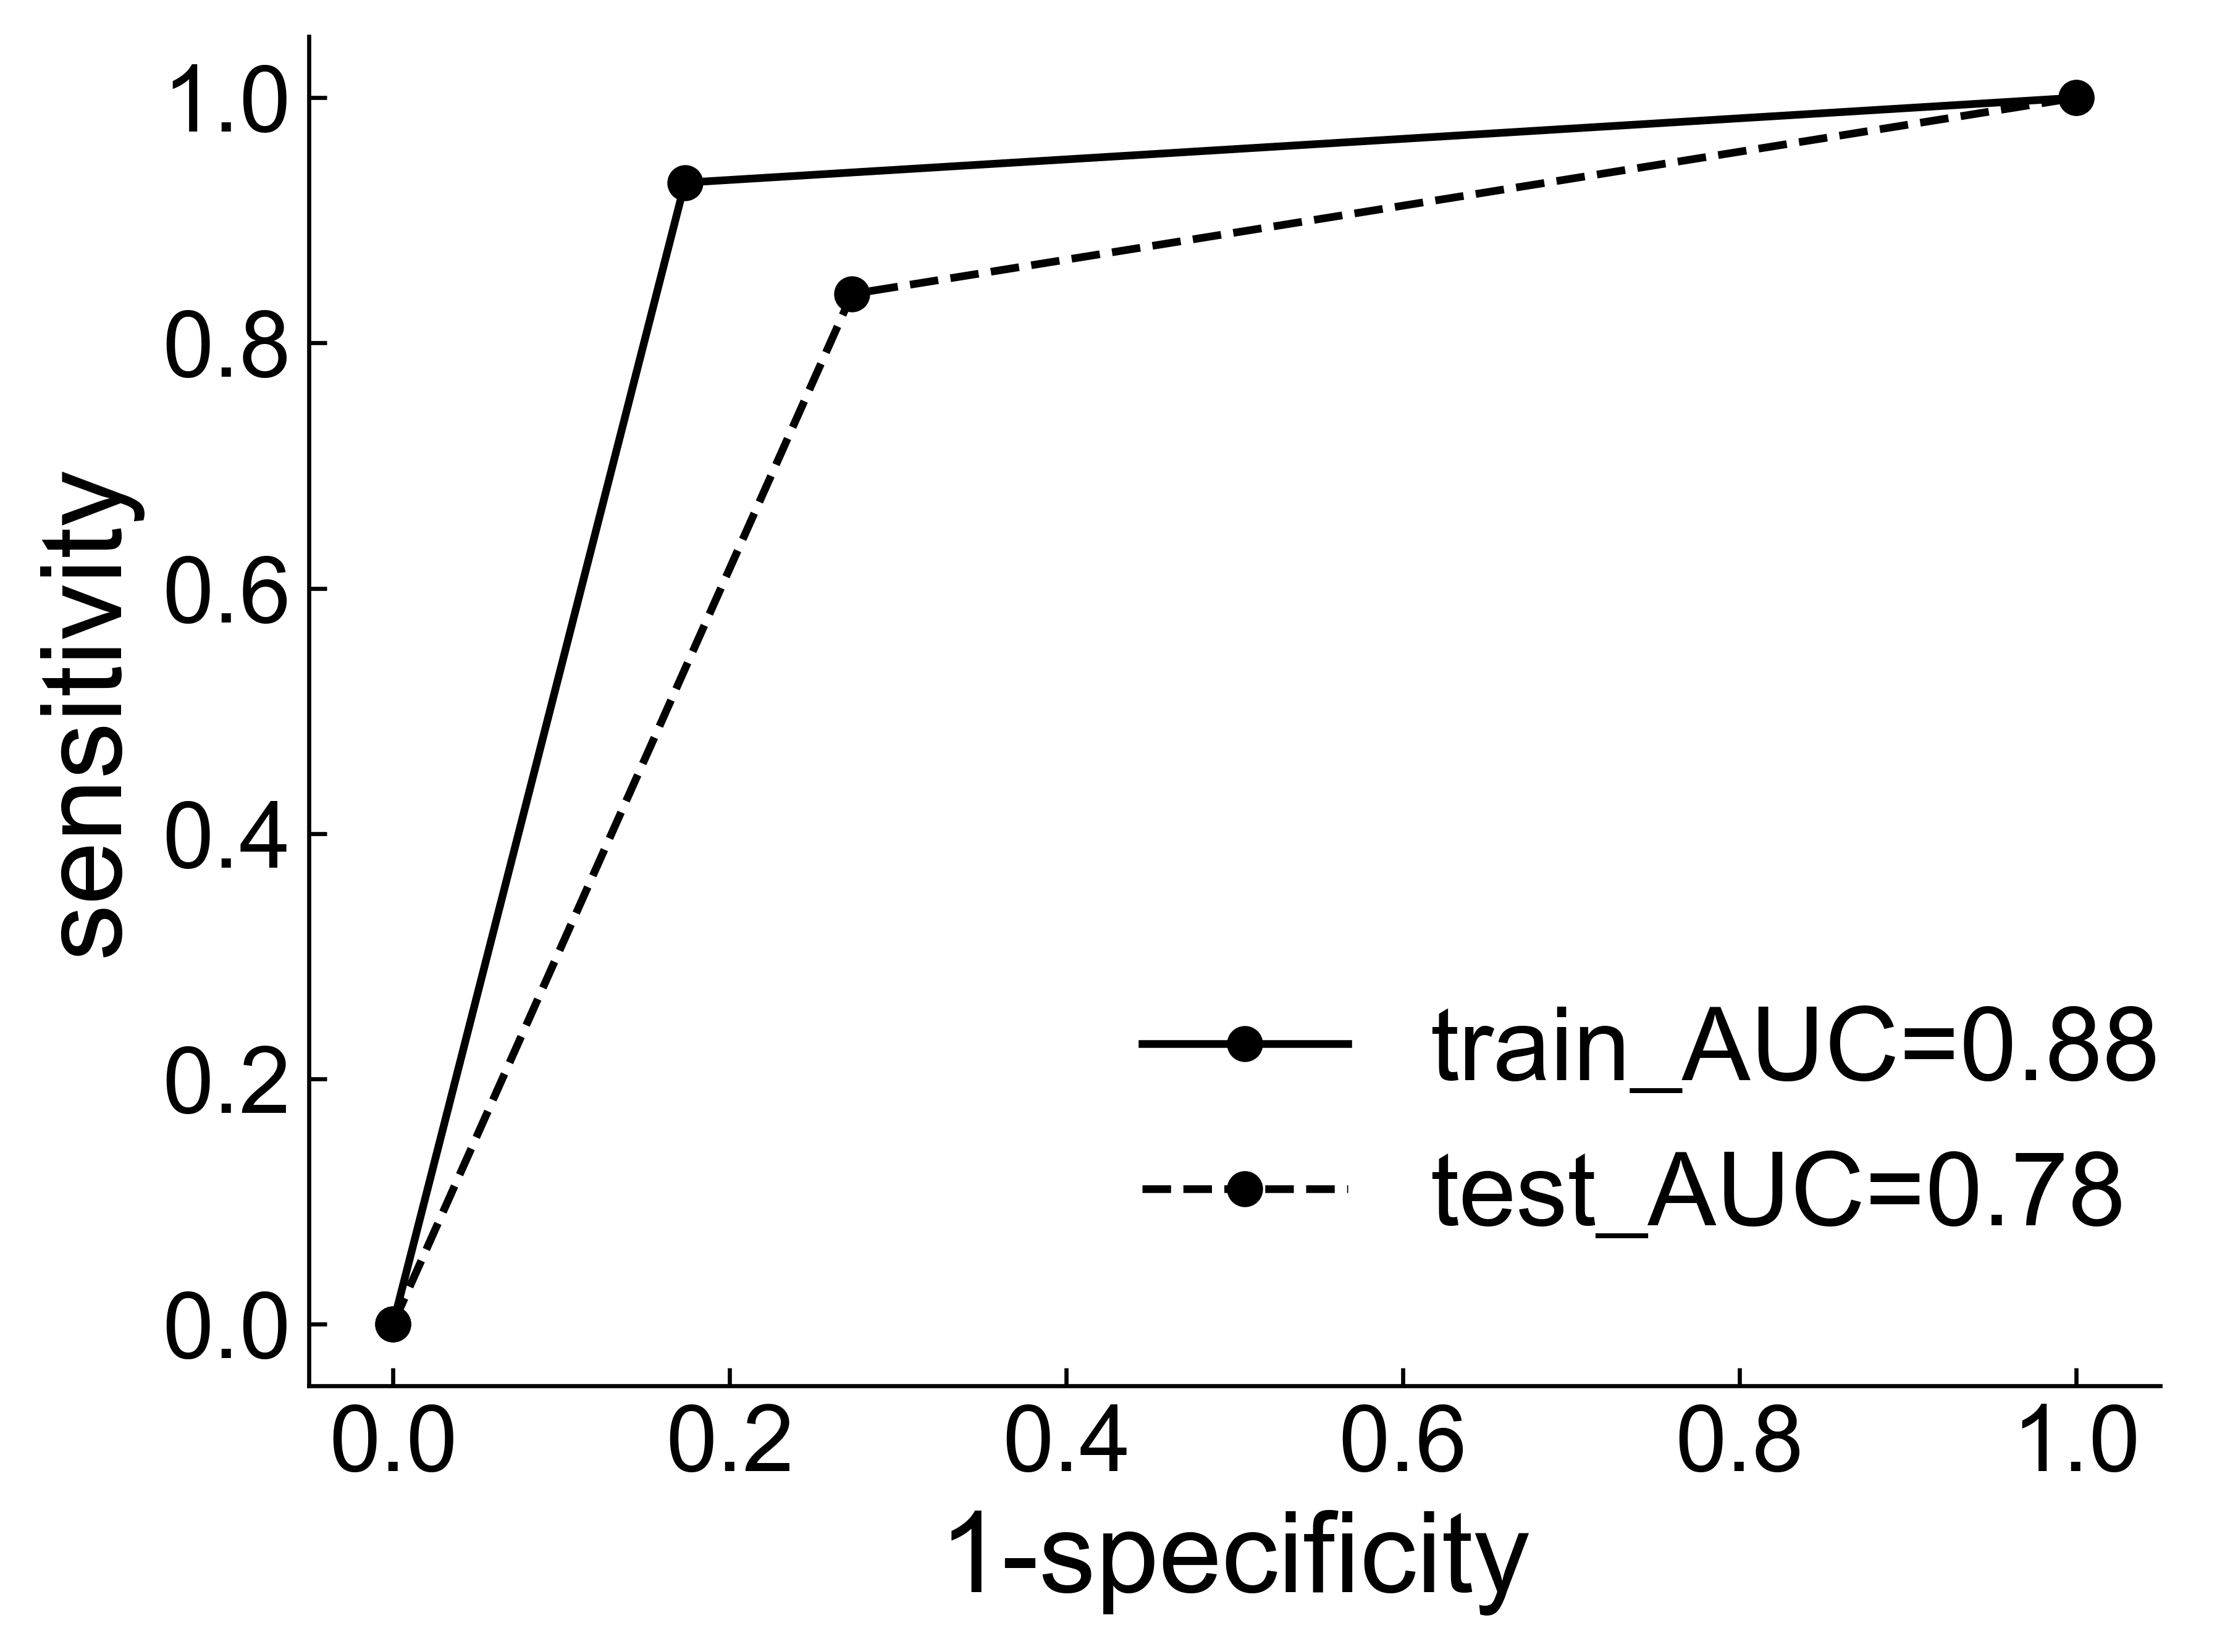

外部验证accuracy：0.776
外部验证precision：0.700
外部验证recall：0.840
外部验证f1-score：0.764


In [17]:
# 1. 定义目标函数
def objective(params):
    model = RandomForestClassifier(**params)
    loss = 1 - cv_scores.mean()
    return loss

rf_model = RandomForestClassifier( n_estimators=4,max_depth=3,random_state=42) 

cur_tif_name = "C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-随机森林 .tif"

# 训练模型，并进行验证
rf_model.fit(X_train, Y_train)

# 交叉验证代码
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_train, Y_train, cv=5)

# 分别进行内部验证和外部验证
train_predictions = rf_model.predict(X_train)
acc, p, r, f1, FPR, TPR, AUC = evaluate_model(Y_train, train_predictions)
print("内部验证accuracy：{:.3f}".format(acc))
print("内部验证precision：{:.3f}".format(p))
print("内部验证recall：{:.3f}".format(r))
print("内部验证f1-score：{:.3f}".format(f1))

test_predictions = rf_model.predict(X_test)
acc, p, r, f1 = evaluate_model(Y_test, test_predictions, FPR, TPR, AUC)
print("外部验证accuracy：{:.3f}".format(acc))
print("外部验证precision：{:.3f}".format(p))
print("外部验证recall：{:.3f}".format(r))
print("外部验证f1-score：{:.3f}".format(f1))

# 保存结果到csv，格式类似数据文件
all_predictions = rf_model.predict(X)
temp_predictions = []
cur_df = deepcopy(df)
length = len(all_predictions)
for i in range(length):
    if all_predictions[i] == 1:
        temp_predictions.append("yes")
    else:
        temp_predictions.append("no")
cur_df["Y"] = temp_predictions
cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-随机森林.csv", index=False)

4、梯度提升树

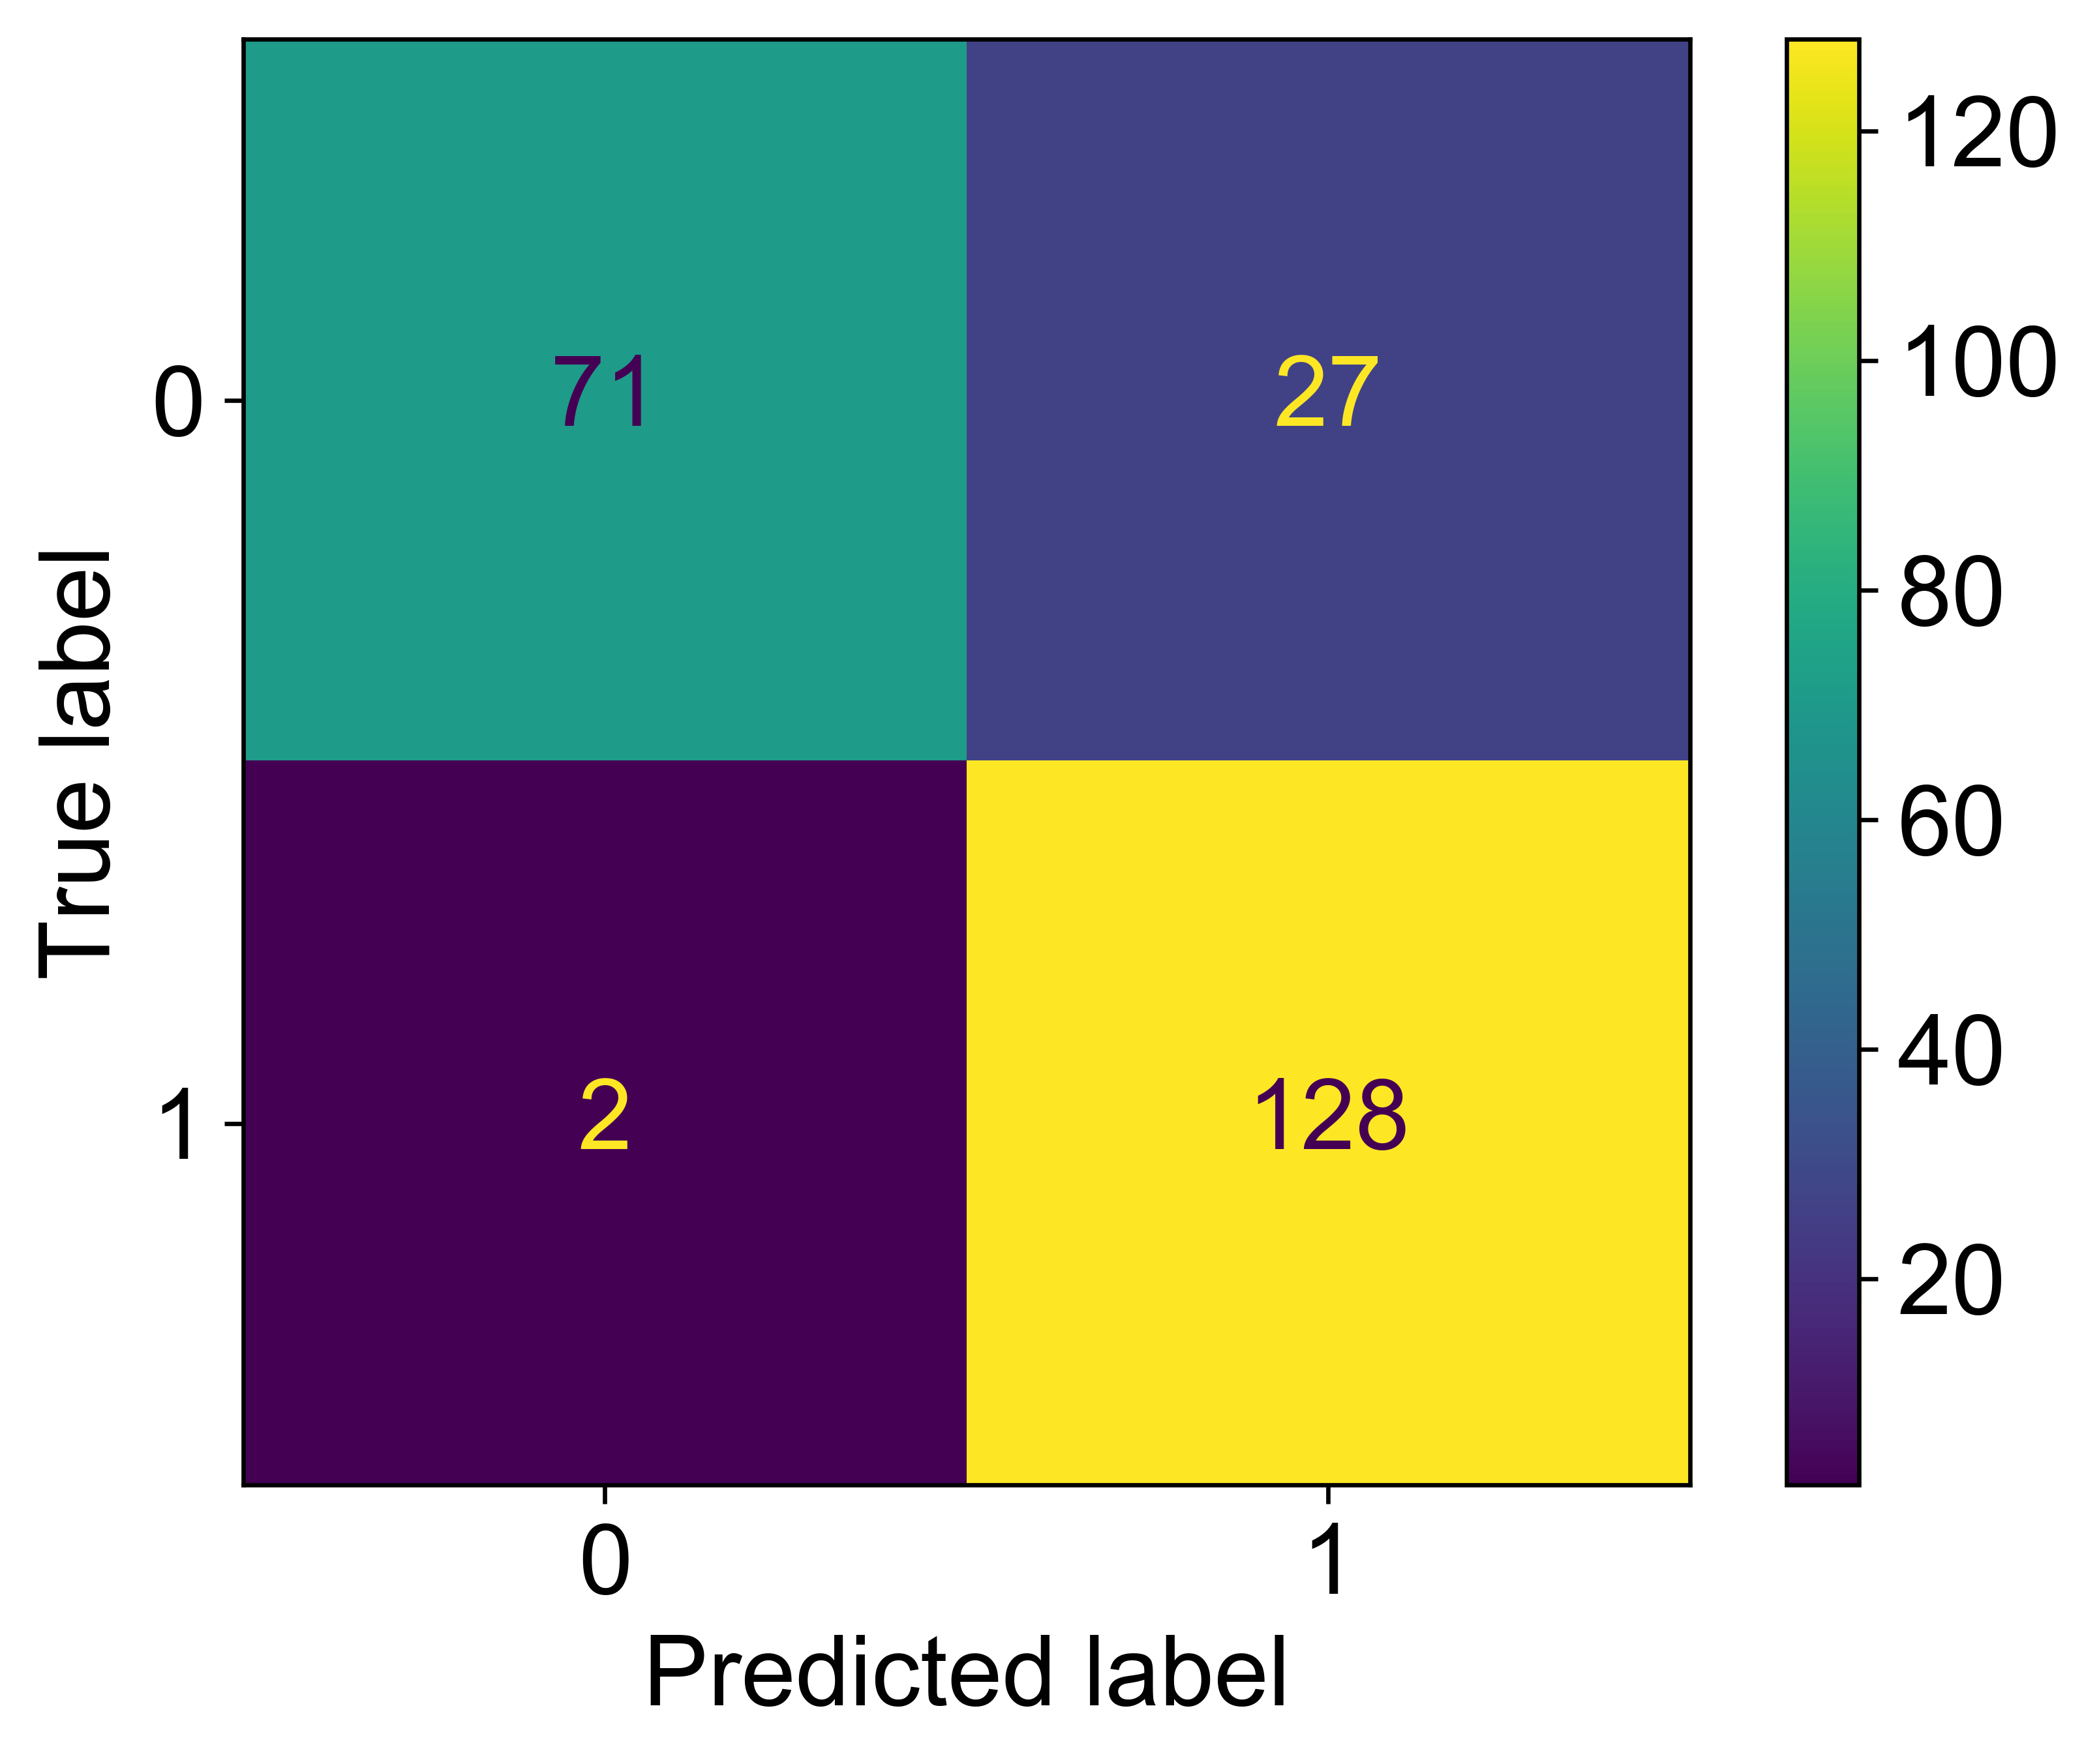

准确度：0.8728070175438597
灵敏度：0.9846153846153847
特异度：0.7244897959183674
MCC: 0.7524334480631488
内部验证accuracy：0.873
内部验证precision：0.826
内部验证recall：0.985
内部验证f1-score：0.898


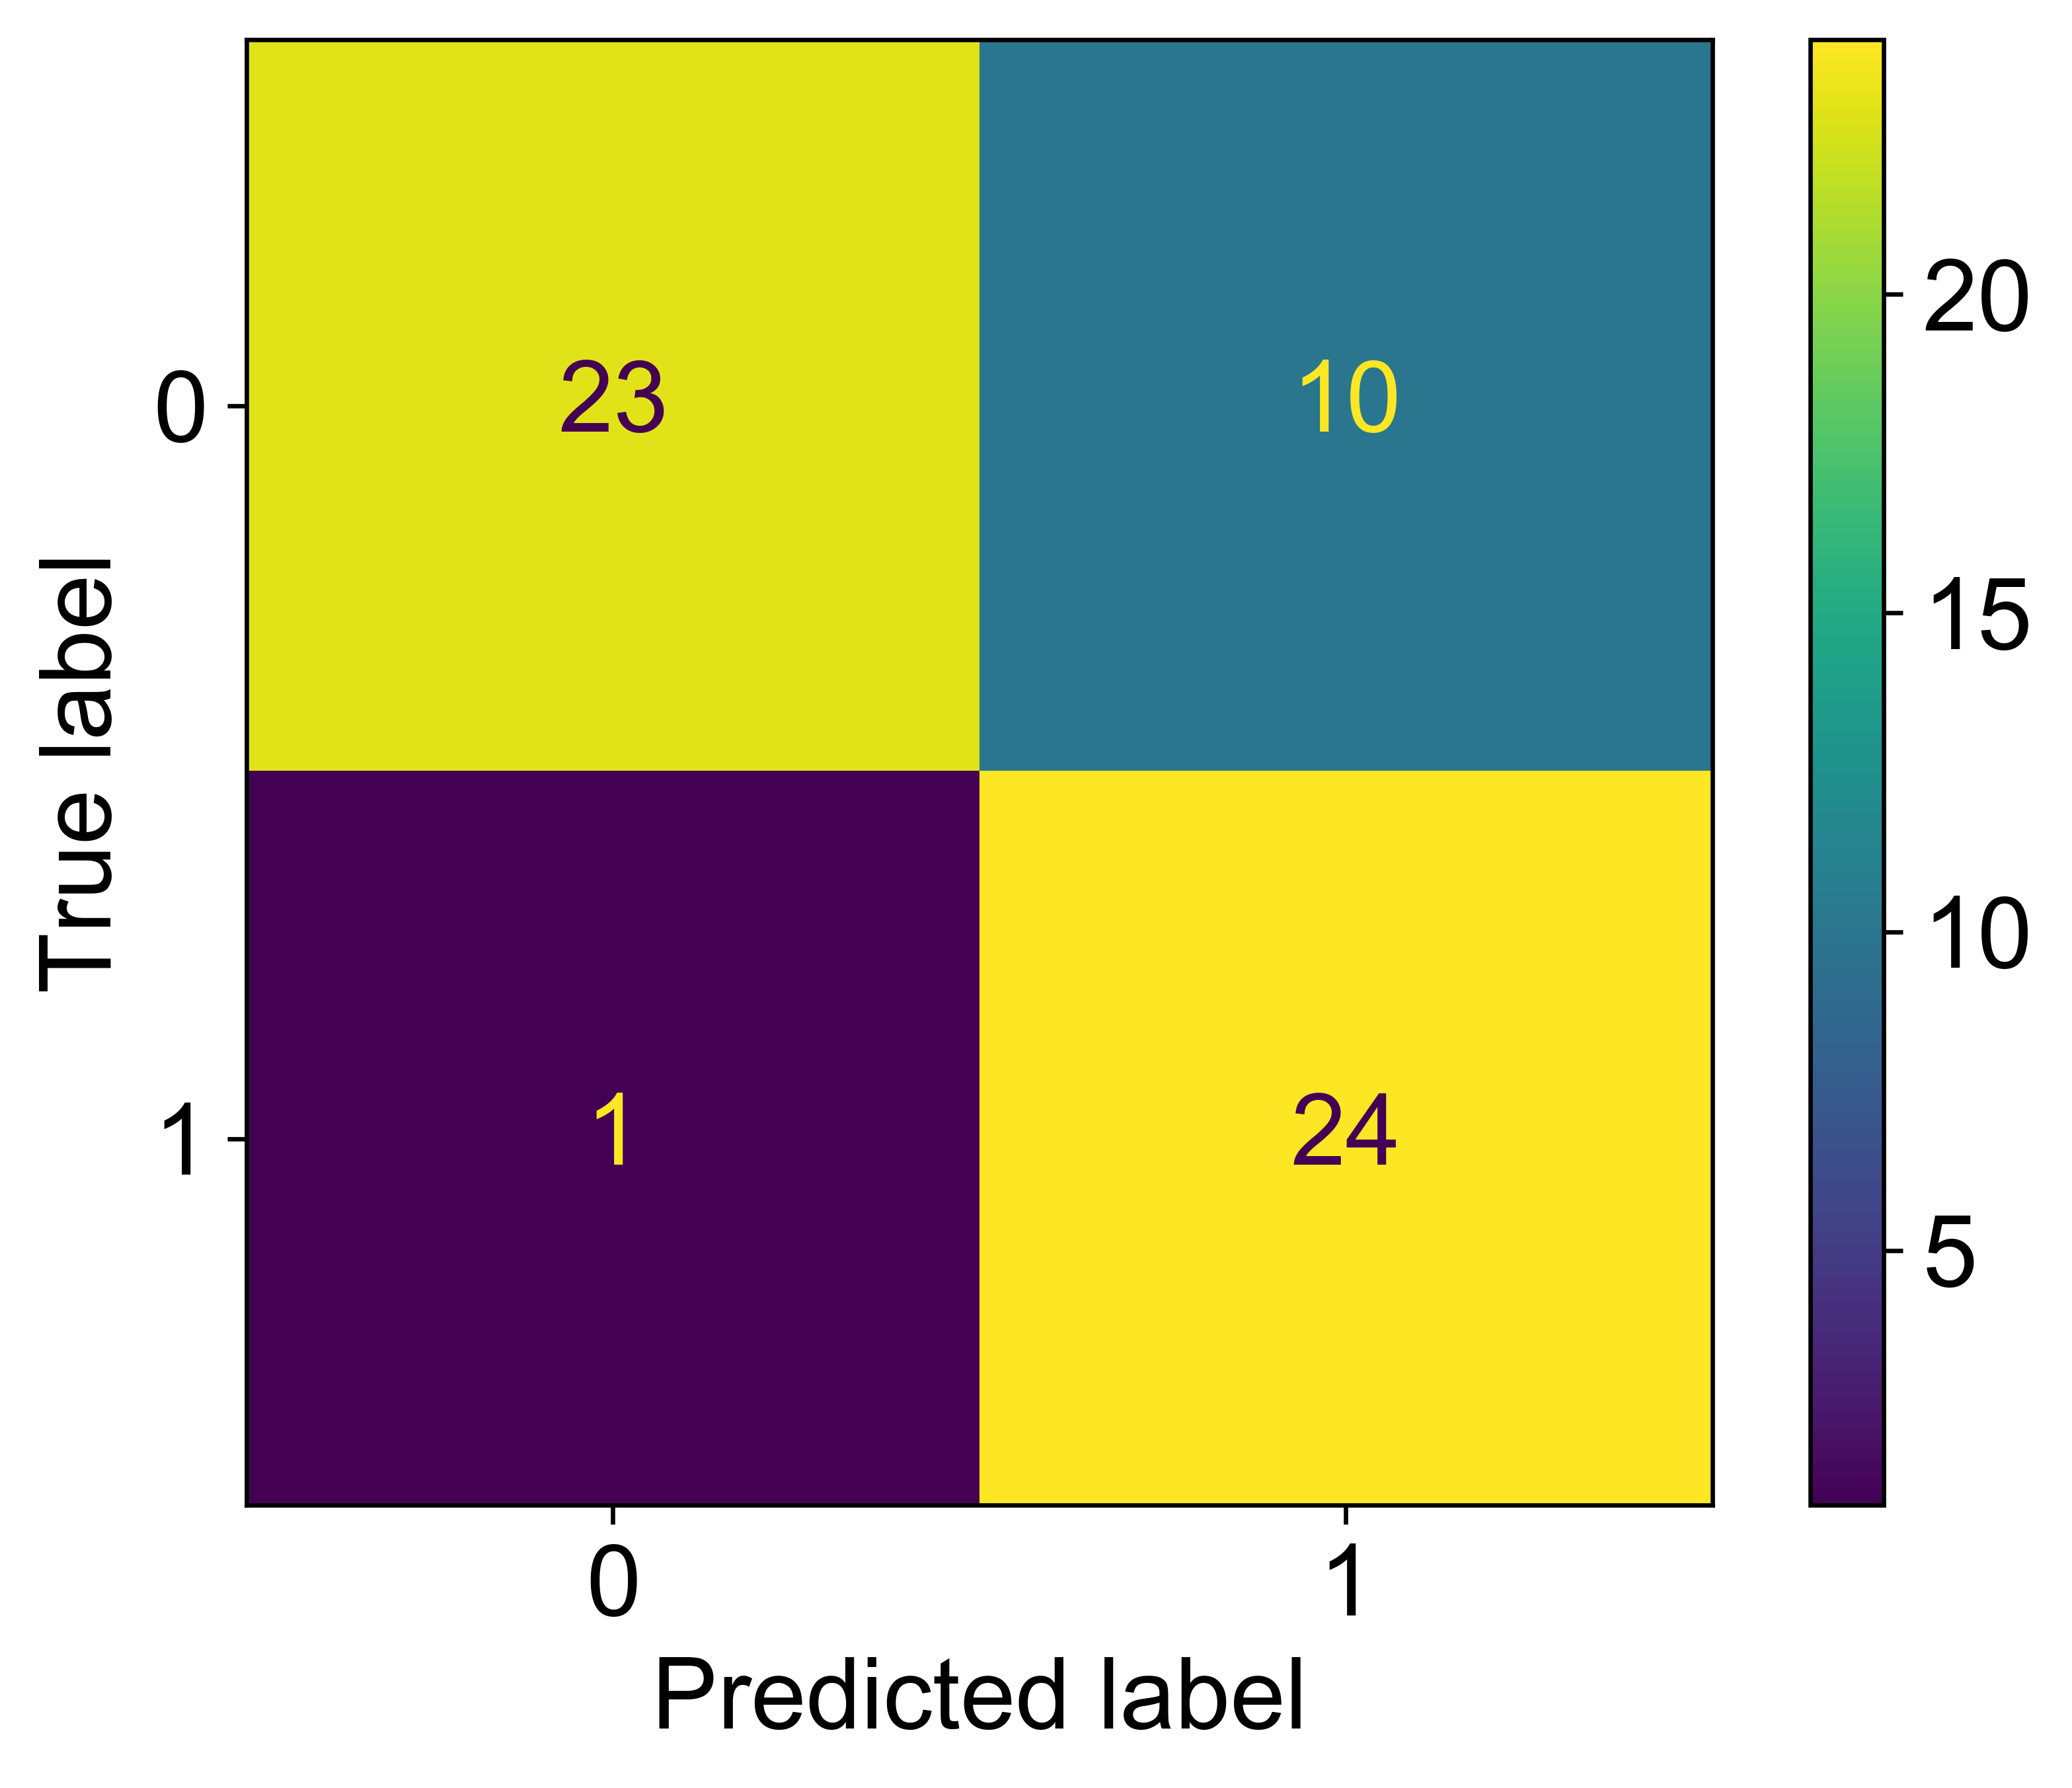

准确度：0.8103448275862069
灵敏度：0.96
特异度：0.696969696969697
MCC: 0.660582756461508


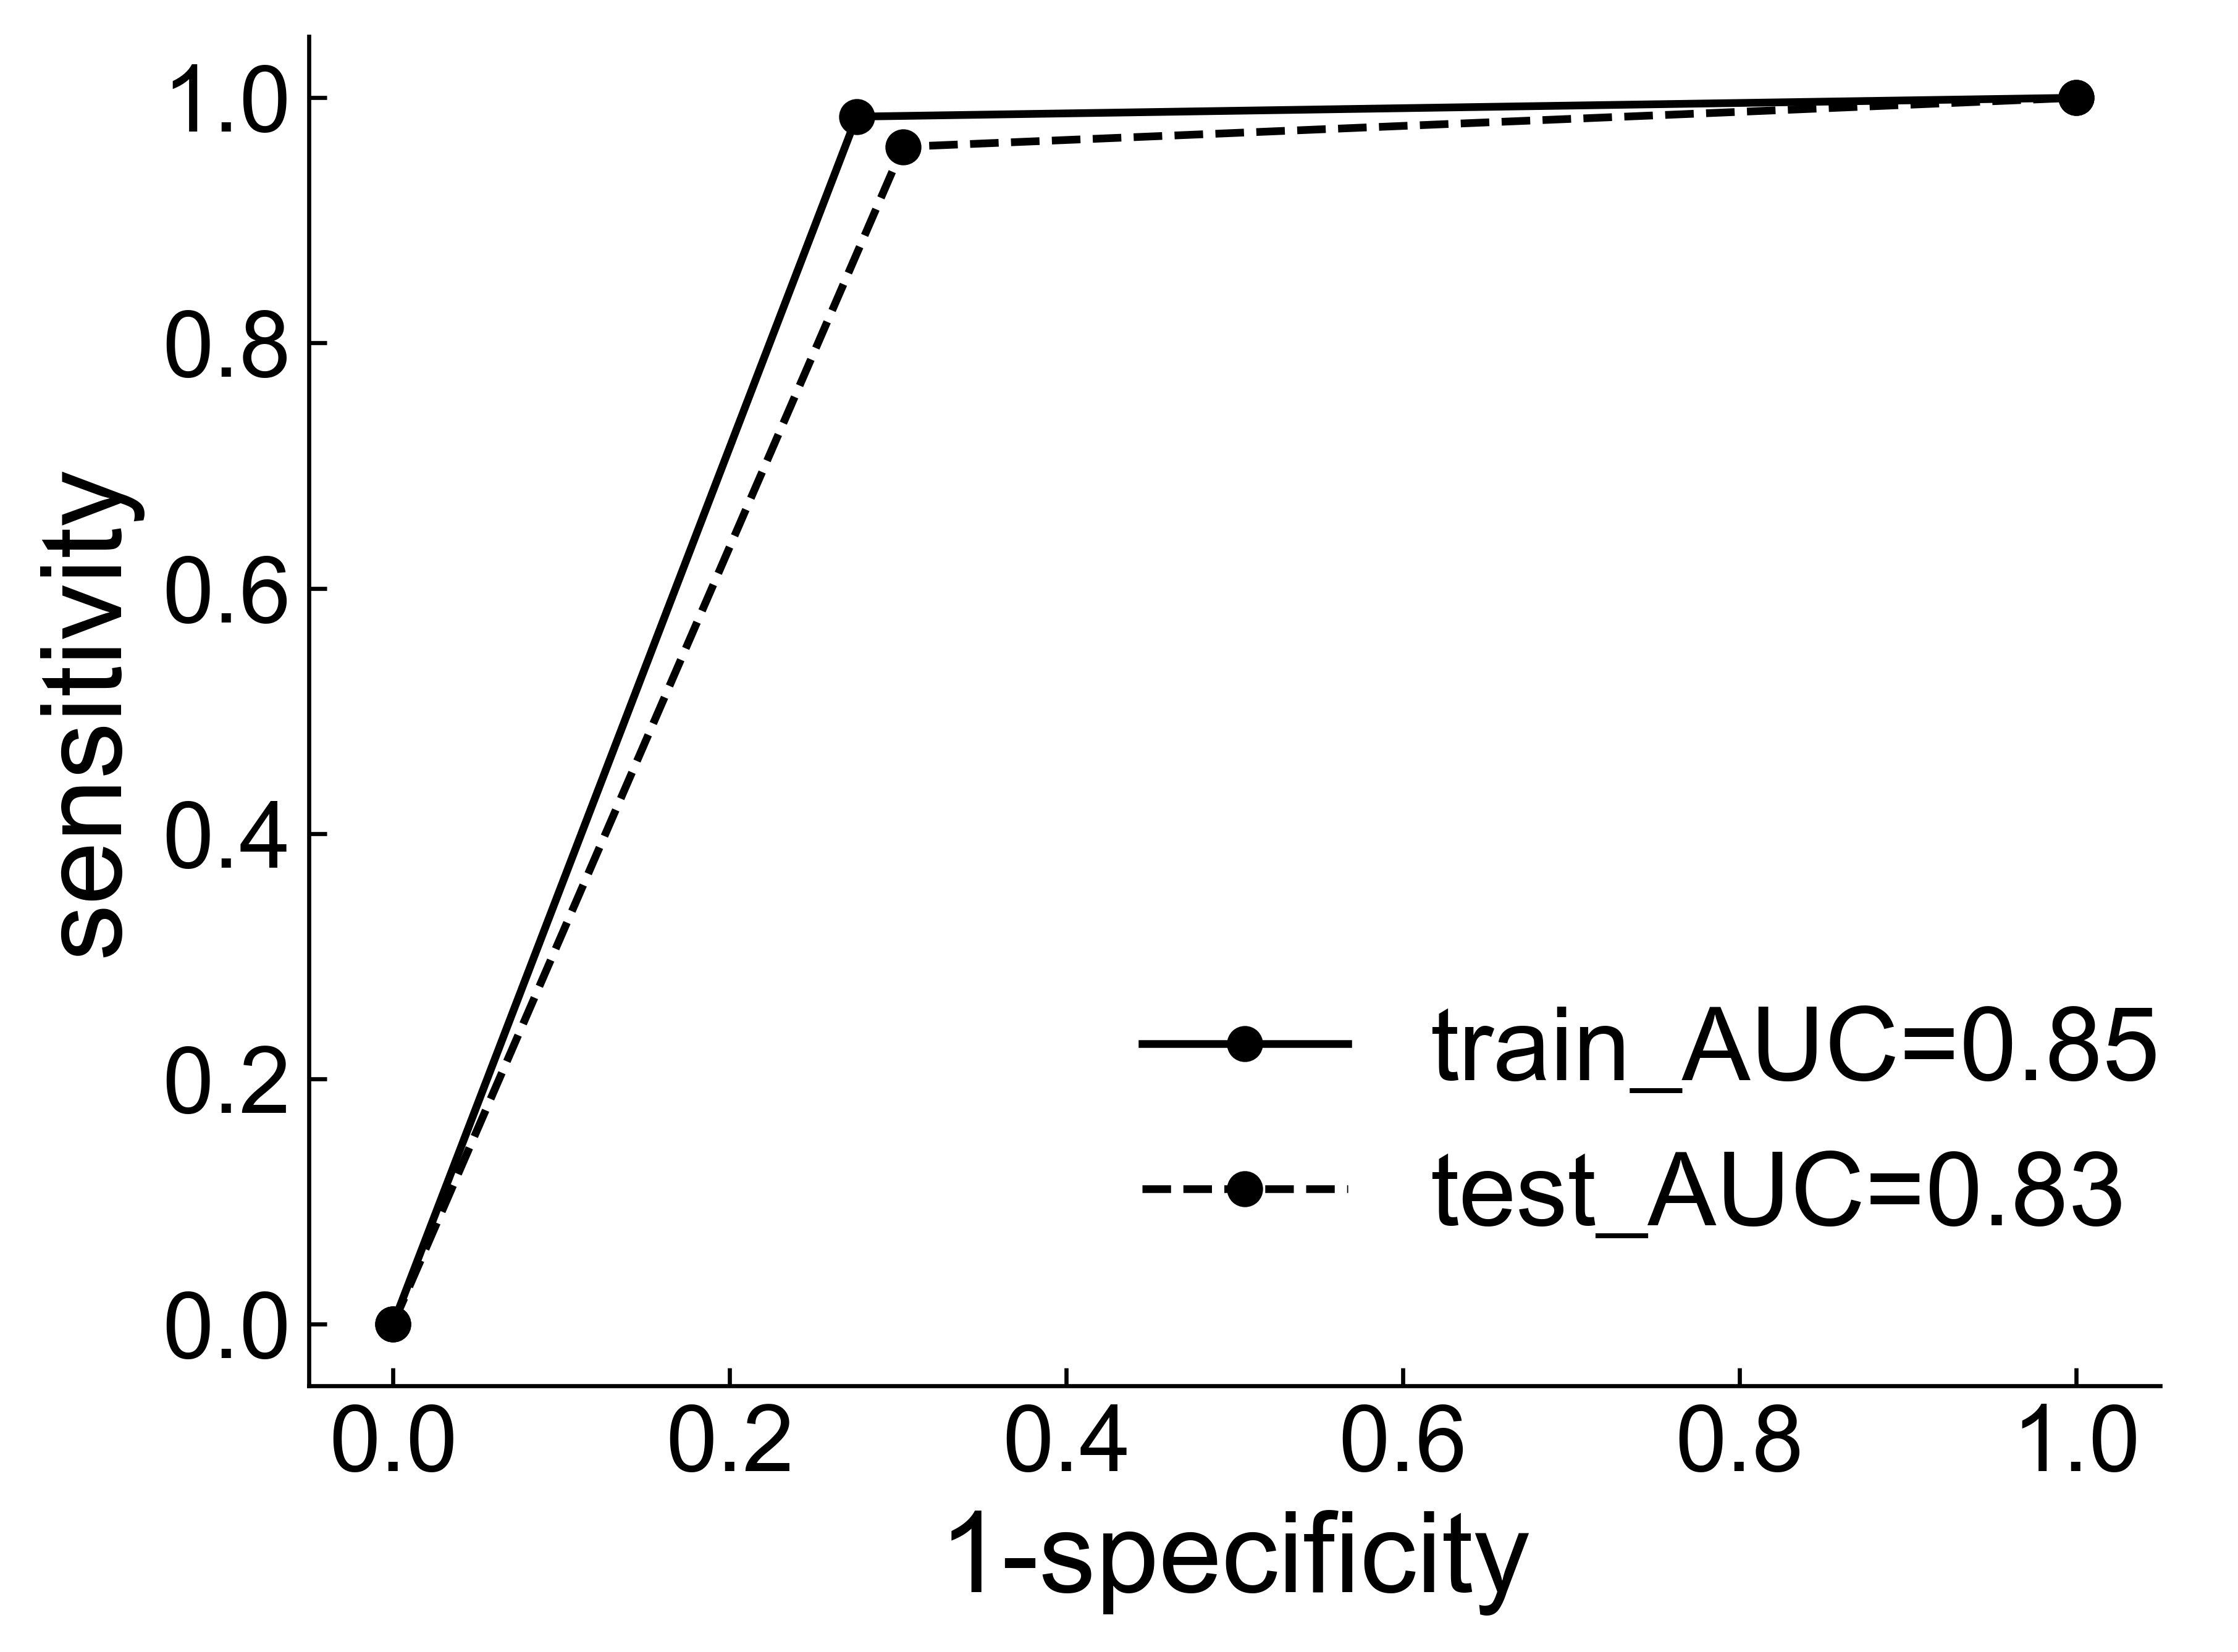

外部验证accuracy：0.810
外部验证precision：0.706
外部验证recall：0.960
外部验证f1-score：0.814


In [29]:
# 1. 定义目标函数
def objective(params):
    model = GradientBoostingClassifier(**params)
    loss = 1 - cv_scores.mean()
    return loss


# 创建模型
gbdt_model = GradientBoostingClassifier(max_depth=2,n_estimators=5,random_state=42)#3 
                                    
cur_tif_name = "C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-梯度提升树.tif"
                                       
# 训练模型，并进行验证
gbdt_model.fit(X_train, Y_train)

# 交叉验证代码
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbdt_model, X_train, Y_train, cv=10)

# 分别进行内部验证和外部验证
train_predictions = gbdt_model.predict(X_train)
acc, p, r, f1, FPR, TPR, AUC = evaluate_model(Y_train, train_predictions)
print("内部验证accuracy：{:.3f}".format(acc))
print("内部验证precision：{:.3f}".format(p))
print("内部验证recall：{:.3f}".format(r))
print("内部验证f1-score：{:.3f}".format(f1))

test_predictions = gbdt_model.predict(X_test)
acc, p, r, f1 = evaluate_model(Y_test, test_predictions, FPR, TPR, AUC)
print("外部验证accuracy：{:.3f}".format(acc))
print("外部验证precision：{:.3f}".format(p))
print("外部验证recall：{:.3f}".format(r))
print("外部验证f1-score：{:.3f}".format(f1))

# 保存结果到csv，格式类似数据文件
all_predictions = gbdt_model.predict(X)
temp_predictions = []
cur_df = deepcopy(df)
length = len(all_predictions)
for i in range(length):
    if all_predictions[i] == 1:
        temp_predictions.append("yes")
    else:
        temp_predictions.append("no")
cur_df["Y"] = temp_predictions
cur_df.to_csv("C:/Users/86151/Desktop/machinelearn/ceshi/单一模型-梯度提升树.csv", index=False)

组合模型——投票法

随机森林+XGBoost+mlp


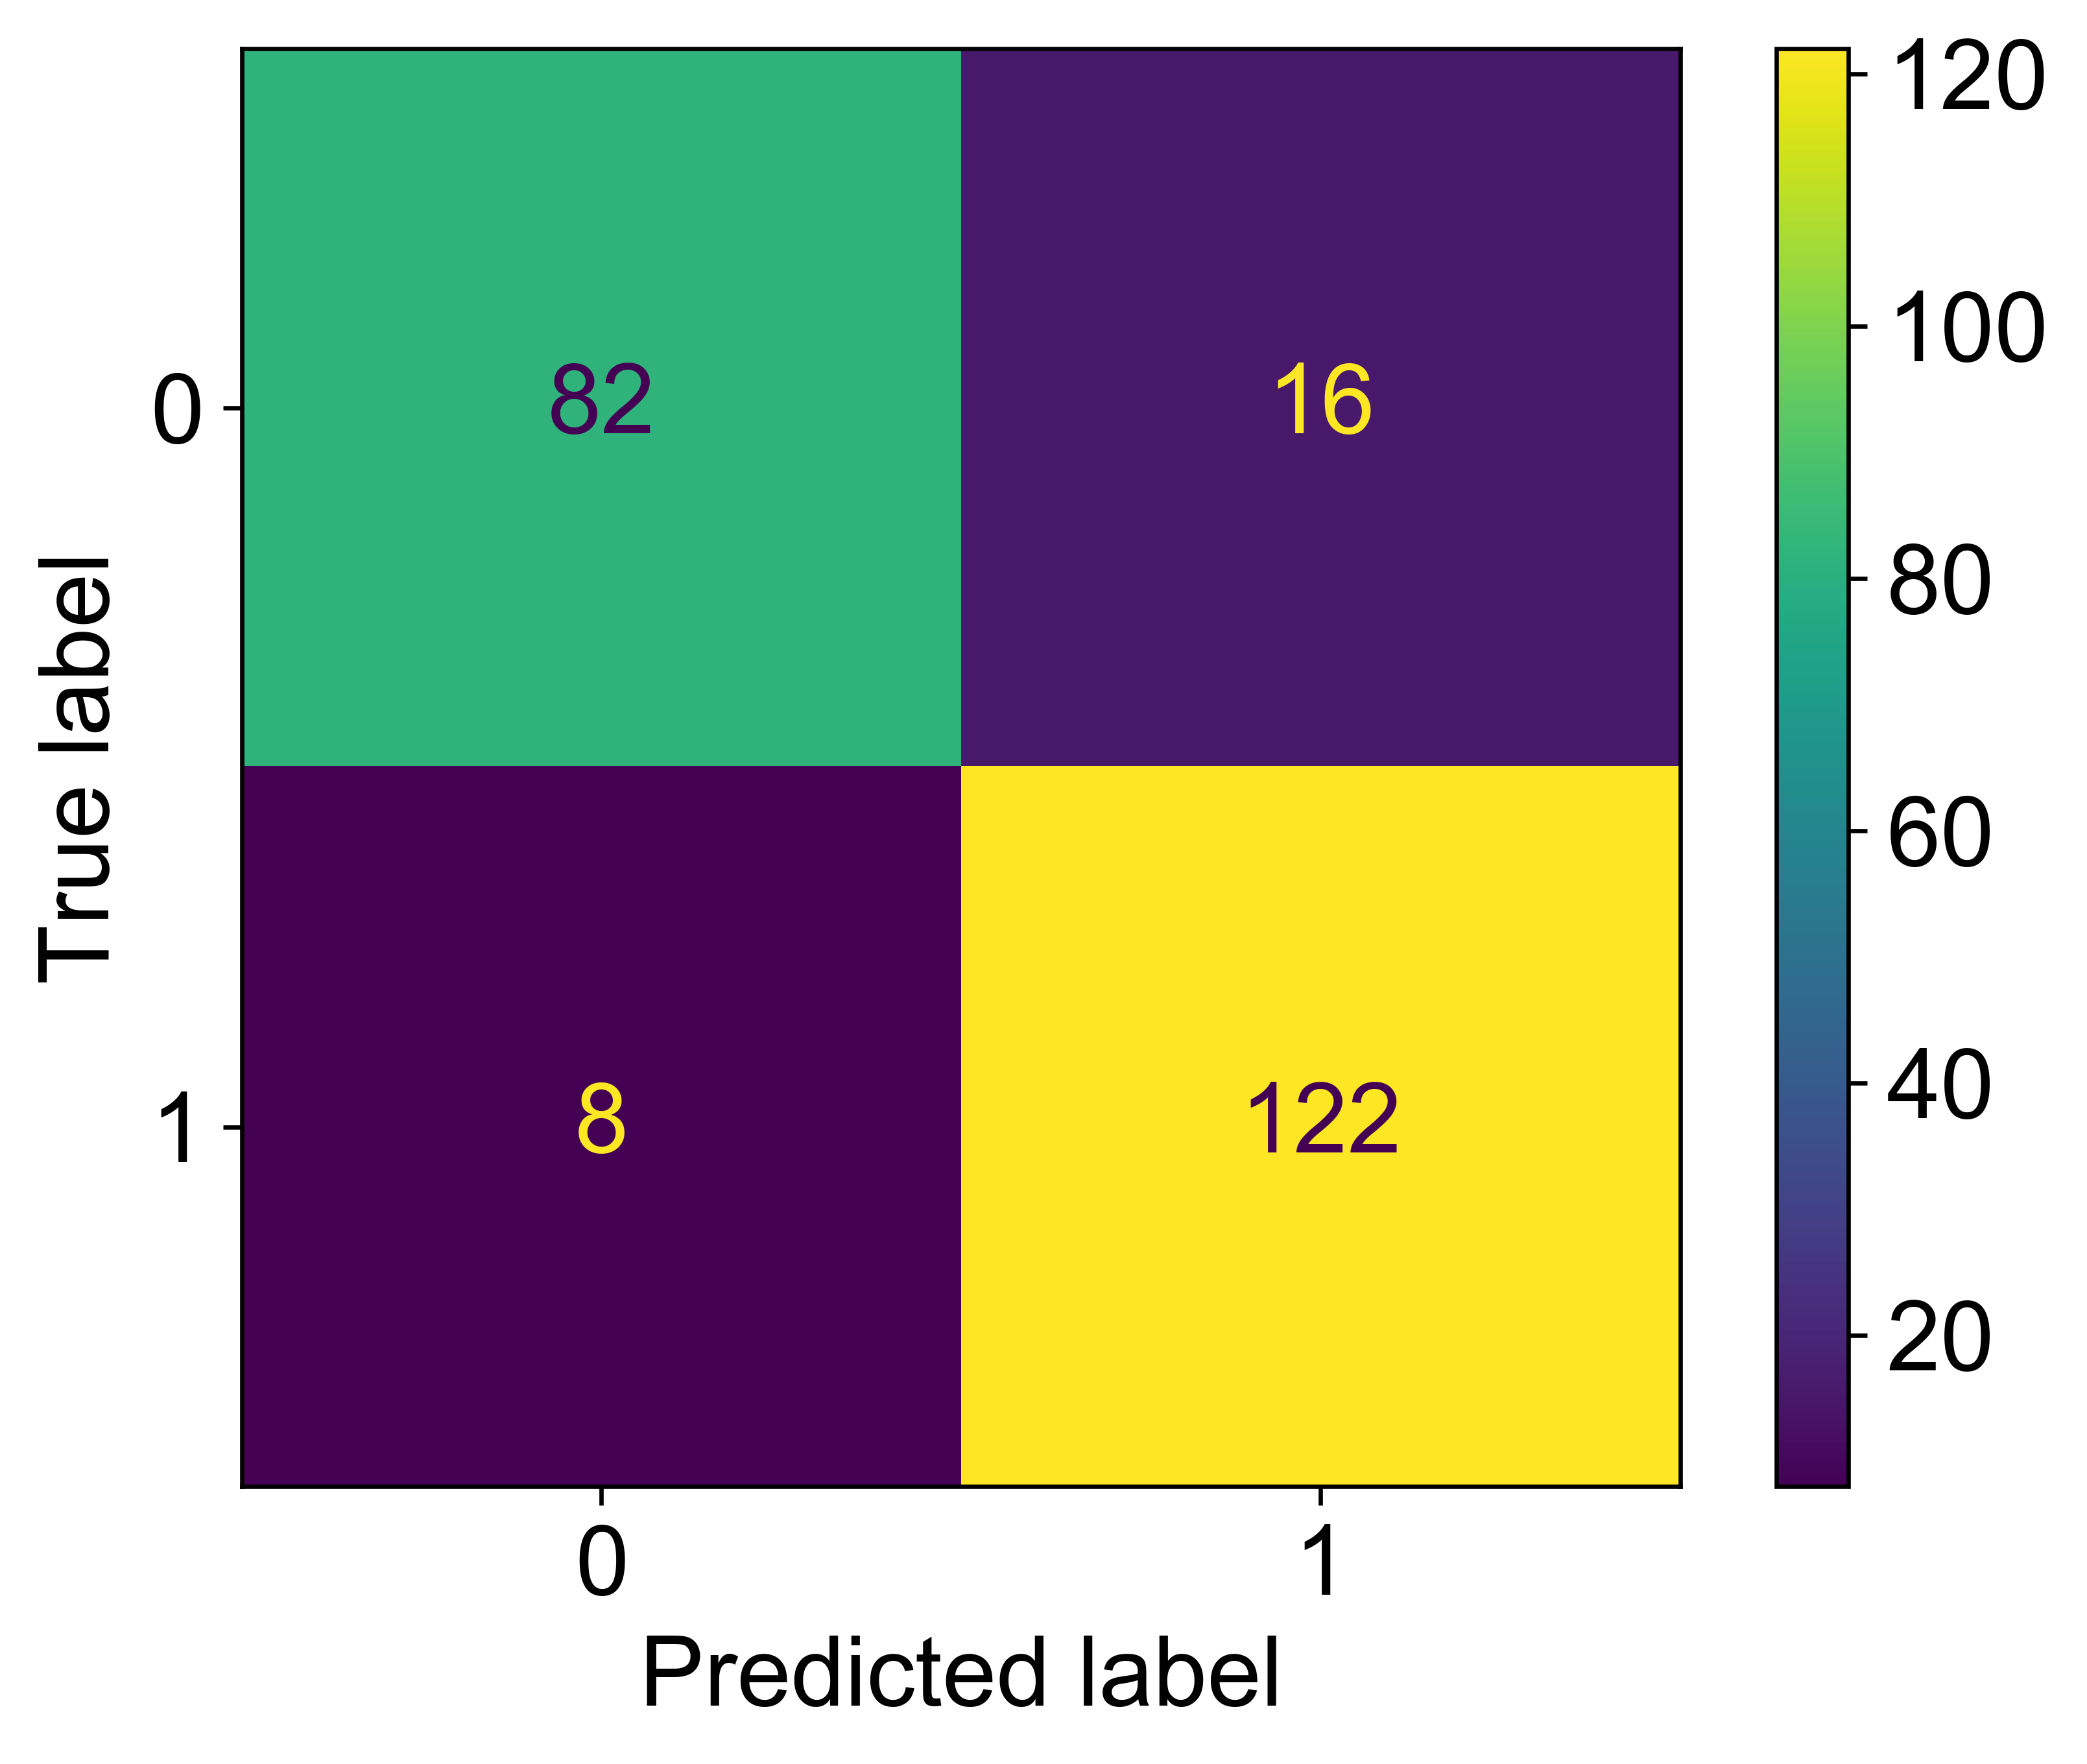

准确度：0.8947368421052632
灵敏度：0.9384615384615385
特异度：0.8367346938775511
MCC: 0.7851191479872976
内部验证accuracy：0.895
内部验证precision：0.884
内部验证recall：0.938
内部验证f1-score：0.910


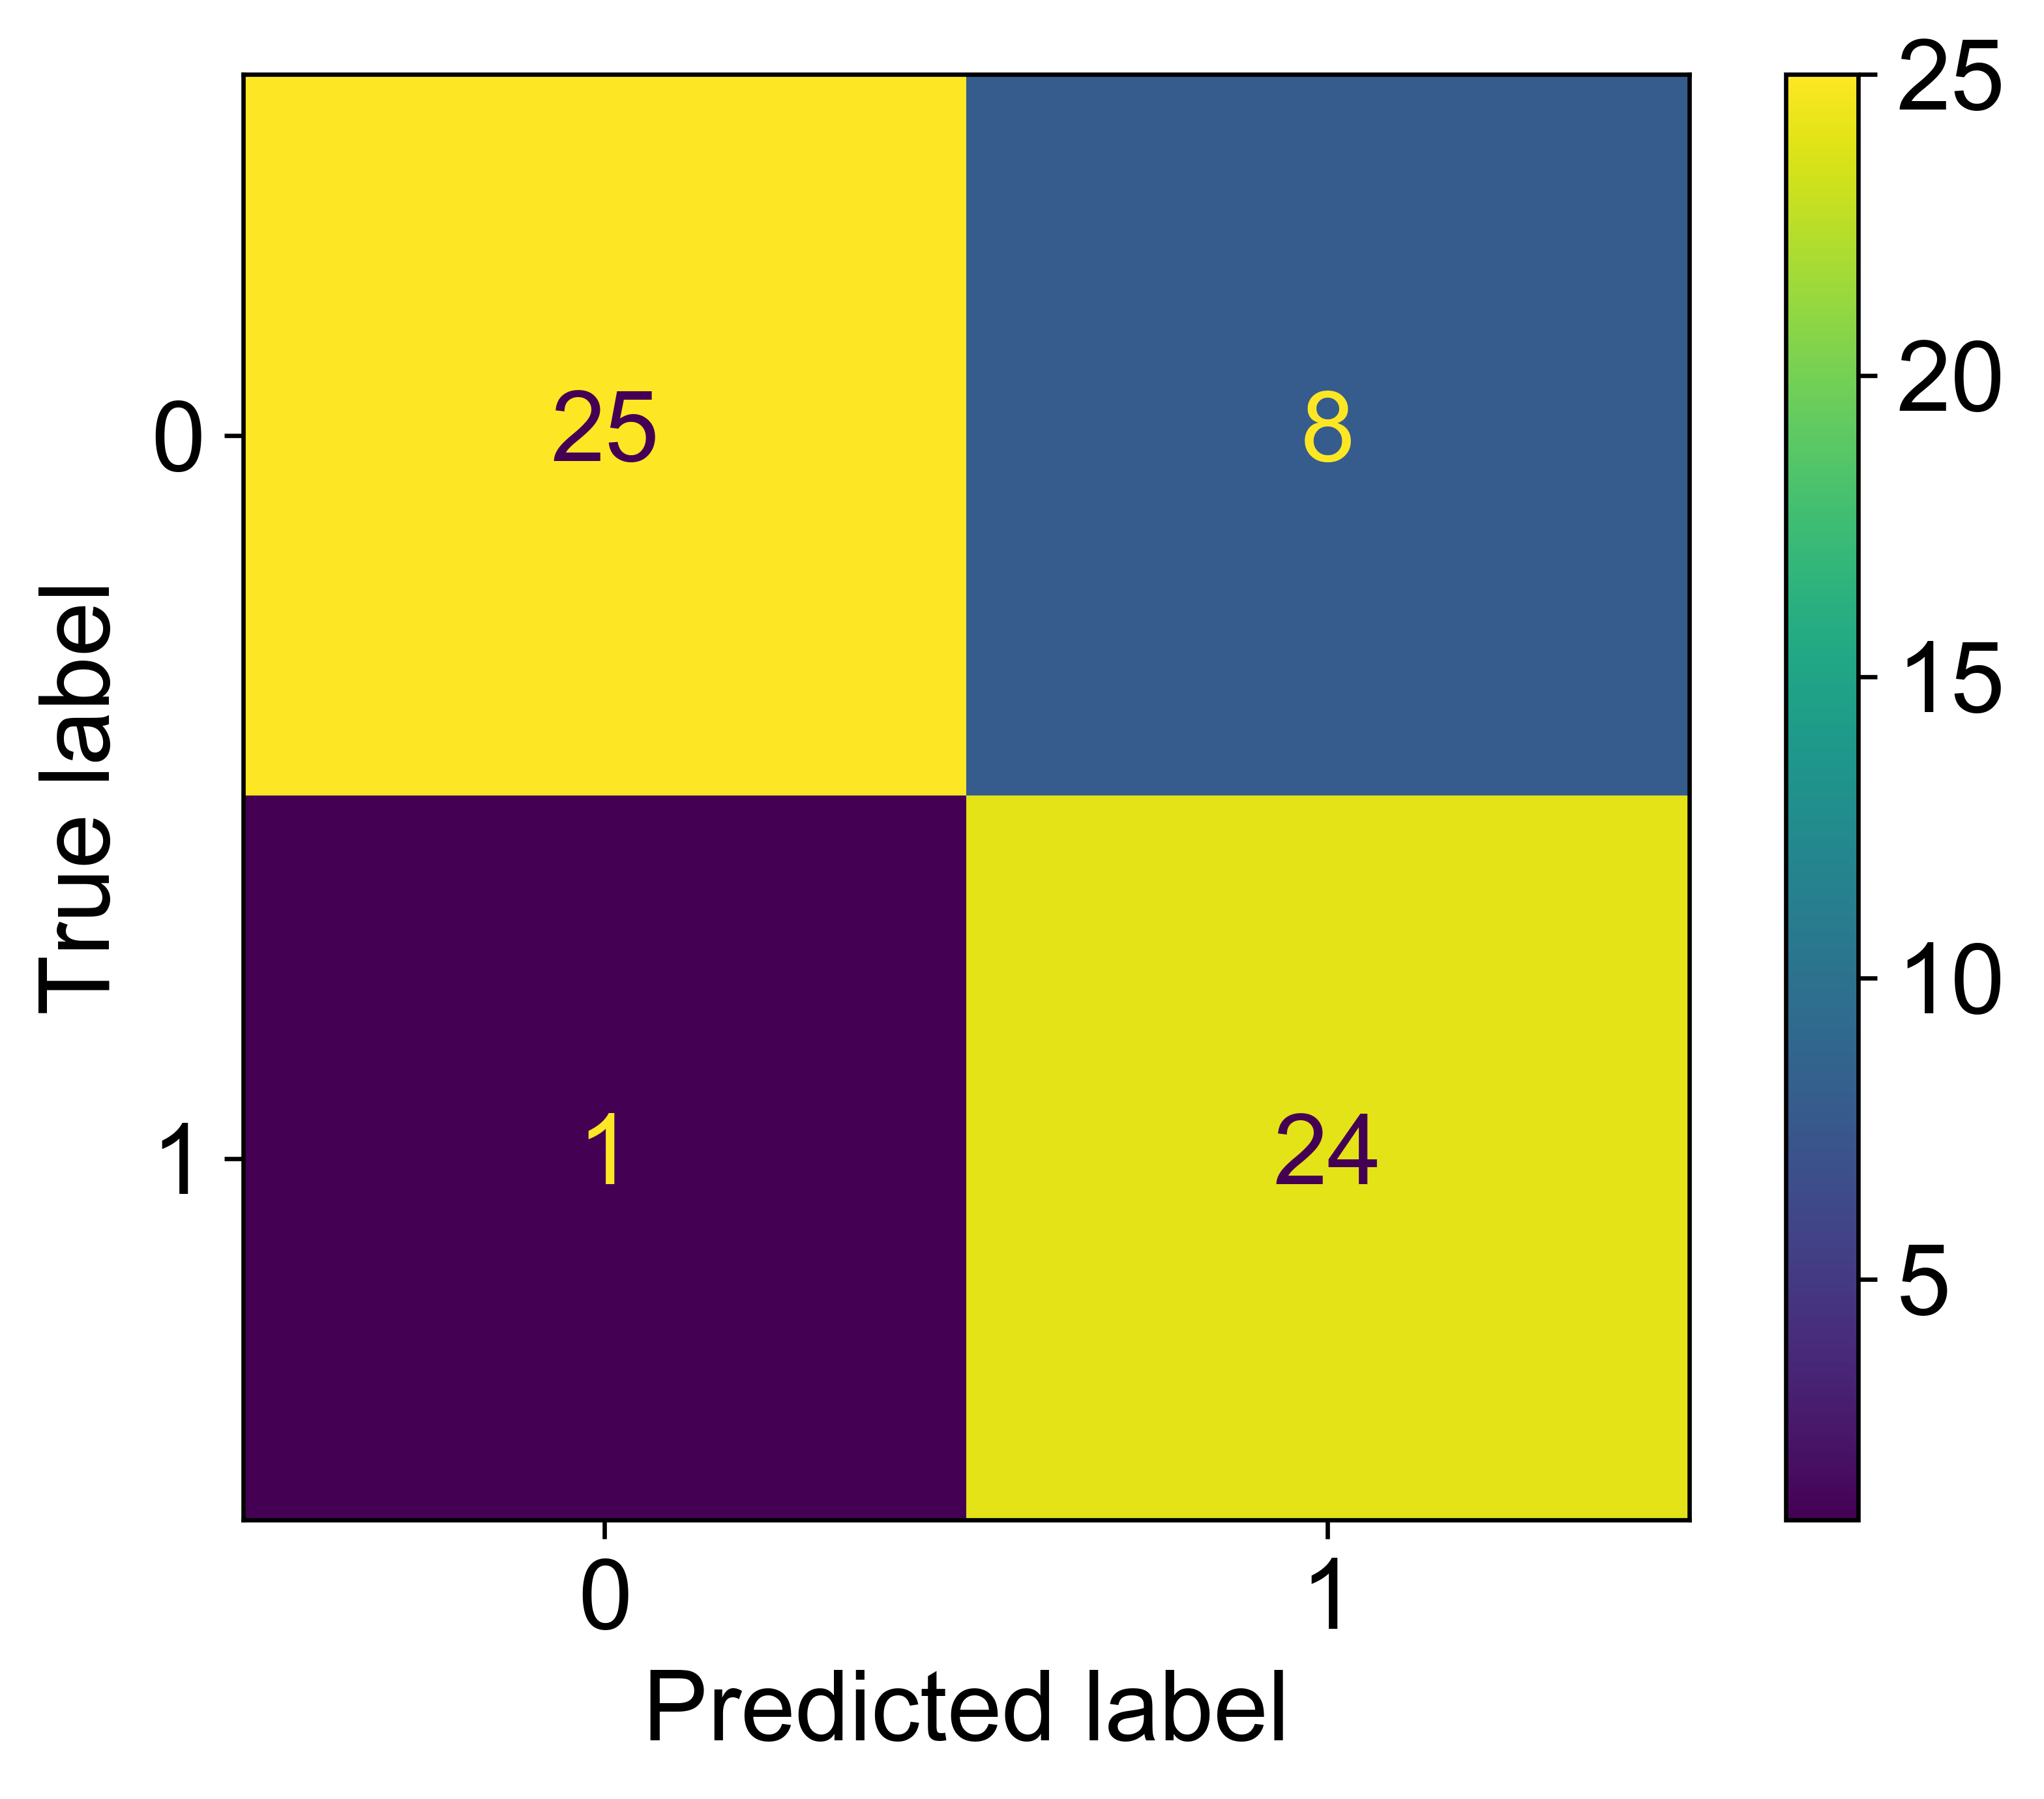

准确度：0.8448275862068966
灵敏度：0.96
特异度：0.7575757575757576
MCC: 0.714550733386196


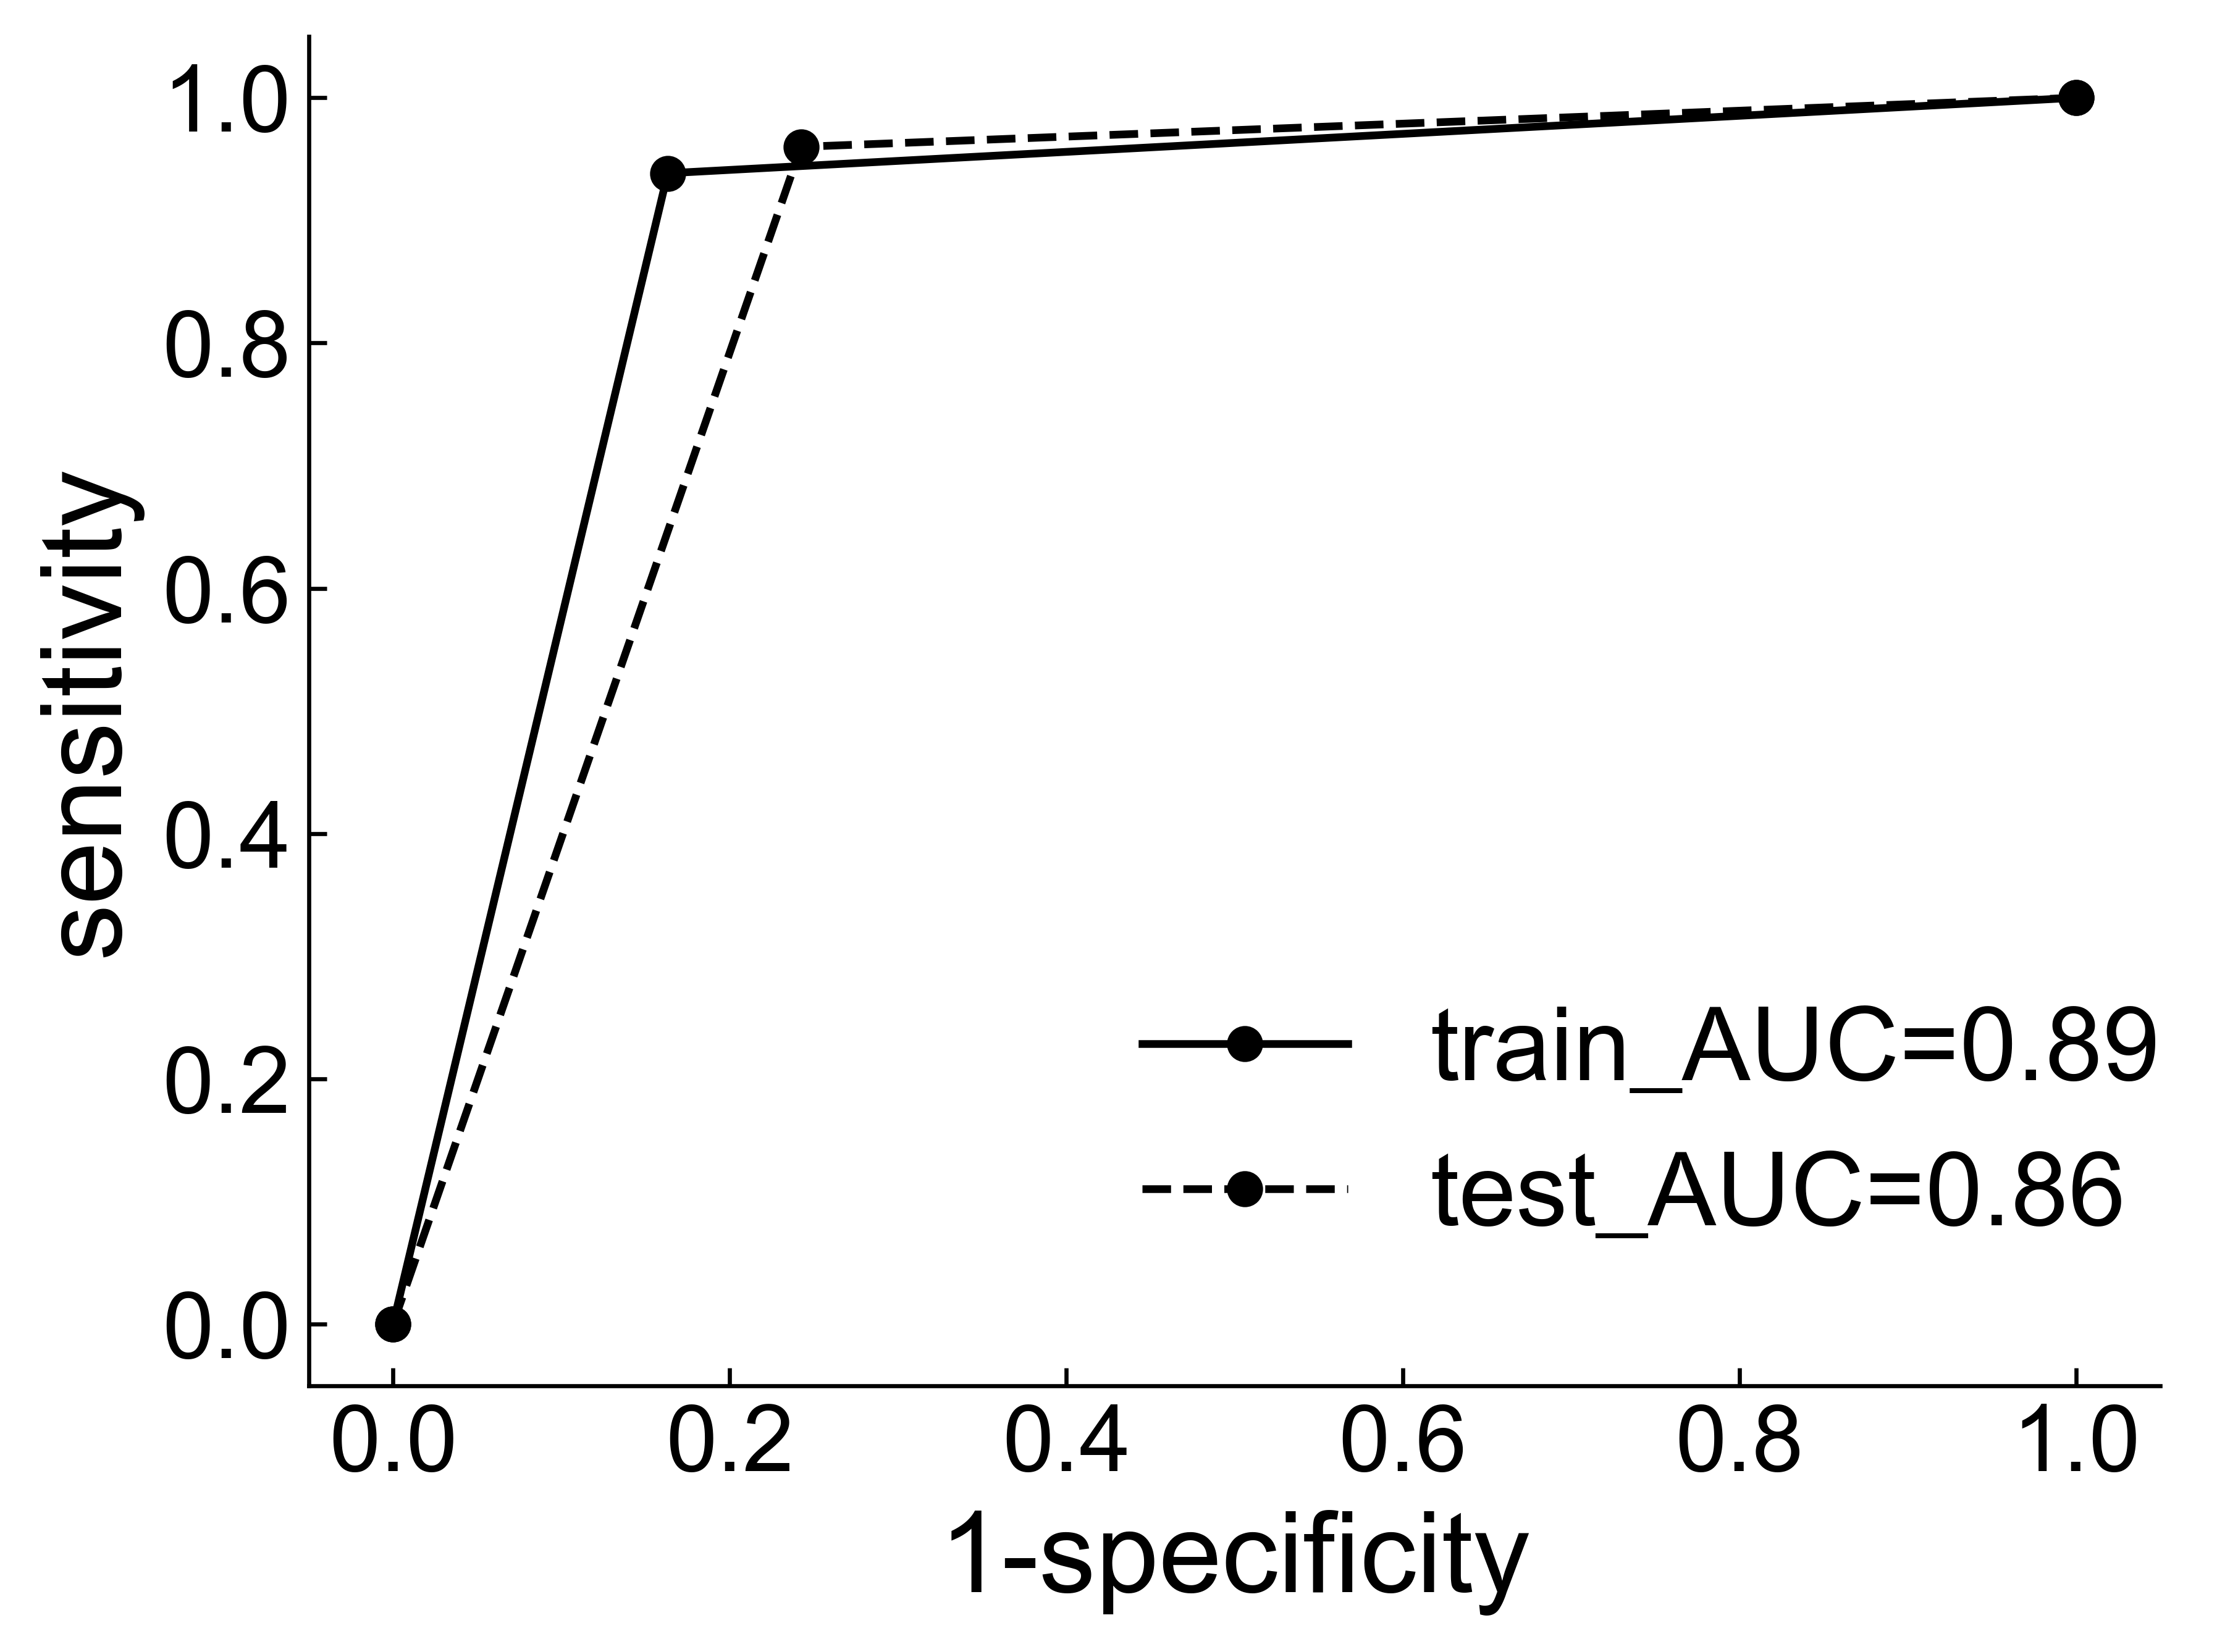

外部验证accuracy：0.845
外部验证precision：0.750
外部验证recall：0.960
外部验证f1-score：0.842
随机森林+XGBoost+梯度提升树


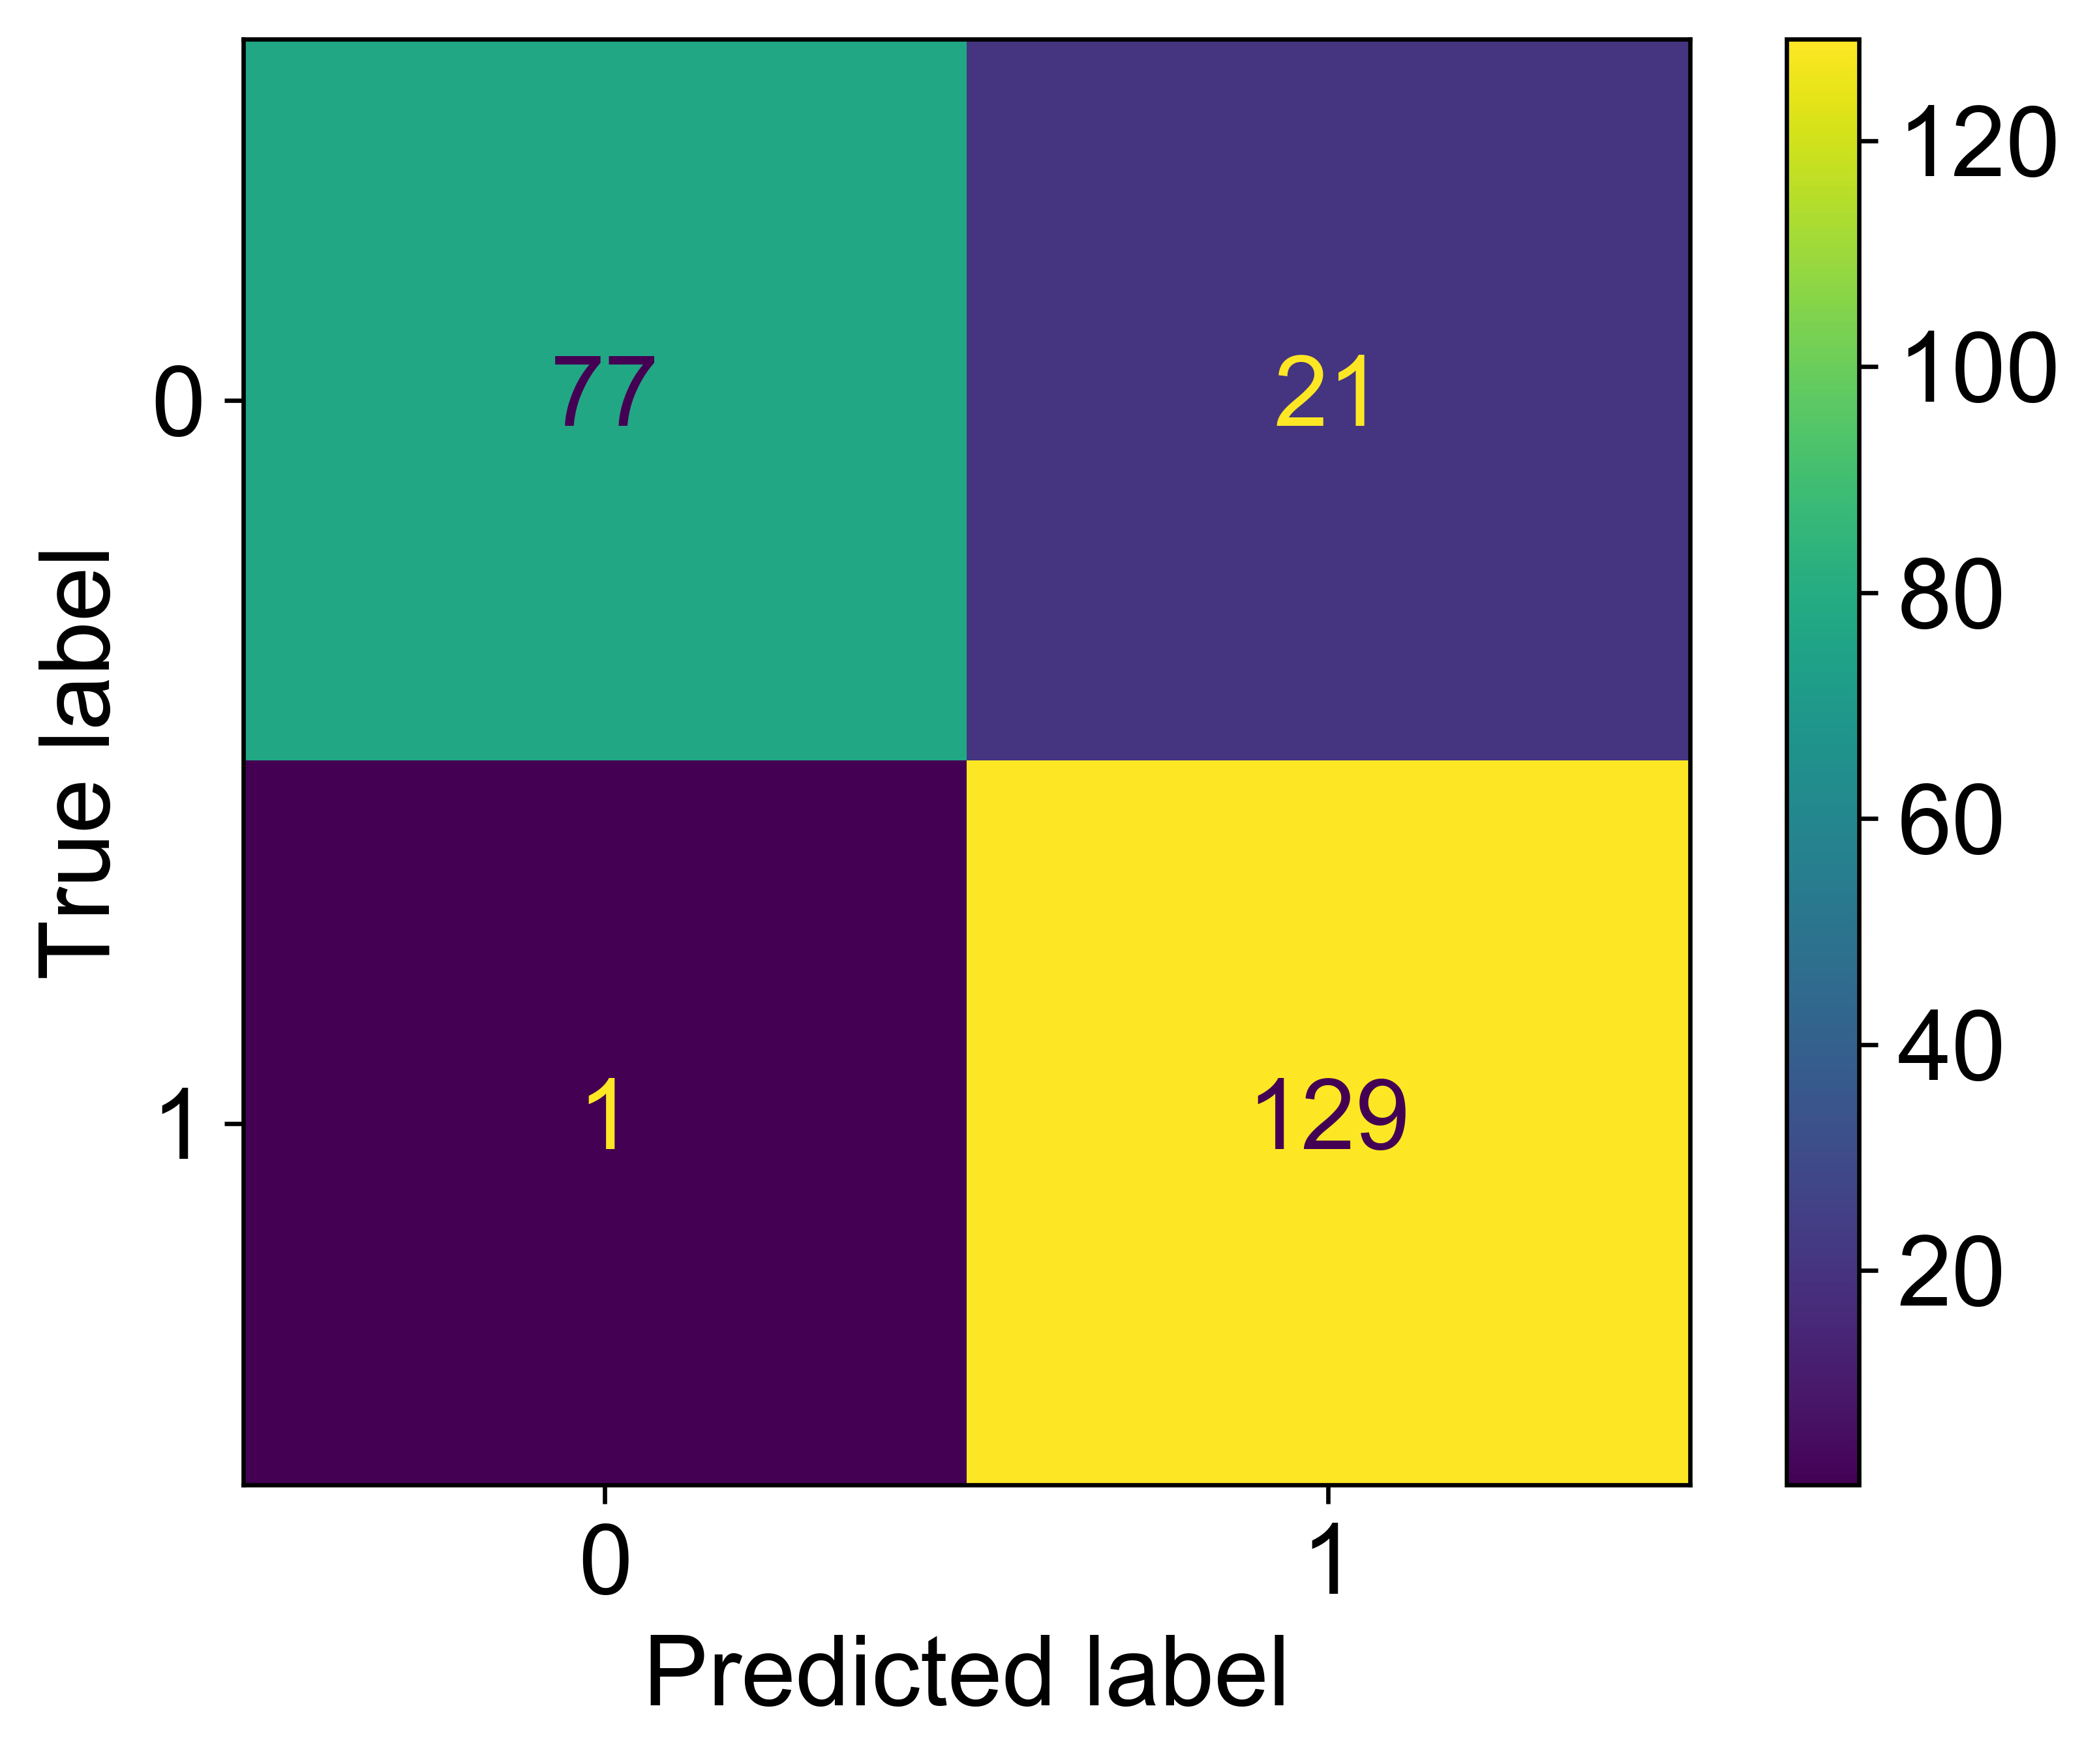

准确度：0.9035087719298246
灵敏度：0.9923076923076923
特异度：0.7857142857142857
MCC: 0.811864681061462
内部验证accuracy：0.904
内部验证precision：0.860
内部验证recall：0.992
内部验证f1-score：0.921


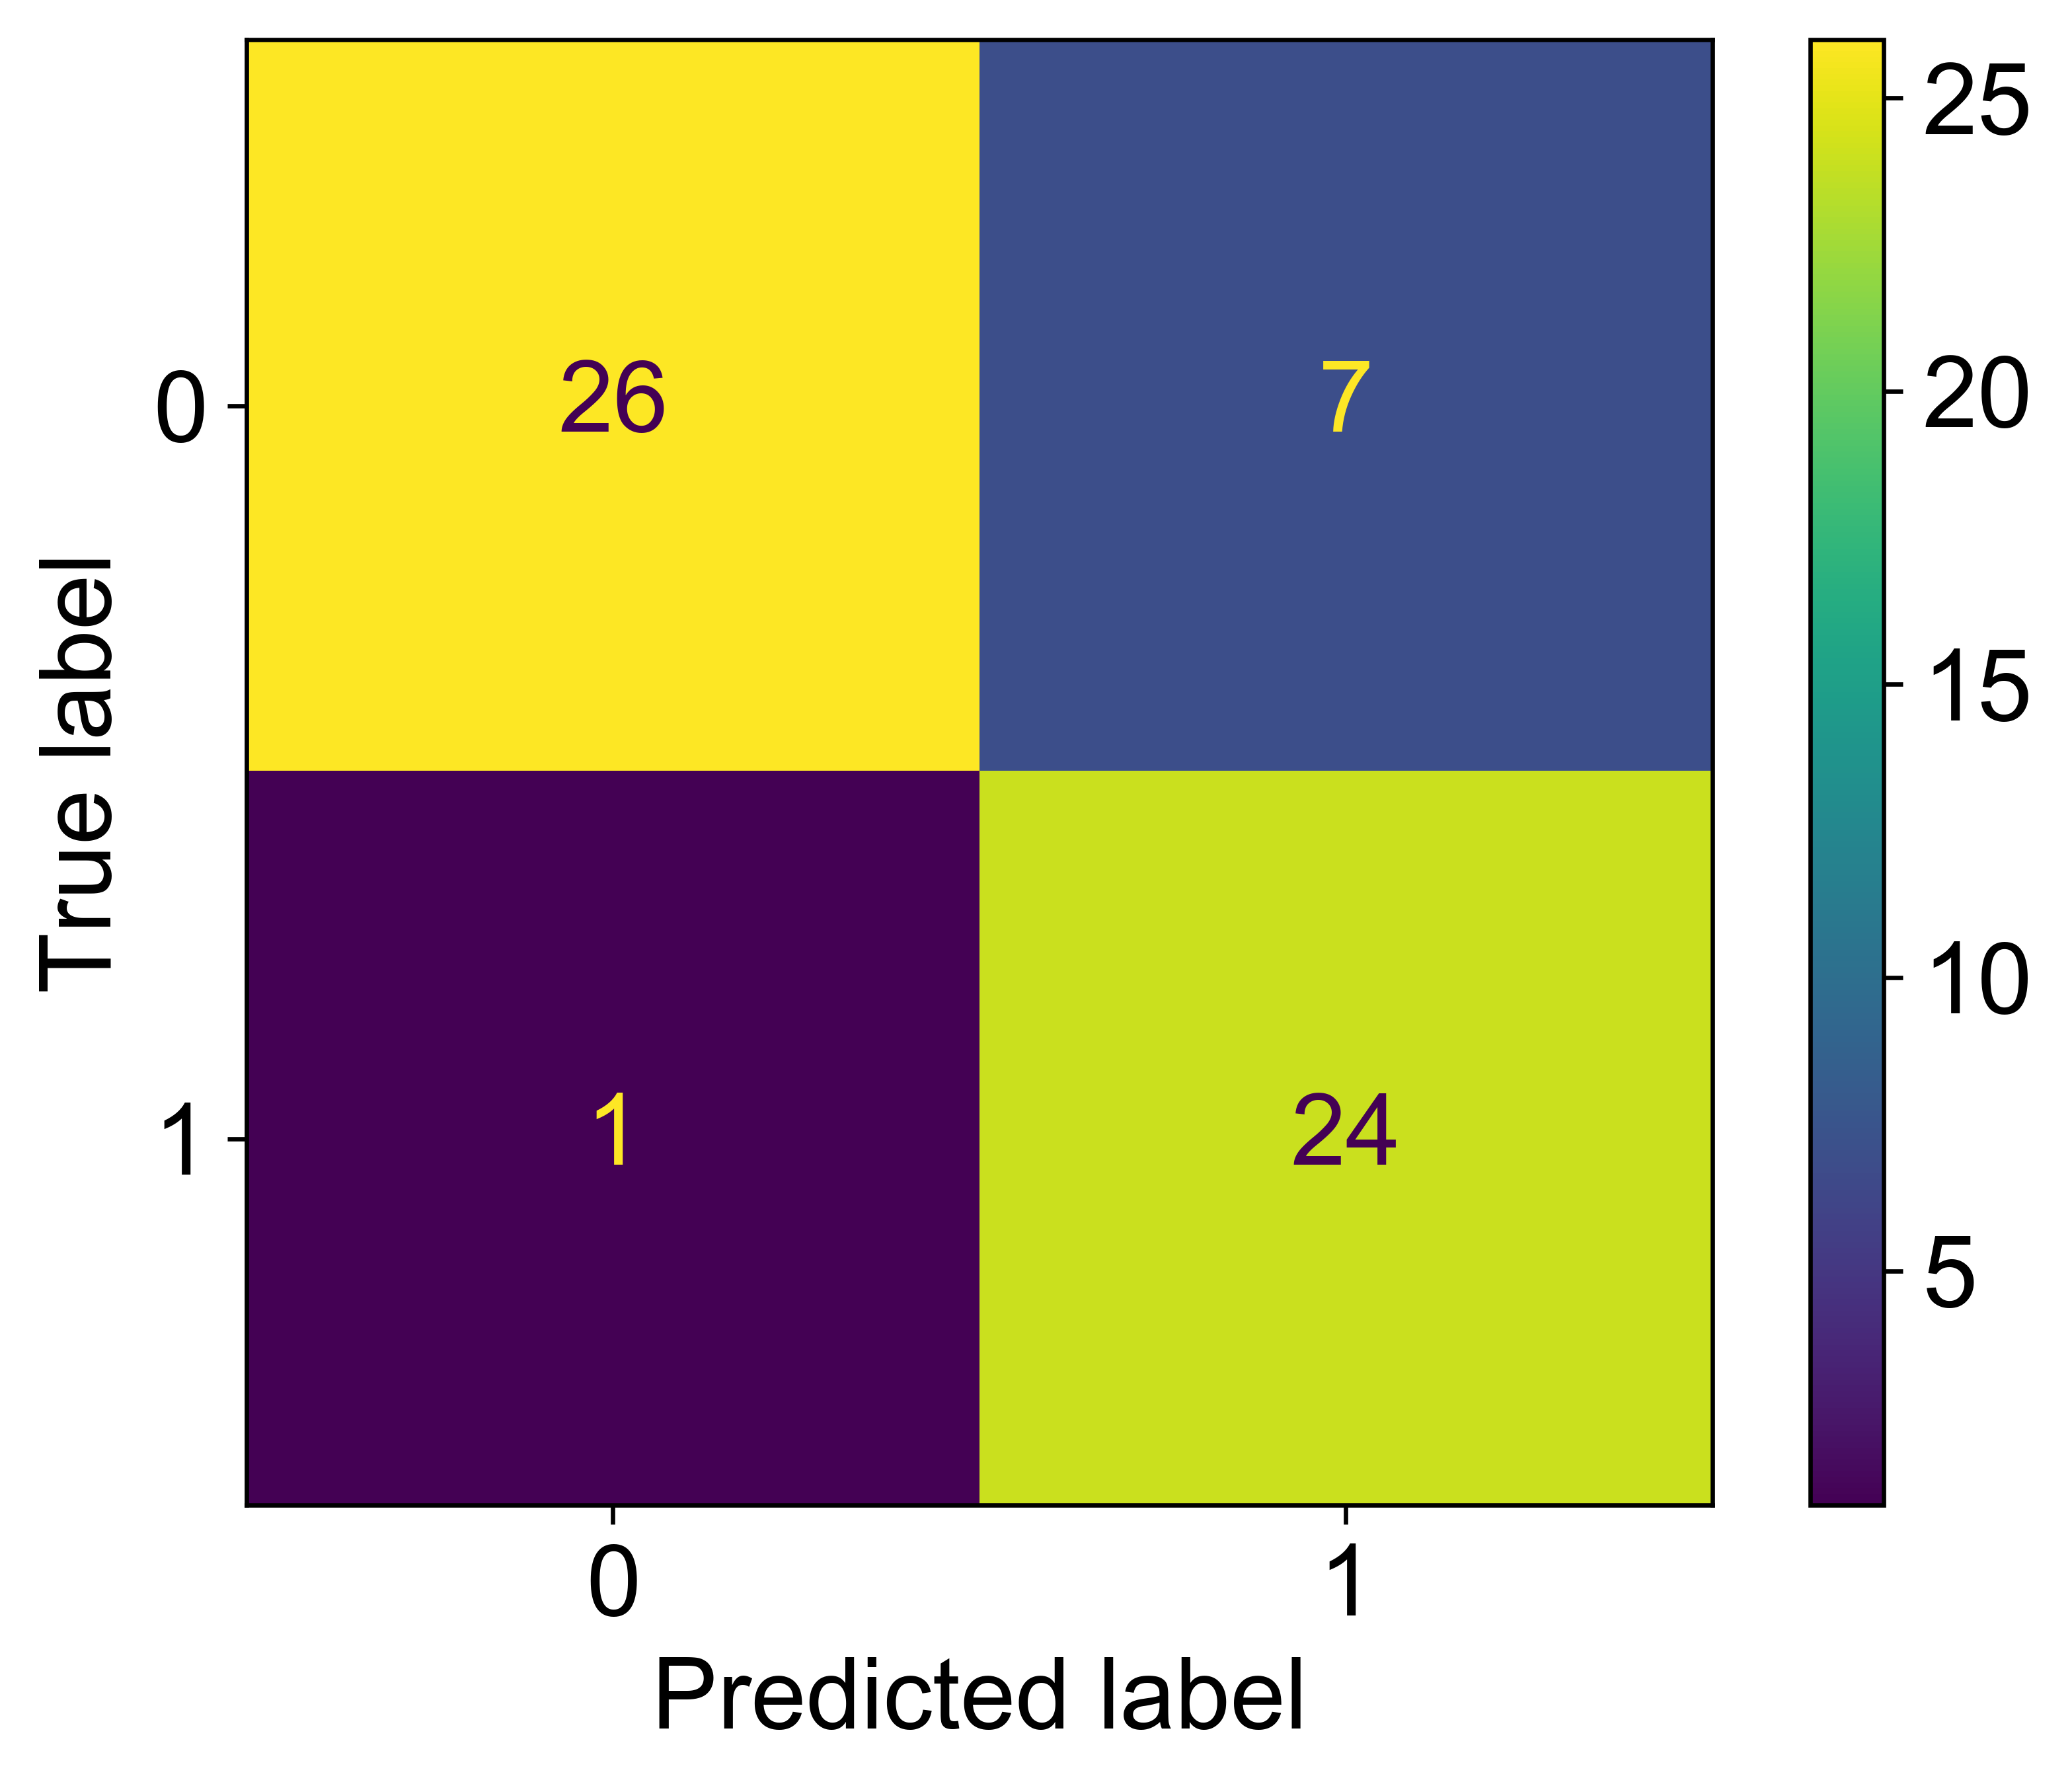

准确度：0.8620689655172413
灵敏度：0.96
特异度：0.7878787878787878
MCC: 0.742498295072412


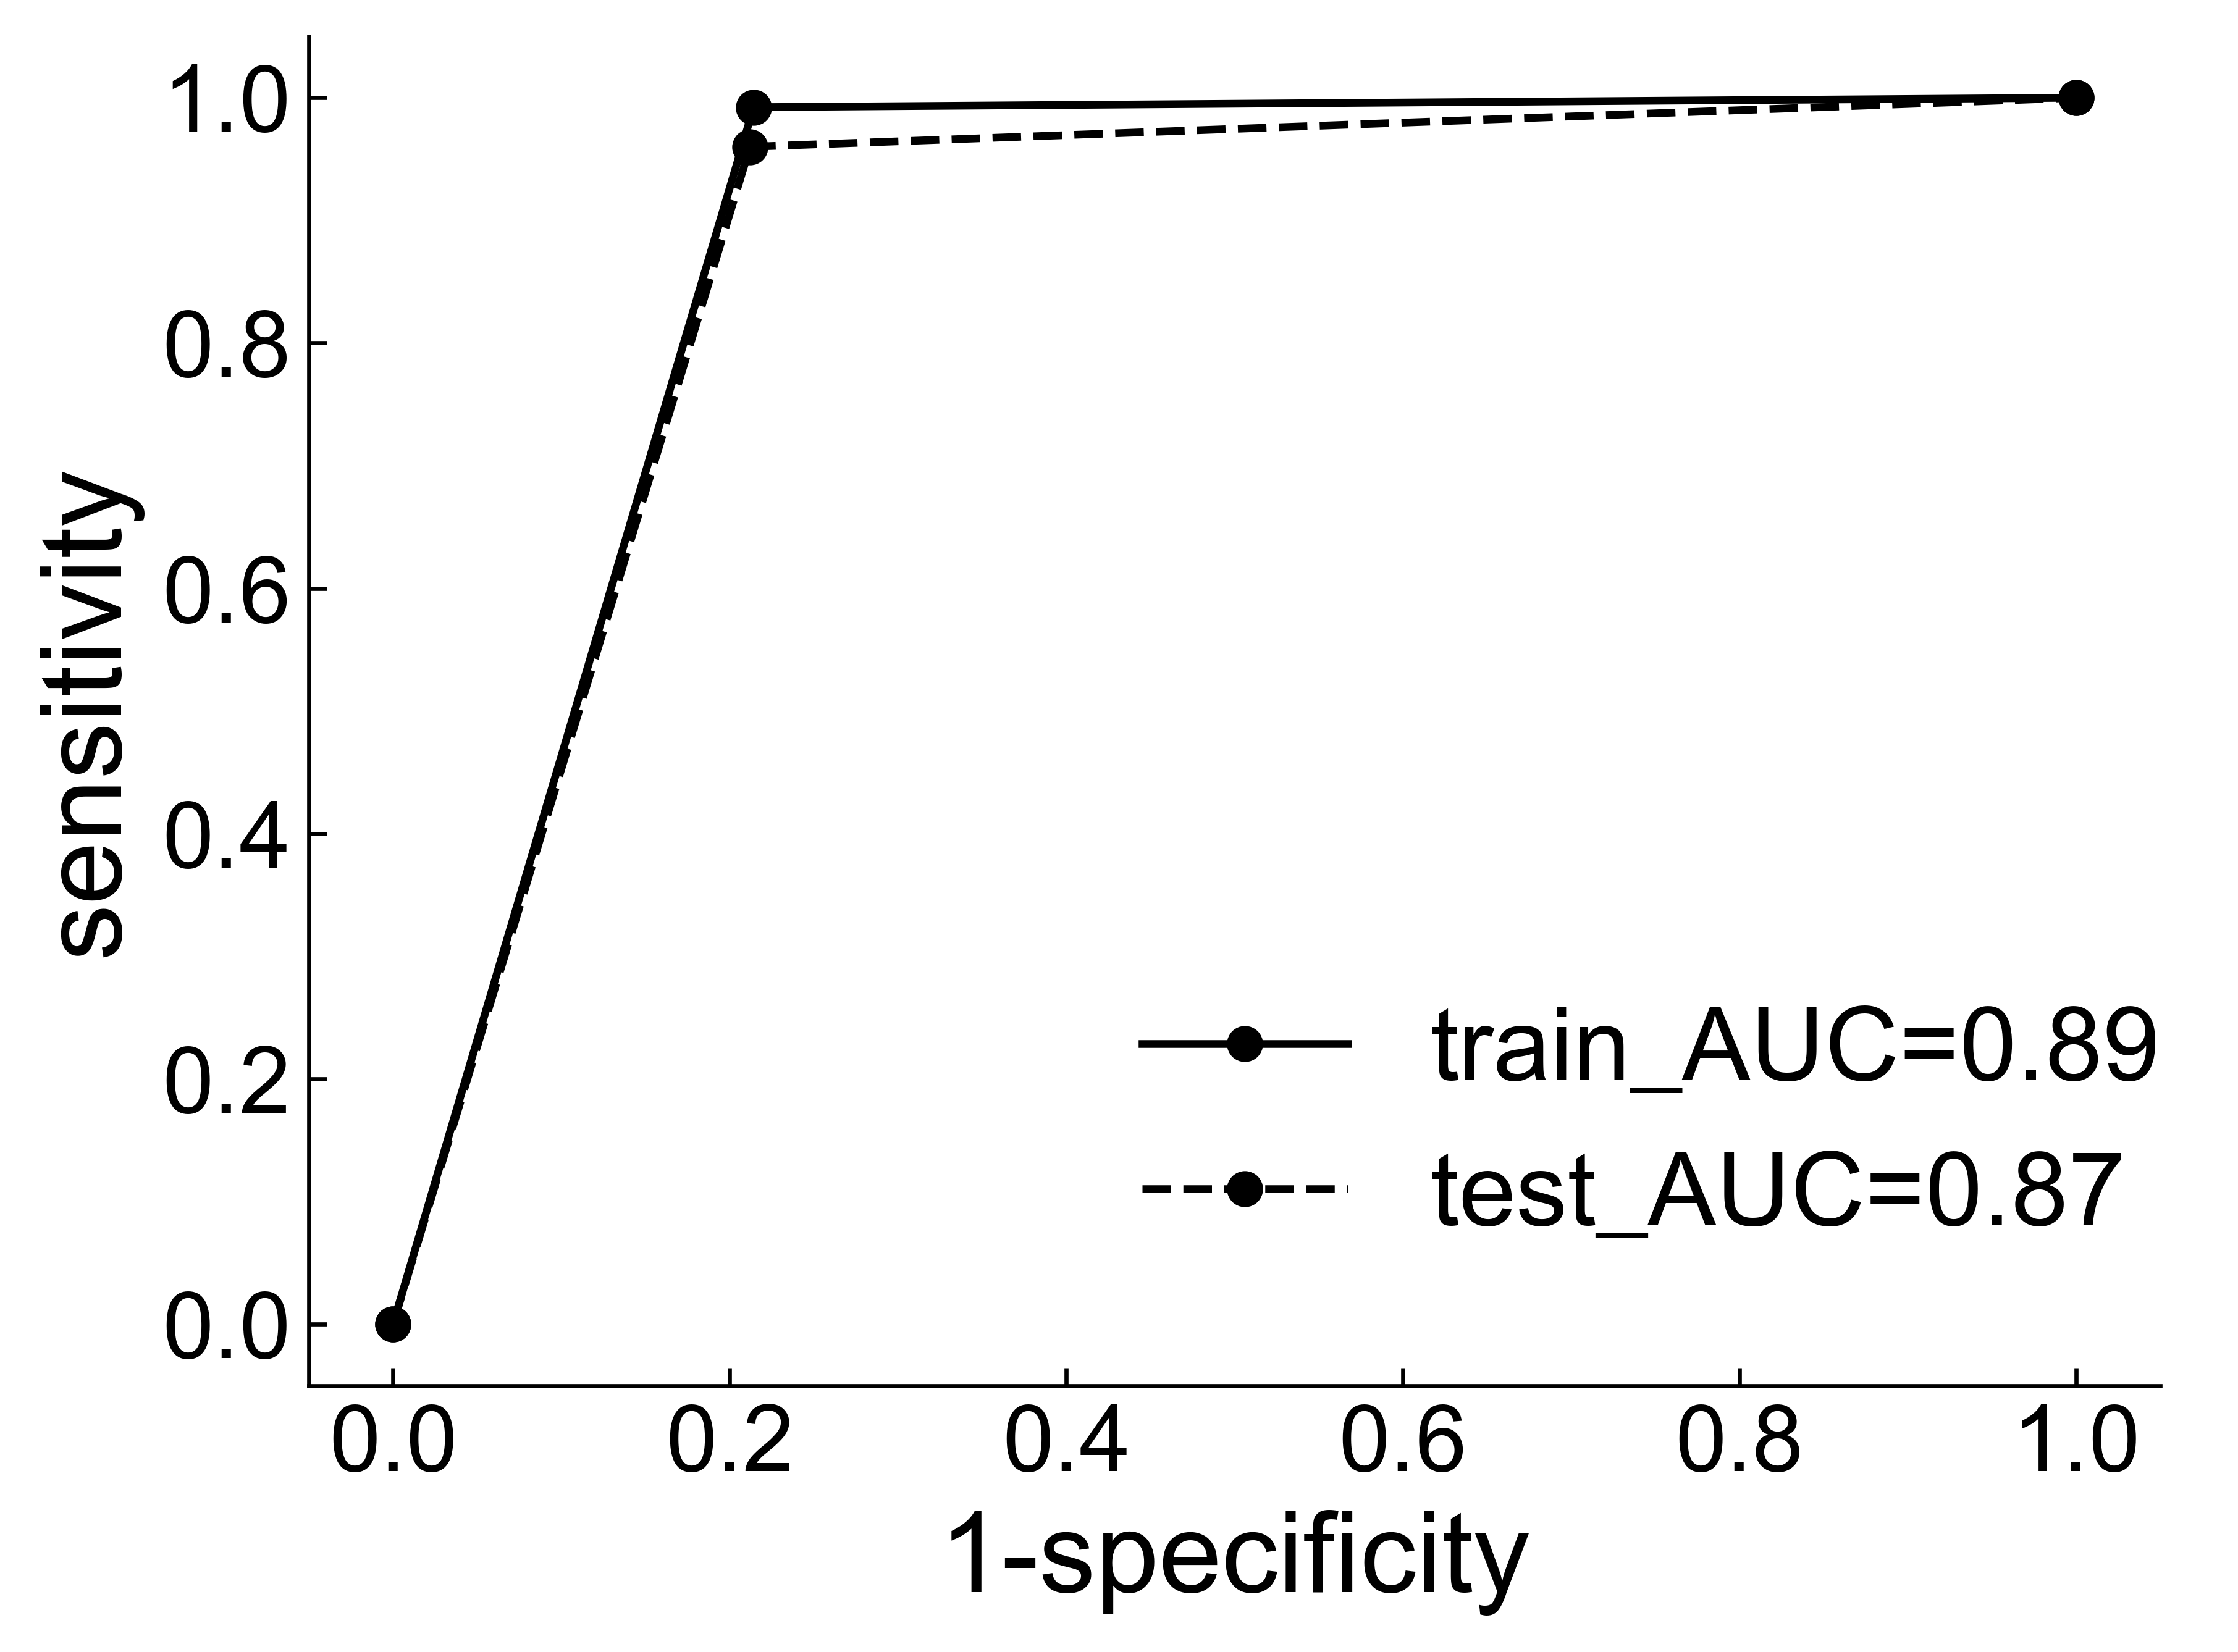

外部验证accuracy：0.862
外部验证precision：0.774
外部验证recall：0.960
外部验证f1-score：0.857
随机森林+mlp+梯度提升树


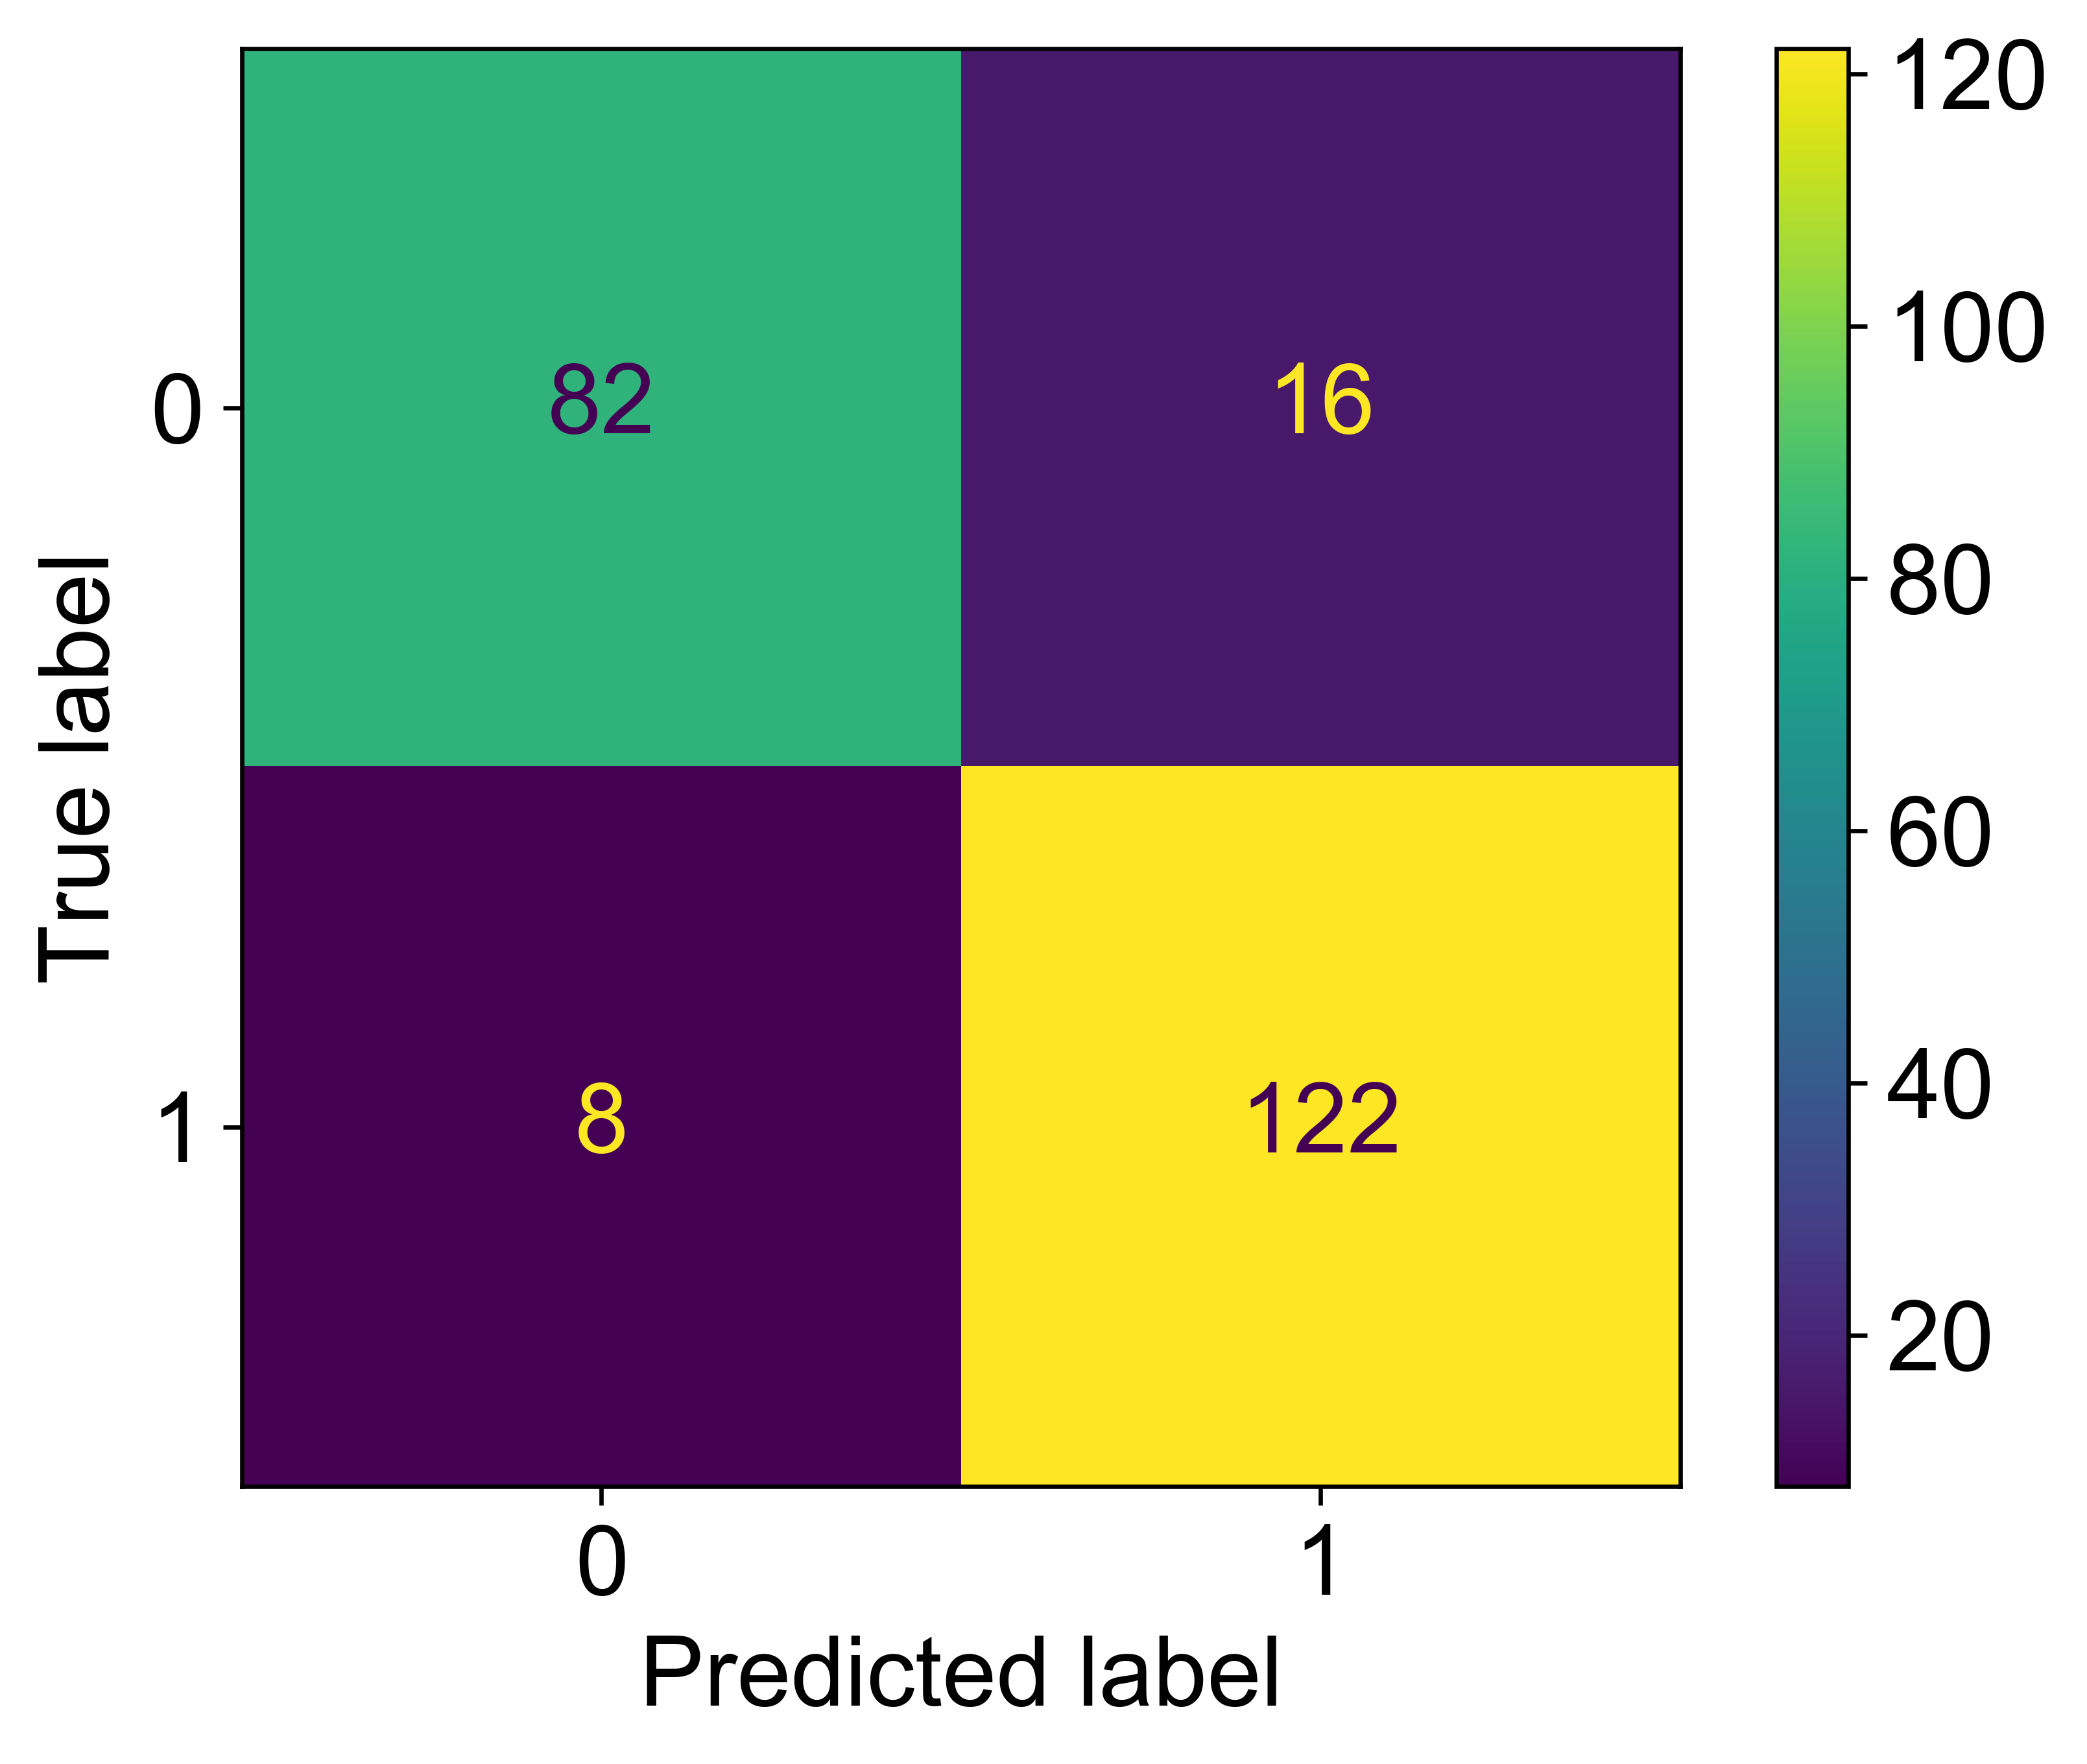

准确度：0.8947368421052632
灵敏度：0.9384615384615385
特异度：0.8367346938775511
MCC: 0.7851191479872976
内部验证accuracy：0.895
内部验证precision：0.884
内部验证recall：0.938
内部验证f1-score：0.910


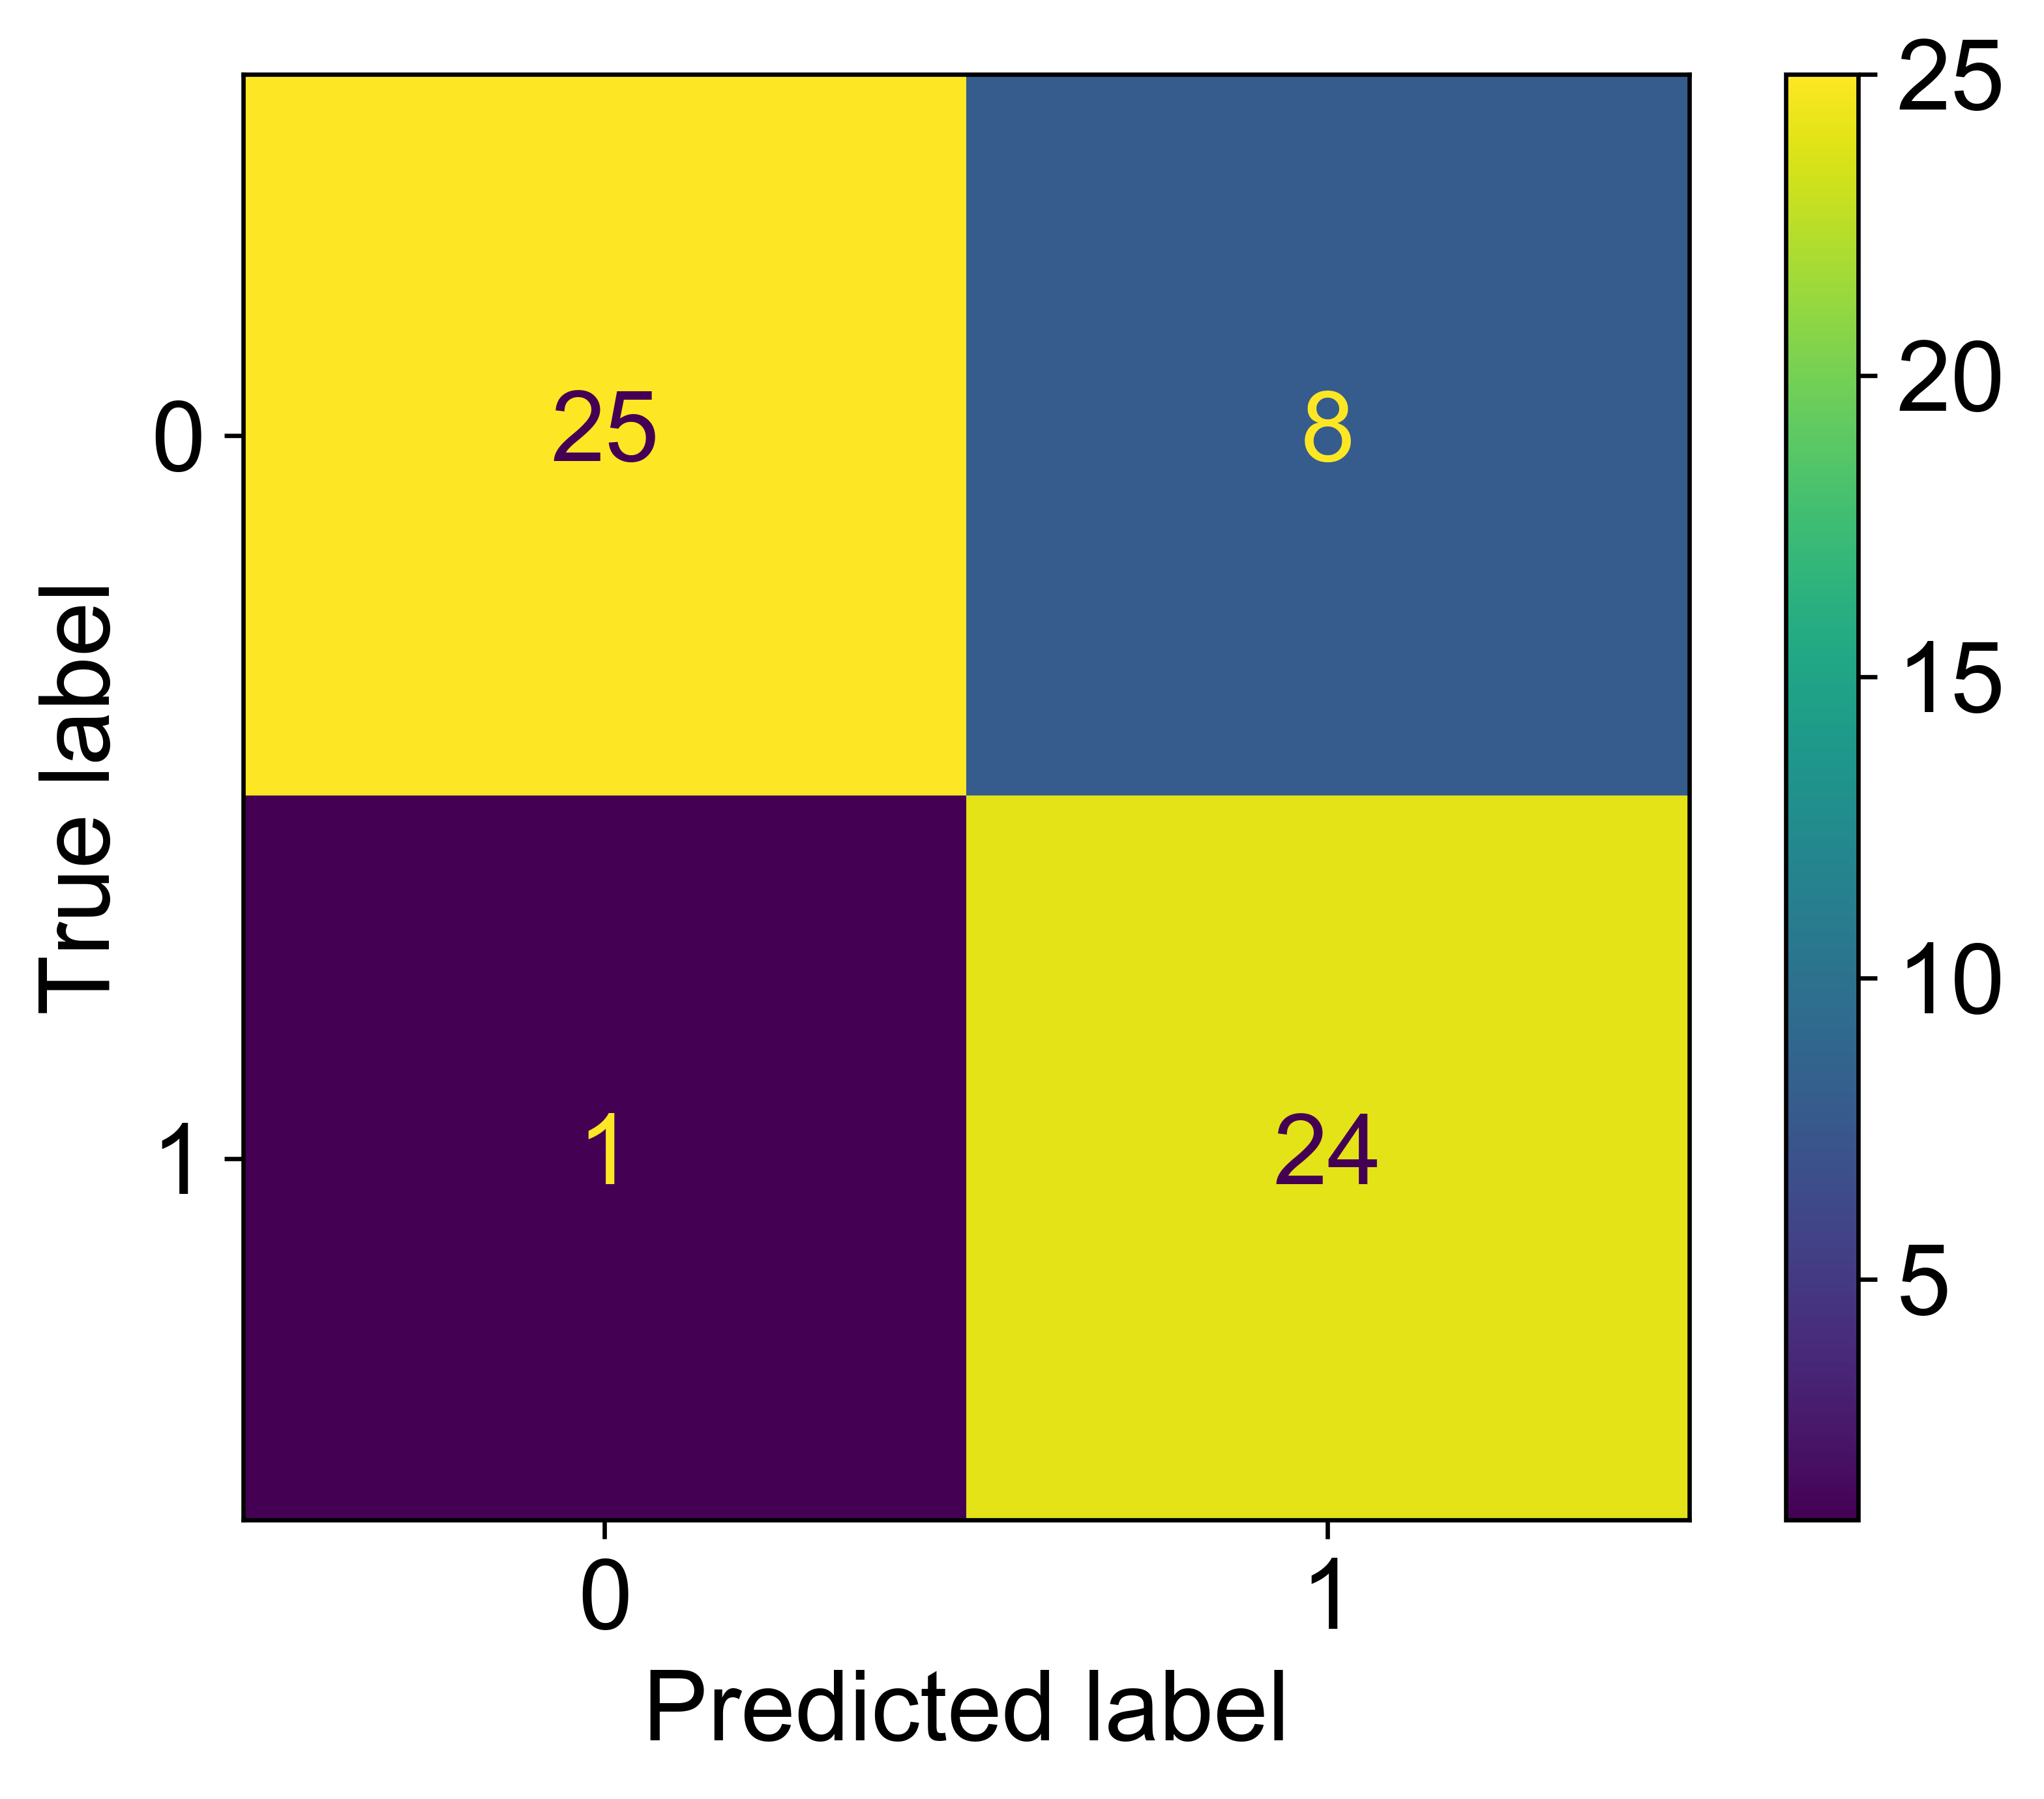

准确度：0.8448275862068966
灵敏度：0.96
特异度：0.7575757575757576
MCC: 0.714550733386196


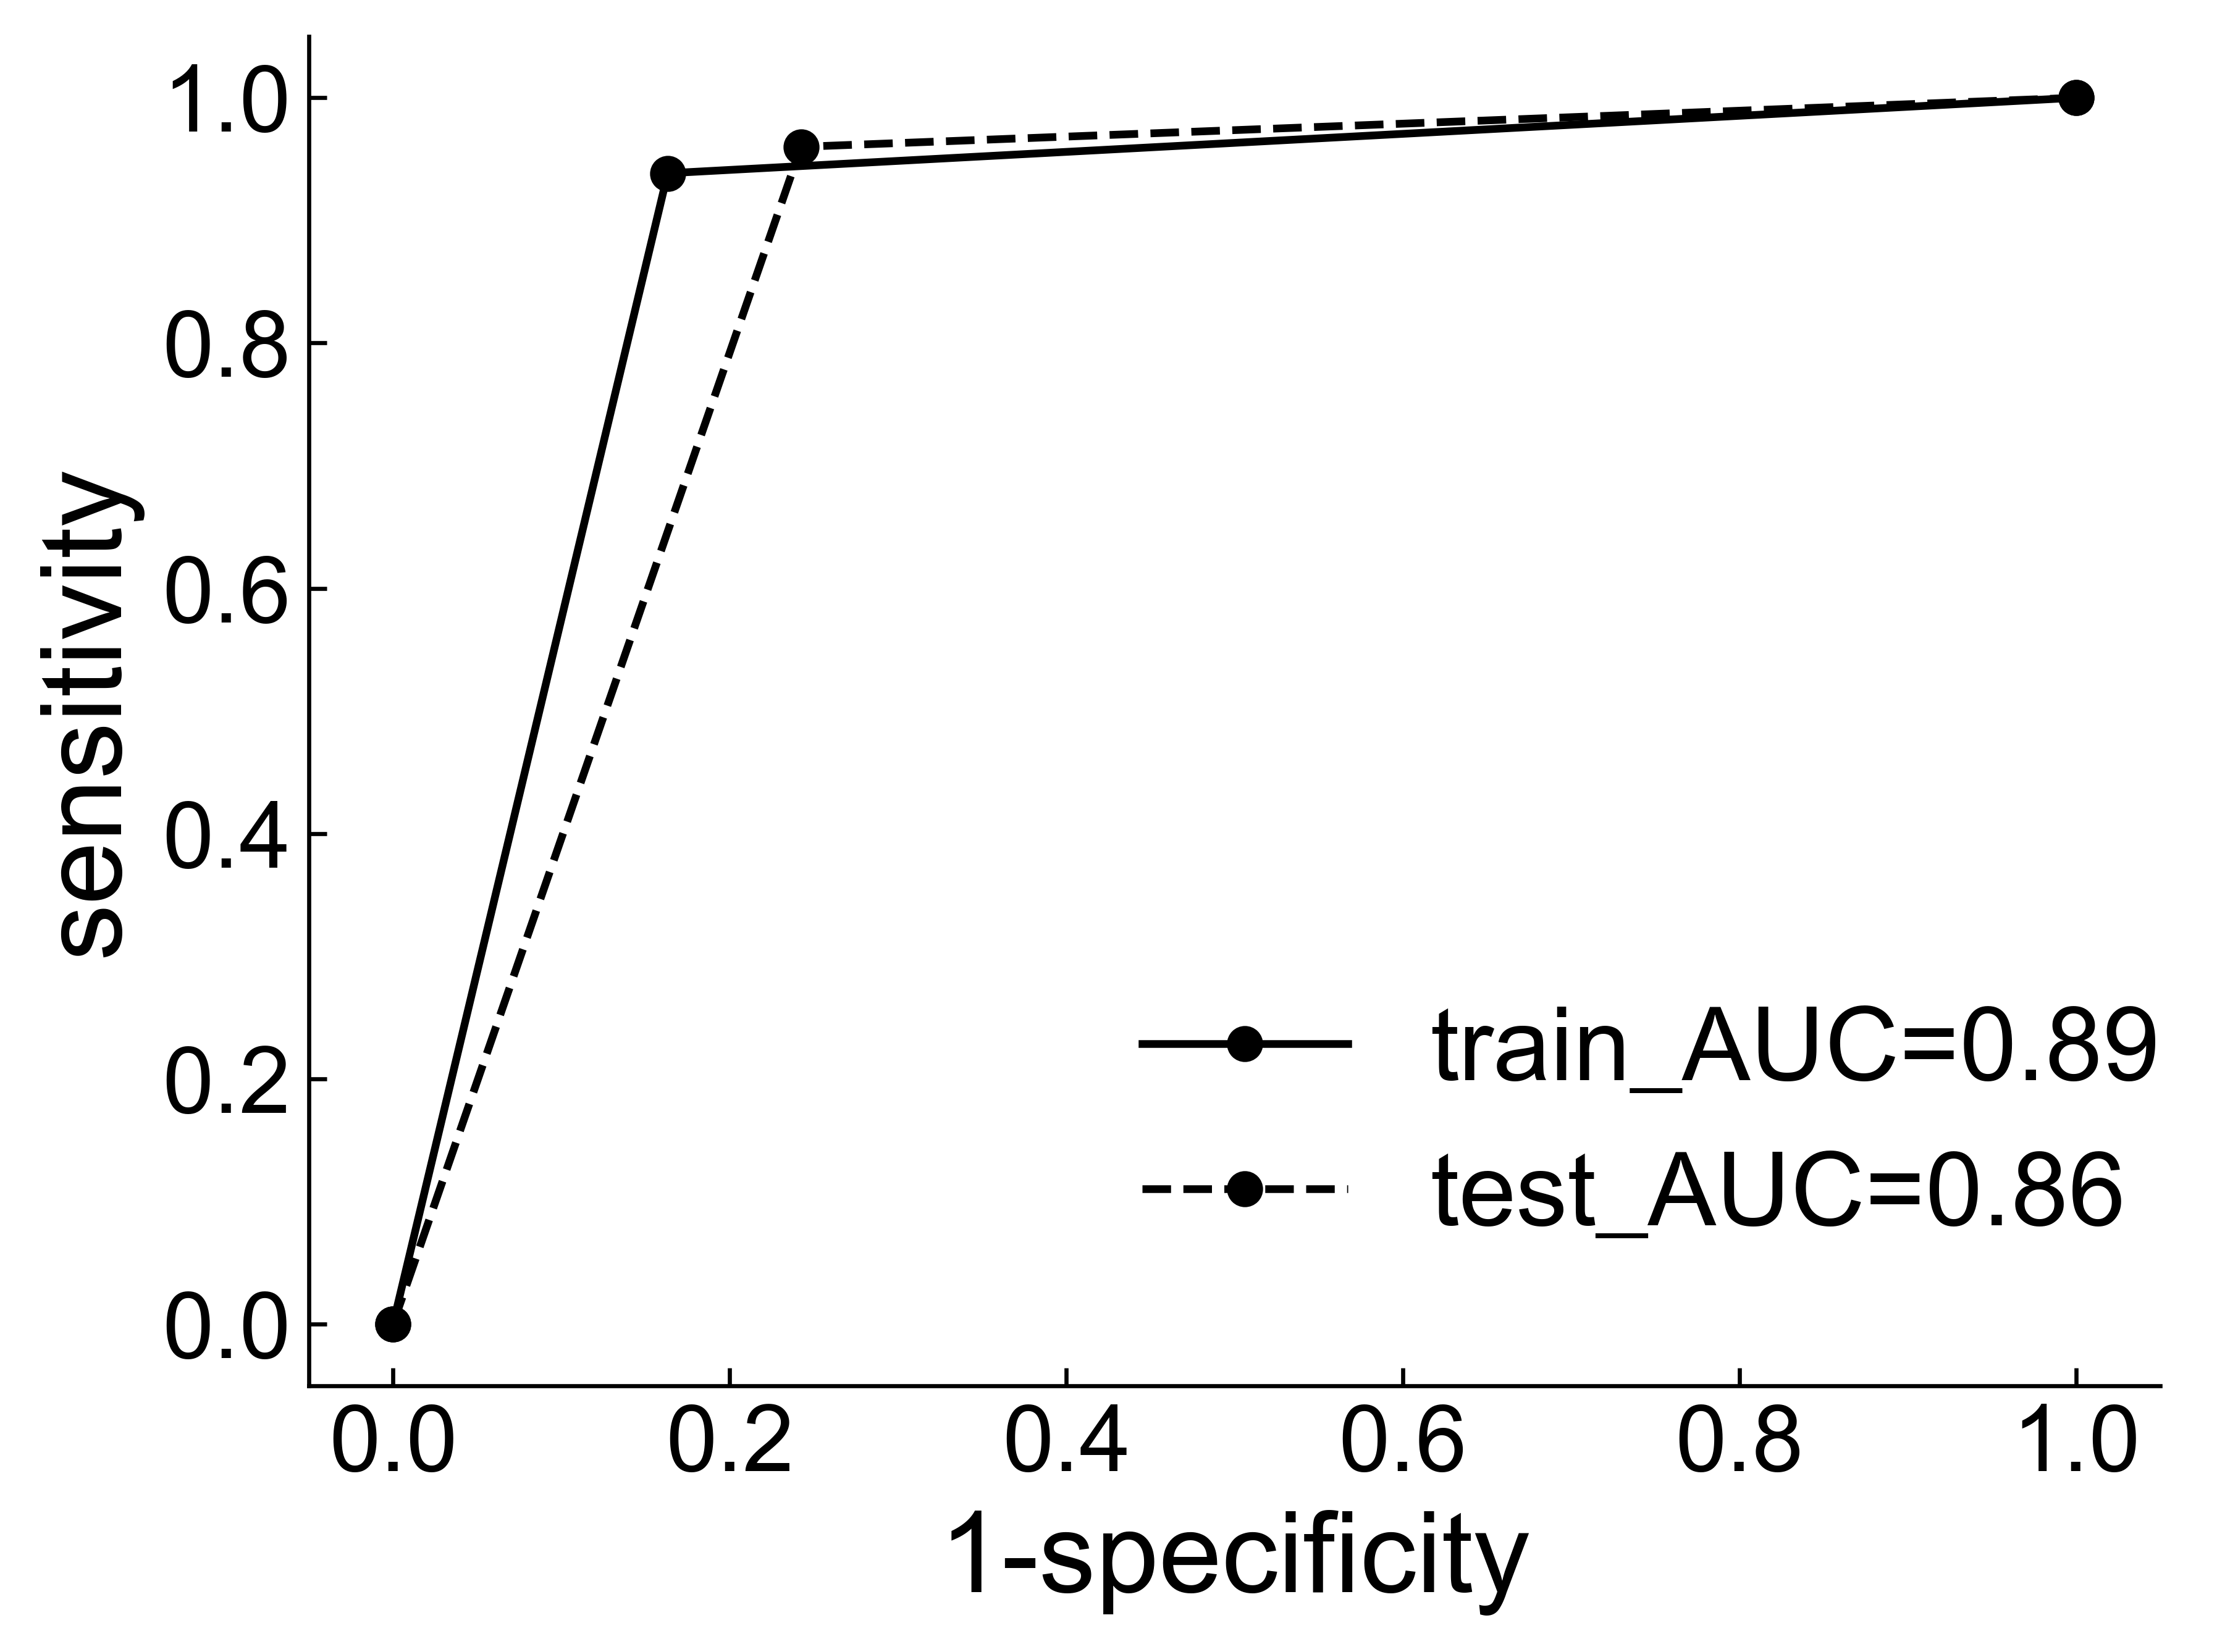

外部验证accuracy：0.845
外部验证precision：0.750
外部验证recall：0.960
外部验证f1-score：0.842
XGBoost+mlp+梯度提升树


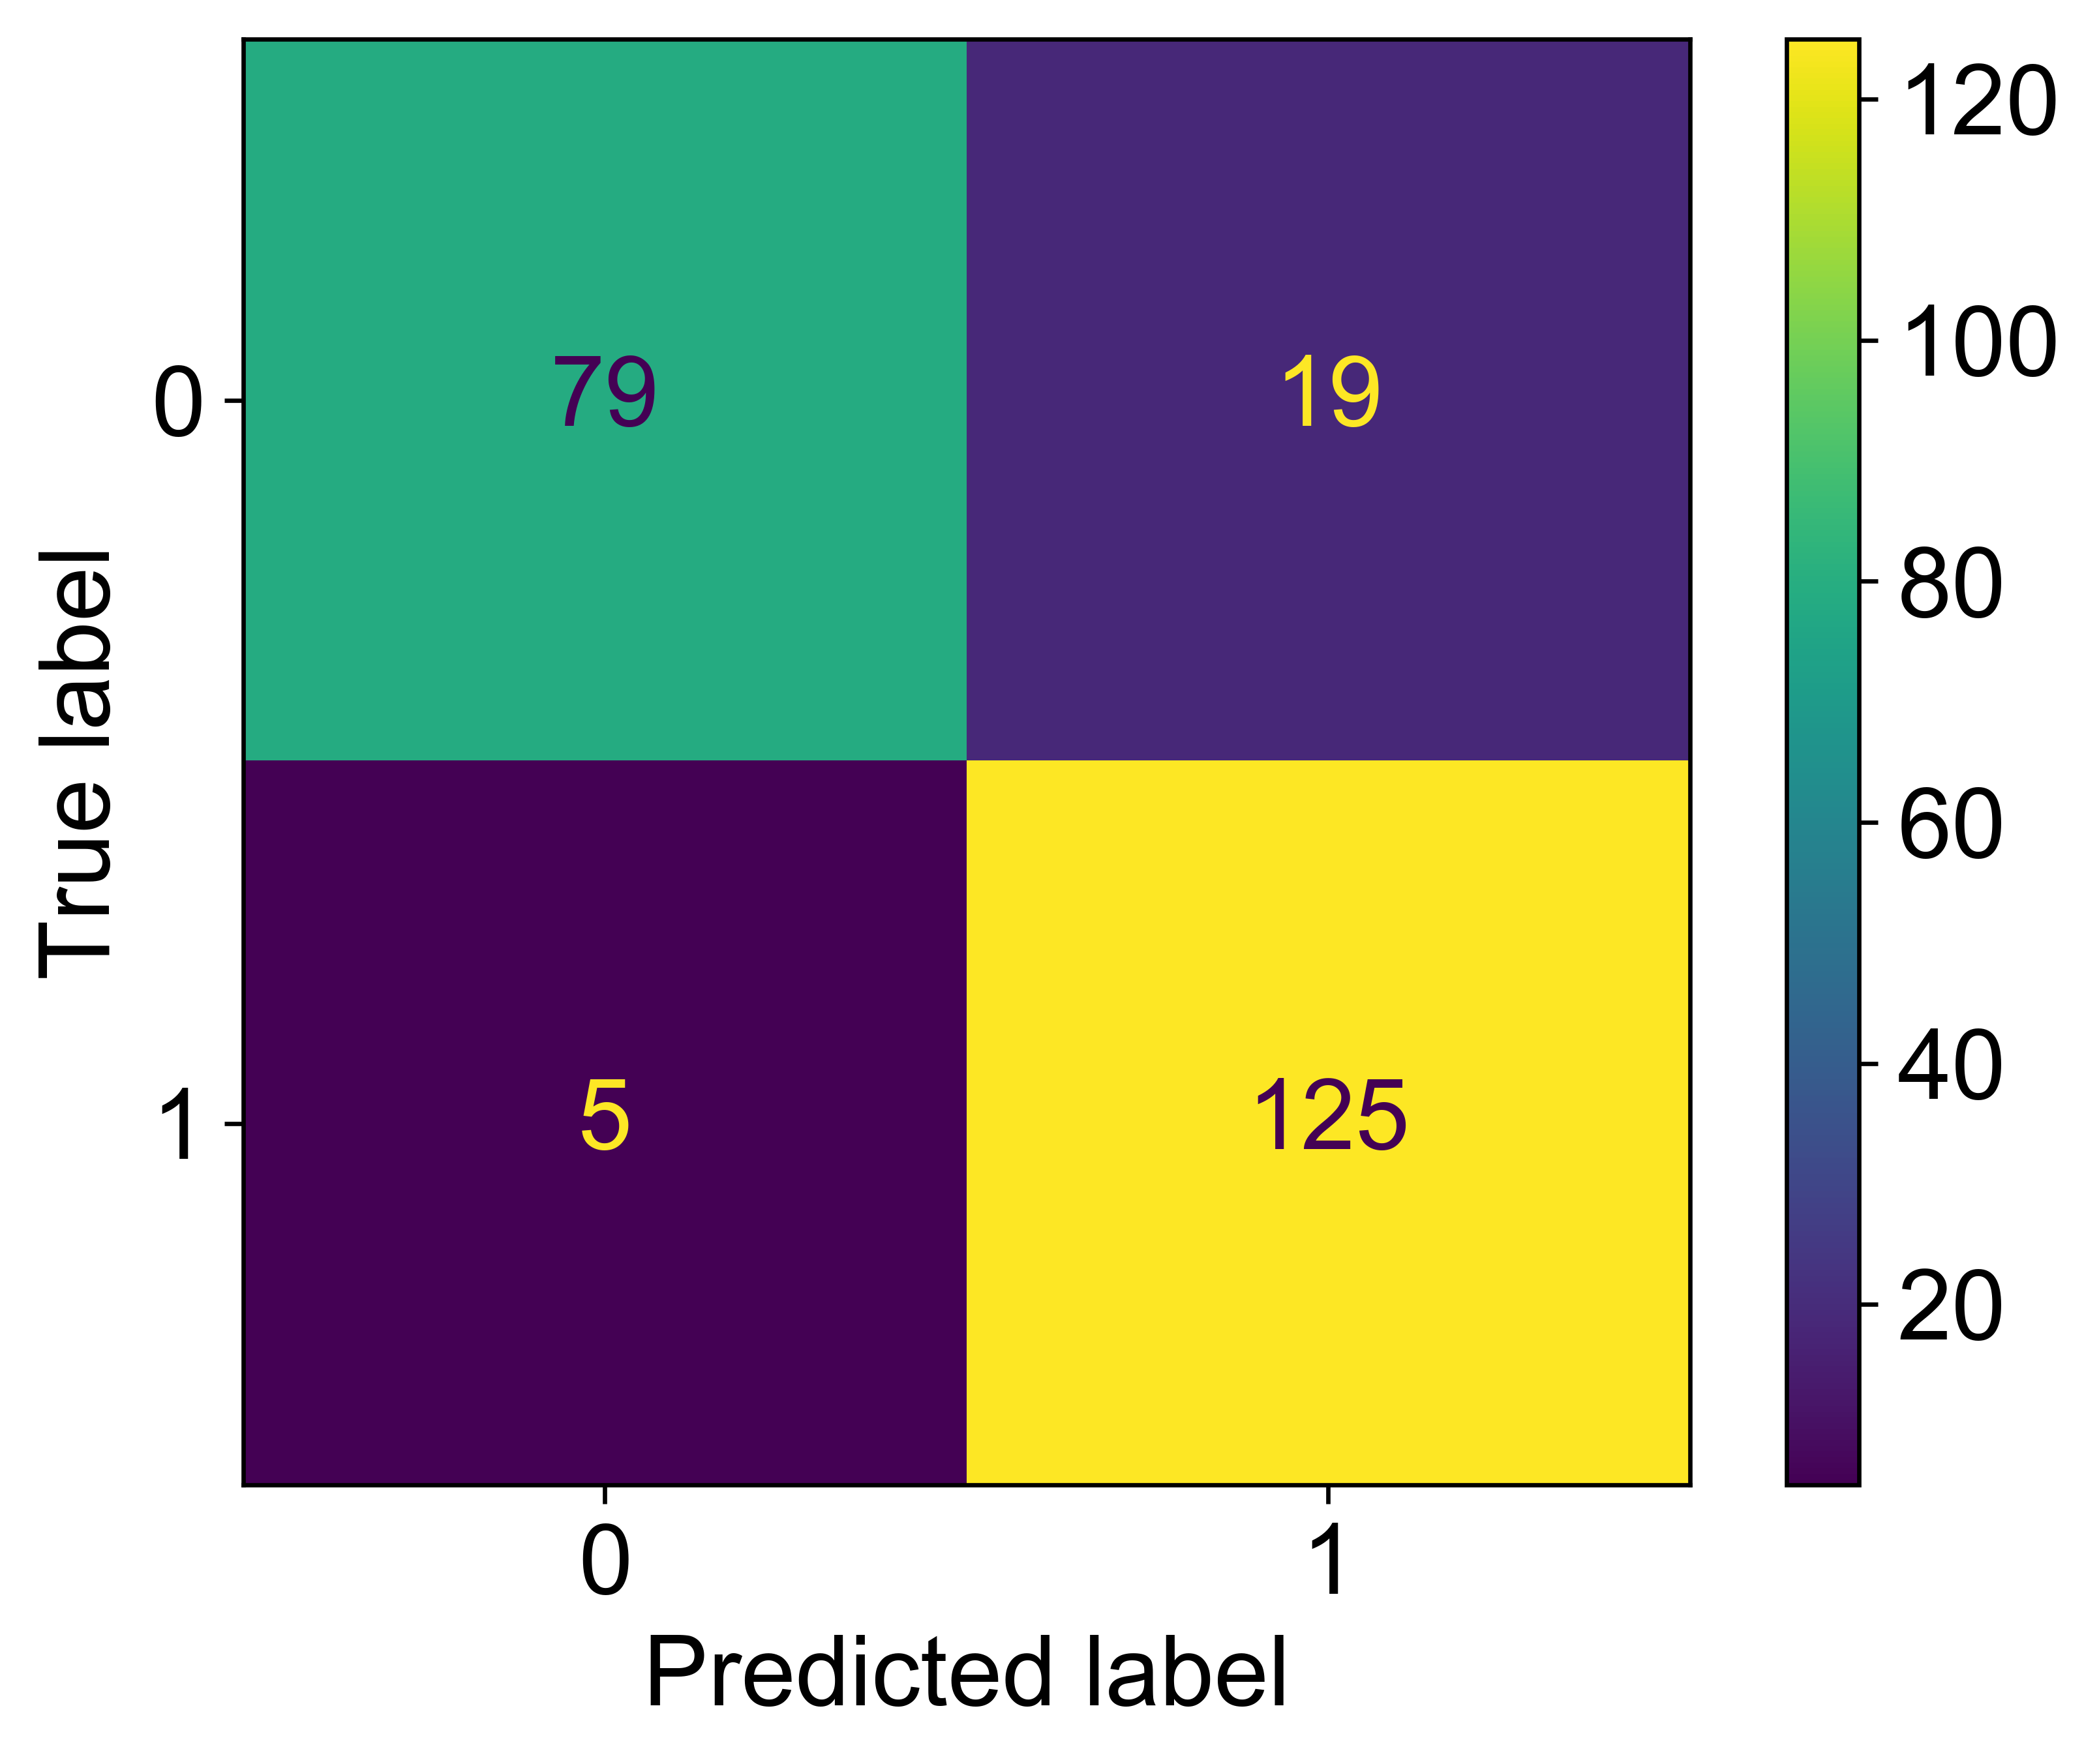

准确度：0.8947368421052632
灵敏度：0.9615384615384616
特异度：0.8061224489795918
MCC: 0.787831337496473
内部验证accuracy：0.895
内部验证precision：0.868
内部验证recall：0.962
内部验证f1-score：0.912


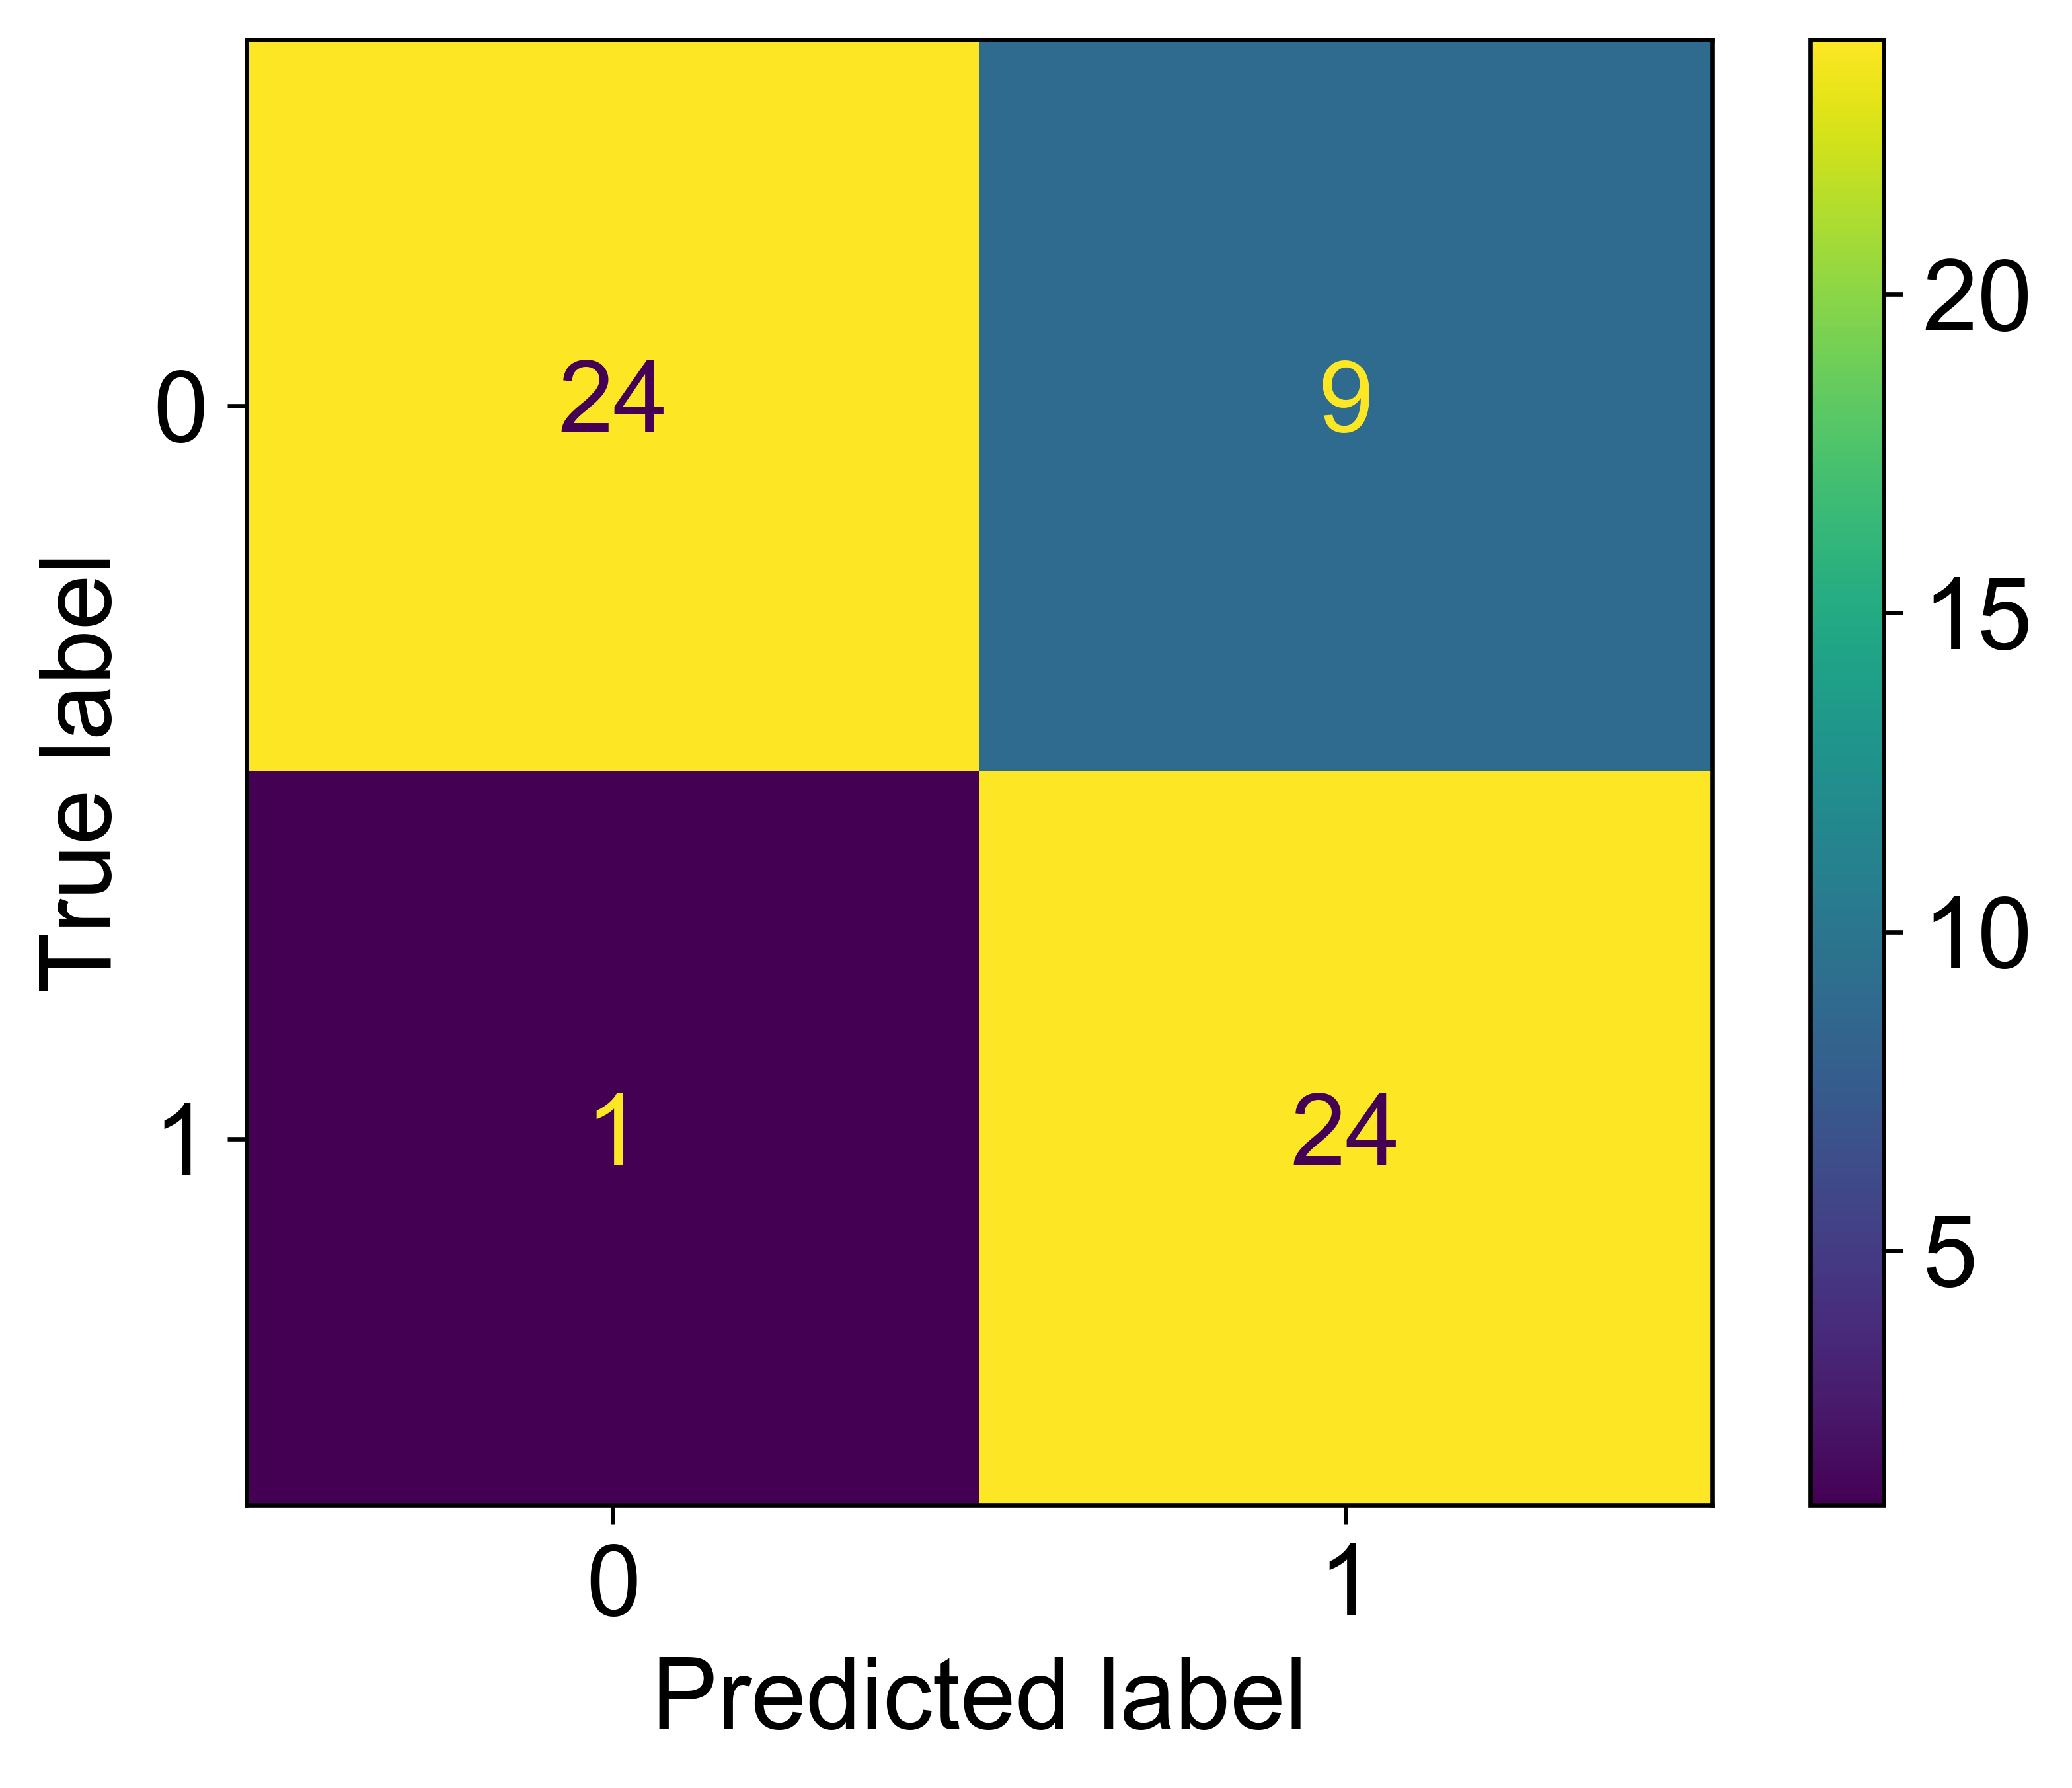

准确度：0.8275862068965517
灵敏度：0.96
特异度：0.7272727272727273
MCC: 0.6872727272727273


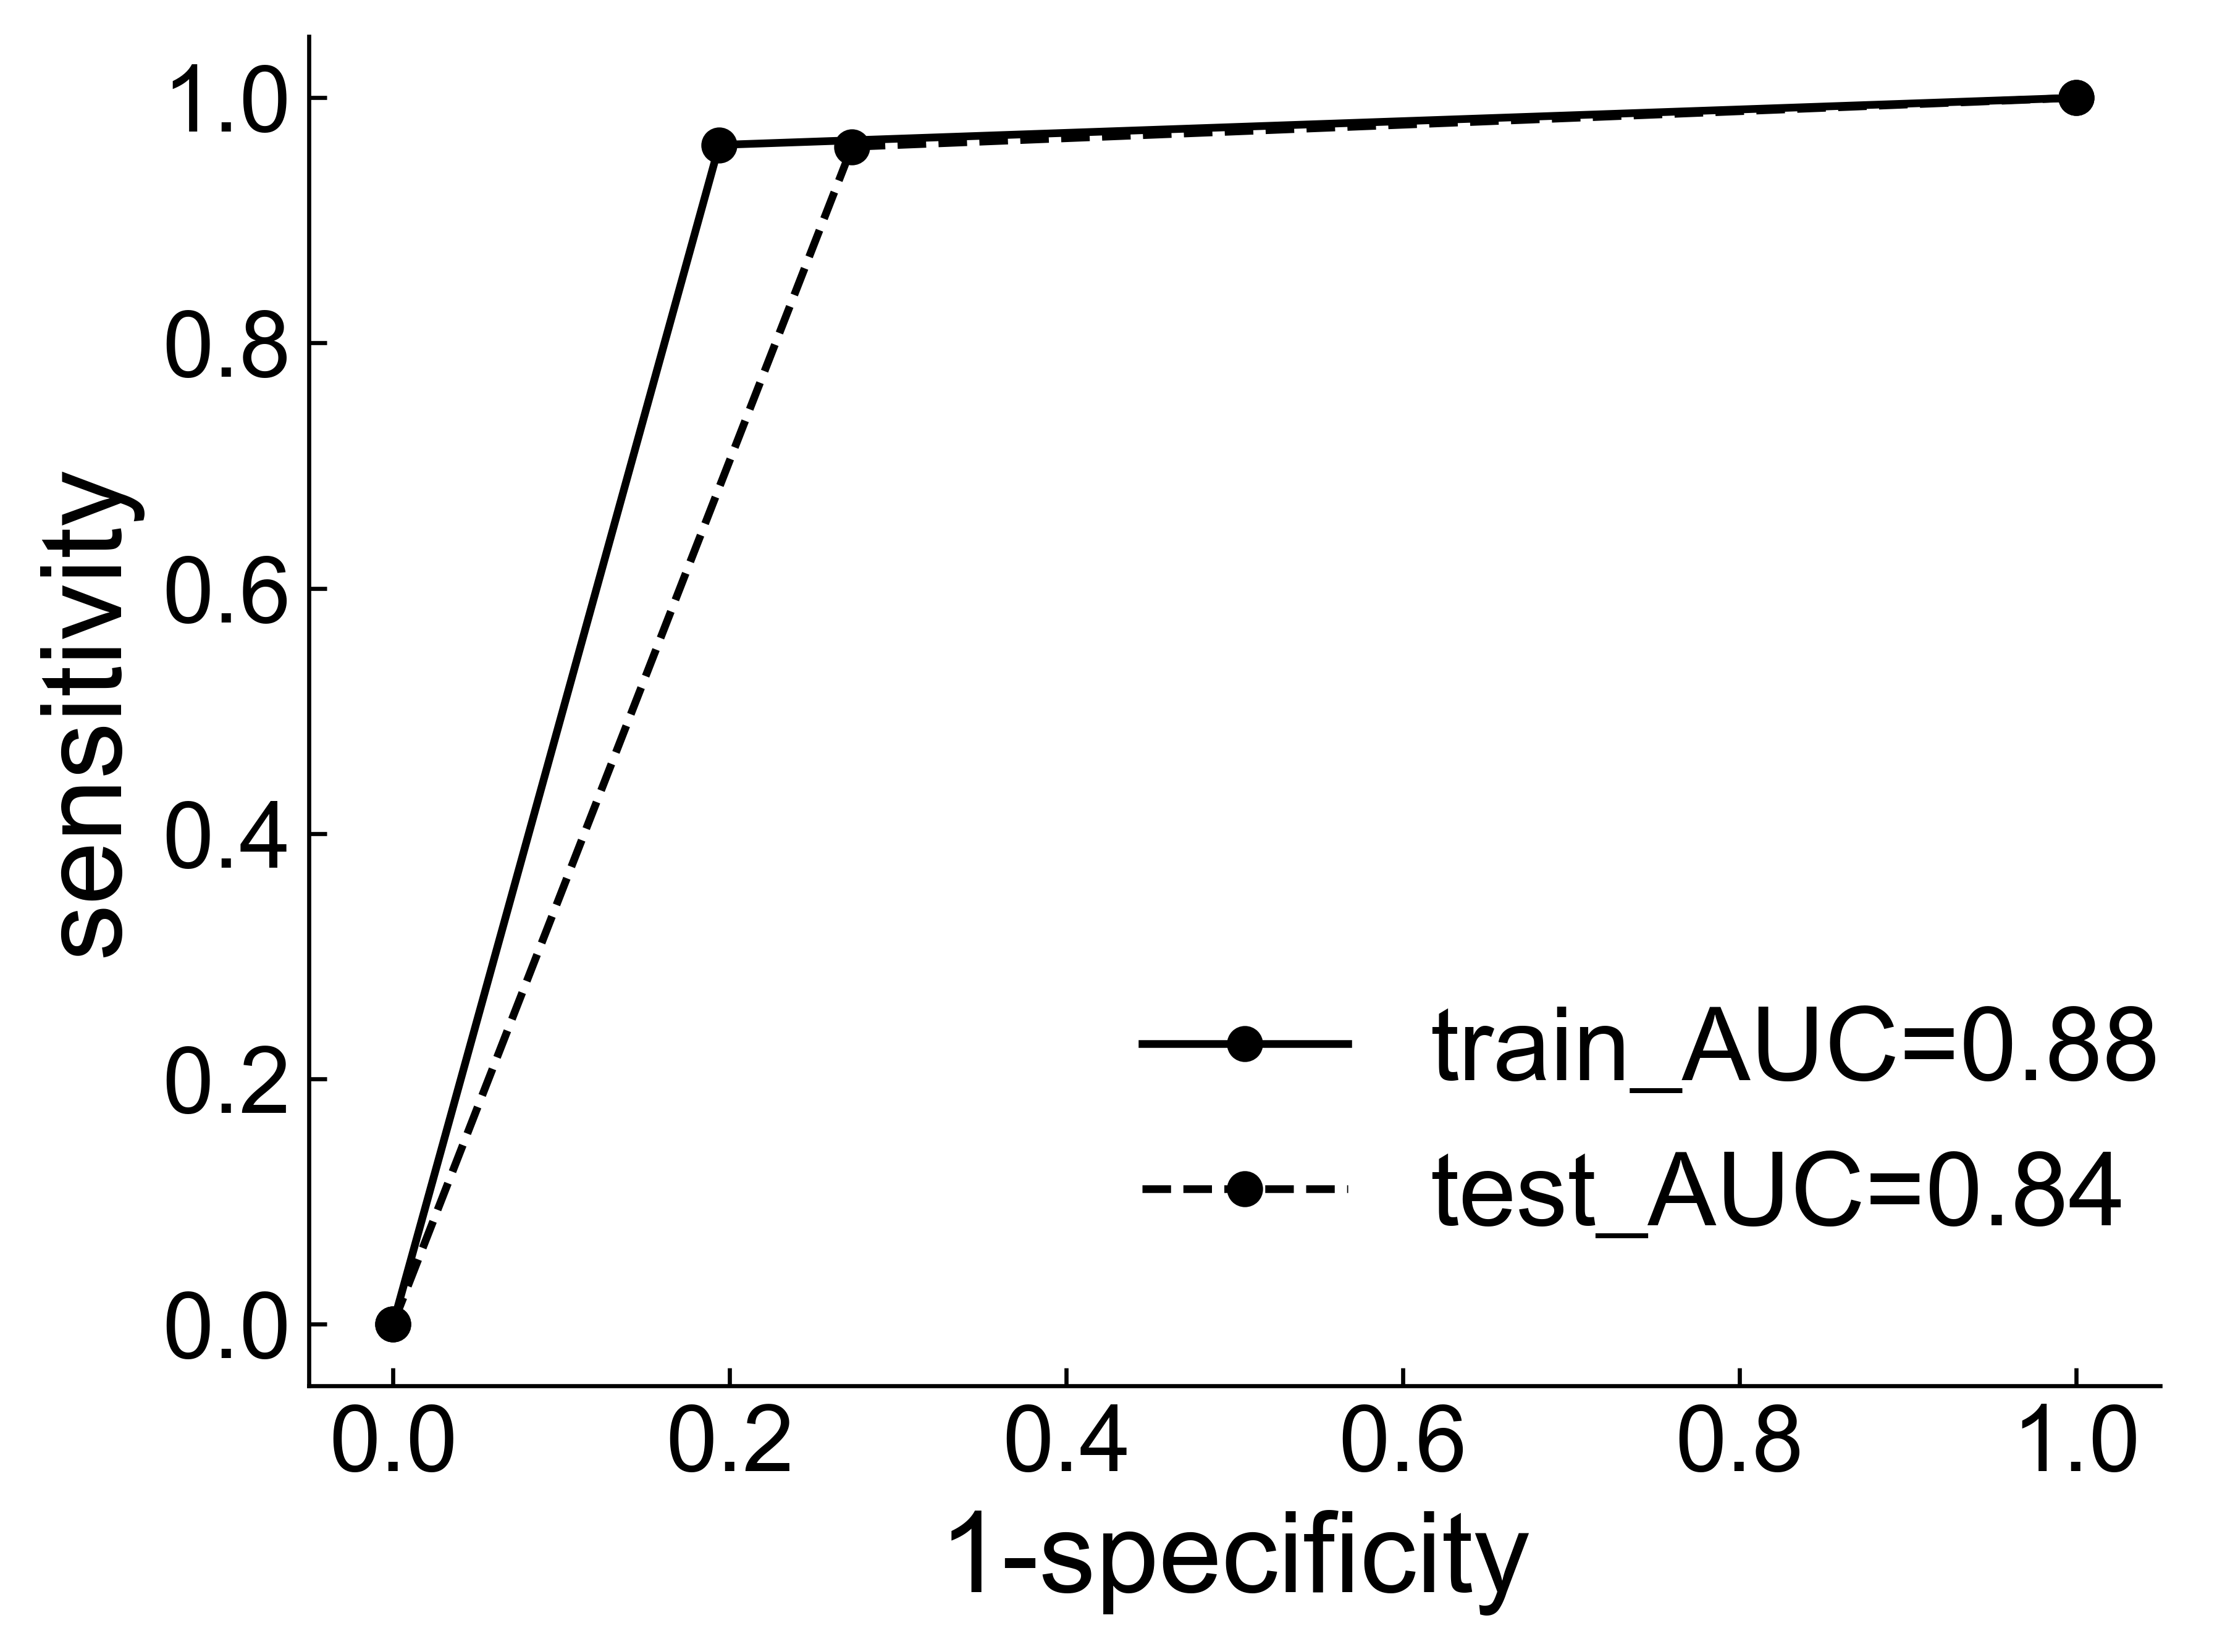

外部验证accuracy：0.828
外部验证precision：0.727
外部验证recall：0.960
外部验证f1-score：0.828


In [21]:
for rf in [True, False]:
    for xgb in [True, False]:
        for mlp in [True, False]:
            for gbdt in [True, False]:
                    count_true = 0
                    model_name = ""
                    model = []
                    if rf:
                        count_true += 1
                        model_name += "随机森林+"
                        model.append(("Random Forest", rf_model))
                    if xgb:
                        count_true += 1
                        model_name += "XGBoost+"
                        model.append(("XGB", xgb_model))
                    if mlp:
                        count_true += 1
                        model_name += "mlp+"
                        model.append(("MLP", mlp_model))
                    if gbdt:
                        count_true += 1
                        model_name += "梯度提升树+"
                        model.append(("GBDT", gbdt_model))
                    if count_true !=3 :
                        continue
                    model_name = model_name[:-1]
                    print(model_name)
                    cur_tif_name = "C:/Users/86151/Desktop/machinelearn/ceshi/" + model_name + ".tif"
                    
                    # 创建组合模型
                    '''eclf = VotingClassifier(
                    estimators=model,
                    voting="hard"
                                                )'''
                    eclf = VotingClassifier(
                    estimators=[  ("Random Forest", rf_model), ("XGB", xgb_model),("MLP", mlp_model),
                                    ("GBDT", gbdt_model)],
                    voting="soft",
                    # 定义每个模型的权重
                    weights = [0.776 if rf else 0, 0.793if xgb else 0, 0.793 if mlp else 0,
                                  0.810 if gbdt else 0]

                    )
                    # 训练模型，并进行验证
                    eclf.fit(X_train, Y_train)
                    
                    # 交叉验证代码
                    from sklearn.model_selection import cross_val_score
                    scores = cross_val_score(eclf, X_train, Y_train, cv=10)                   

                    # 分别进行内部验证和外部验证
                    train_predictions = eclf.predict(X_train)
                    acc, p, r, f1, FPR, TPR, AUC = evaluate_model(Y_train, train_predictions)
                    print("内部验证accuracy：{:.3f}".format(acc))
                    print("内部验证precision：{:.3f}".format(p))
                    print("内部验证recall：{:.3f}".format(r))
                    print("内部验证f1-score：{:.3f}".format(f1))
                    
                    test_predictions = eclf.predict(X_test)
                    acc, p, r, f1 = evaluate_model(Y_test, test_predictions, FPR, TPR, AUC)
                    print("外部验证accuracy：{:.3f}".format(acc))
                    print("外部验证precision：{:.3f}".format(p))
                    print("外部验证recall：{:.3f}".format(r))
                    print("外部验证f1-score：{:.3f}".format(f1))
                    
                    import os
                    # 获取桌面路径
                    desktop_path = "C:/Users/86151/Desktop/machinelearn/ceshi"
                                       
                    # 保存结果到csv，格式类似数据文件
                    all_predictions = eclf.predict(X)
                    temp_predictions = []
                    cur_df = deepcopy(df)
                    length = len(all_predictions)
                    for i in range(length):
                        if all_predictions[i] == 1:
                            temp_predictions.append("yes")
                        else:
                            temp_predictions.append("no")
                    cur_df["Y"] = temp_predictions   
                    cur_df.to_csv(f"{desktop_path}/{model_name}.csv", index=False)